# Using Machine Learning to Find Inefficient Stocks

> **IMPORTANT NOTE**
> The as-of date for the data pulled from API's is 7/12/2021. All markdown notes reflect observations from data pulled on the as-of date.

*Click to jump to matching Markdown Header*

- **[INTRODUCTION](#INTRODUCTION)**<br>
- **[DATA COLLECTION](#DATA-COLLECTION)**<br>
- **[DATA CLEANING](#DATA-CLEANING)**<br>
- **[DATA EXPLORATION](#DATA-EXPLORATION)**<br>
- **[DATA MODELING](#DATA-MODELING)**<br>
- **[DATA INTERPRETATION](#DATA-INTERPRETATION)**<br>
- **[RECOMMENDATIONS AND CONCLUSIONS](#RECOMMENDATIONS-AND-CONCLUSIONS)**

# INTRODUCTION

HIT Investments is looking to leverage advanced analytics to identify inefficient companies where their low stock price is attractive when compared to their historic performance. HIT investments has 2 key evaluation metrics that are used to identify these companies:
1. **Value Metrics** which provide insight into a companies price relative to their recent historic performance
2. **Growth Metrics** which provide insight into a companies recent stock performance to measure whether a company's value is growing and how volatile the price has been

This analysis will provide answers to the following important business questions:
1. Where are there significant data quality issues which skew the results?
2. Which companies show high value, growth and low volatility?
3. How can machine learning classification be used to predict which companies to buy and which metrics are most important in making that prediction?

The insights of the analysis will be summarized in a Tableau dashboard that HIT Investments can utilize to keep track of their current holdings, explore data quality issues and determine which companies could be a good investment.

# Business Statement

HIT Investments strives to maximize after-tax returns for their clients by actively identifying and capitalizing on proven inefficiencies in the stock market using quantitative analysis. 

A market is said to be "efficient" if the price of a stock reflects all available and relevant information. This theory holds true for larger companies that are thoroughly tracked by investment firms. However, HIT Investments believes the market has inefficiencies, specifically in the Micro-Cap and Small-Cap segments, which can be exploited to outpeform the stock market and deliver maximum return on investment. 

The 3 business questions that are important to answer with this analysis are:
1. Where are there significant data quality issues?

The Financial Modeling Prep API is constantly improving their data quality but there are significant issues that have been observed by HIT Investments that need to be identified. I will utilize an anomaly detection machine learning model along with a Tableau dashboard to highlight these data quality issues so that companies can be evaluated based on accurate data only.

2. Which companies show high value, growth and low volatility?

There are over 20,000 potential companies to invest in across multiple global markets. Manually evaluating each company for investment is unreasonable because of how quickly a company's stock price changes relative to how quickly someone could evaluate a company's performance. By using the Value and Growth Metrics, companies which show promise for investment can be quickly identified. 

3. How can machine learning classification be used to predict which companies to buy and which metrics are most important in making that prediction?

Machine learning is a way in which companies can be quickly evaluated based on historic performance on the Value Metrics, Growth Metrics as well as other important features of a company. Another benefit of machine learning is that some models will provide insights into which company features are most important to focus on when predicting which companies to invest in.

# Analysis Methodology

This analysis will gather company specific performance metrics from the Financial Modeling Prep [FMP API](https://financialmodelingprep.com/developer/docs). I utilized a [Data Collection notebook](https://github.com/bentson1187/Stock-Market-Inefficiency-Analysis/blob/dde064775aef01477dd5dcd21c0d8ca363cb2213/Data%20Collection.ipynb) to produce the API calls and the .csv's necessary to import into this analysis as well as the [Tableau dashboard](https://public.tableau.com/app/profile/brian8863/viz/CapstoneDashboard_16252496264850/HoldingsDashboard?publish=yes). That Data Collection notebook can be found in the same github repo. 

There a 2 main focuses of this analysis:
1. Finding data quality issues
2. Find which companies show promise for investment using machine learning classification

In order to find potential data quality issues, I will utilize an anomaly detection algorithm called Isolation Forest which will show the most extreme outliers in the data with respect to a company's Value Metrics and Growth Metrics. This will help validate whether or not the values that feed these metrics are accurate.

To find which companies show promise for investment, companies will be analyzed on their historical performance for Value Metrics and Growth Metrics. Each company will be labeled based on domain expertise rules-of-thumb into one of the following buckets:
1. Buy
2. Risky Buy
3. Affordable
4. Hold
5. Sell

A machine learning classification model will then be trained on these new labels to ultimately predict which companies should be evaluated further for investing and which company features played a significant role in those predictions. 

Lastly, all relevant company information and model predictions will be summarized in an interactive Tableau dashboard which allows HIT Investment employees to quickly research the companies for which the model predicts are good investments and have accurate underlying data quality.

# DATA COLLECTION

## Import Packages

In [455]:
pip install feature-engine

In [456]:
#data collection
import requests
import json
from urllib.request import urlopen

#data wrangling and visualization packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
import statsmodels.api as sm
import scipy.stats as stats
import plotly.express as px

#feature engineering packages
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler

#feature selection packages
from feature_engine.selection import DropConstantFeatures, DropDuplicateFeatures

#modeling packages
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.pipeline import Pipeline
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier

#modeling evaluation packages
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import plot_roc_curve, roc_curve, auc
from sklearn.metrics import get_scorer
from sklearn.metrics import roc_auc_score
from yellowbrick.classifier import ROCAUC

#optimization packages
from sklearn.model_selection import GridSearchCV

In [457]:
#notebook settings
pd.set_option("display.max_rows", 50)
pd.options.display.float_format = '{:,}'.format

from pylab import rcParams
rcParams['figure.figsize'] = 20,12

import warnings
warnings.filterwarnings('ignore')

sns.set_palette("muted")

## Global Functions

In [458]:
def col_eval(df, label_count=25, thresh=0.025):
    
  '''
  This function evaluates each column in a dataframe. The output of this function
  is different for categorical and numerical data. The function provides detailed
  statistics and graphs.
  Keyword Arguments:
  - df -- A dataframe
  - label_count -- Number of labels to draw in bar graph (default=25)
  - thresh -- A threshold line drawn on the bar graph to indicate percentage 
  (default = 0.025)
  '''

  for col in df:
    if df[col].dtype != 'object':

      #print the column name
      print(f'Column Name: {col}')
      
      #print the number of unique values
      print(f'Number of unique values: {df[col].nunique()}')
      
      #print the number of duplicate values
      print(f'There are {df[col].duplicated().sum()} duplicates')
      
      #print the number of null values
      print(f'There are {df[col].isna().sum()} null values')
      
      #print the value counts
      print(df[col].value_counts(dropna=False))
      print('\n')     
      
      #print descriptive statistics
      print('Descriptive Metrics:','\n',
            df[col].describe())
      
      #plot boxplot, histogram         
      fig, ax = plt.subplots(ncols=2, figsize=(15,10))
      
      histogram = df[col].hist(ax=ax[0])
      ax[0].set_title(f'Distribution of {col}');
      
      boxplot = df.boxplot(column=col, ax=ax[1]);
      ax[1].set_title(f'Boxplot of {col}');

      plt.tight_layout()

      plt.show()
      print('\n')
    else:
      #print the column name
      print(f'Column Name: {col}')
      
      #print the number of unique values
      print(f'Number of unique values: {df[col].nunique()}')
      
      #print the number of duplicate values
      print(f'There are {df[col].duplicated().sum()} duplicates')
      
      #print the number of null values
      print(f'There are {df[col].isna().sum()} null values')
      
      #print the value counts
      print(df[col].value_counts(dropna=False))
      print('\n')     
      
      #print descriptive statistics
      print('Descriptive Metrics:','\n',
            df[col].describe())
      
      #plot barplot        
      fig, ax = plt.subplots(figsize=(15,10))

      bar_graph = df[col].value_counts(normalize=True, 
                                        dropna=False)[:label_count].plot.bar(label=f'{col} Percentage')
      ax.axhline(y=thresh, color='red', linestyle='--', 
                  label=f'{thresh*100}% Threshold')
      ax.set_title(f'{col} Value Counts')
      ax.set_xlabel(f'{col} Labels')
      ax.set_ylabel('Percentage')
      ax.legend()

      plt.tight_layout()

      plt.show()
  return

In [459]:
def rare_labels(df, col, thresh):
  
  rare_labels = df[col].value_counts(normalize=True).loc[lambda x : x <= thresh].index
  
  df.loc[df[col].isin(rare_labels), col] = 'Rare'

  return df

In [460]:
def model_eval(model, X_train, y_train, X_test, y_test, 
              prev_model=None, prev_X_train=None, prev_y_train=None,
              prev_X_test=None, prev_y_test=None):
    
    ### add feature importances graph!
    
    
    '''
    This function takes in a fit model and provides classification evaluation
    metrics on that model. Optionally, a previous model can be supplied to give
    improvement metrics between the current model and the previous model.
    Keyword Arguments:
    - model: A fit model
    - X_train, y_train, X_test, y_test: Training and testing dataframes which
    the "model" stated above was fit on.
    - prev_model: Another fit model
    - prev_X_train, prev_y_train, prev_X_test, prev_y_test: Training and 
    testing dataframes which the previous model was fit on.
    '''
   
    #current model predictions on testing dataframe
    y_hat_test = model.predict(X_test)
    
    #get scores of current model on testing dataframe
    recall_model = recall_score(y_test, y_hat_test, average='macro')
    f1_model = f1_score(y_test, y_hat_test, average='macro')
    accuracy_model = accuracy_score(y_test, y_hat_test)
    recall_model_train = recall_score(y_train, y_train, average='macro')

    #if statement to check for availability of a previous model and training
    #and testing dataframes
    if prev_model != None:
        
        #if prevoius model has same training and testing dataframes as current model
        if prev_X_train is None:
                 
            #get previous model predictions and scores
            y_hat_test_prev = prev_model.predict(X_test)

            recall_prev = recall_score(y_test, y_hat_test_prev, average='macro')
            f1_prev = f1_score(y_test, y_hat_test_prev, average='macro')
            accuracy_prev = accuracy_score(y_test, y_hat_test_prev)

            print('MODEL EVAL VS PREVIOUS (TEST)')
            print('=================================================================')
            
            #create dataframe comparing current and previous model
            df = pd.DataFrame(index=['Recall','F1','Accuracy'], 
                              columns=['Previous Model','Current Model','Delta'])

            df.loc['Recall','Current Model'] = recall_model.round(2)
            df.loc['Recall','Previous Model'] = recall_prev.round(2)
            df.loc['F1','Current Model'] = f1_model.round(2)
            df.loc['F1','Previous Model'] = f1_prev.round(2)
            df.loc['Accuracy','Current Model'] = accuracy_model.round(2)
            df.loc['Accuracy','Previous Model'] = accuracy_prev.round(2)
            df.loc['Recall','Delta'] = (recall_model - recall_prev).round(2)
            df.loc['F1','Delta'] = (f1_model - f1_prev).round(2)
            df.loc['Accuracy','Delta'] = (accuracy_model - accuracy_prev).round(2)

            #display dataframe
            display(df)
            print('\n')

            #display current model scores, reports and graphs
            print(f"CURRENT MODEL: {'Overfit (Recall)' if recall_model_train - recall_model > .05 else 'Not Overfit (Recall)'}")
            print('=================================================================')
            print('\n')
            
            print(f'Recall on Training: {recall_model_train}')
            print(f'Recall on Test: {recall_model}')
            print('\n')
            
            print('Classification Reports-------------------------------------------')
            print(classification_report(y_test, y_hat_test))

            print('Test Graphs------------------------------------------------------')
            fig, ax = plt.subplots(ncols=2, figsize=(18,10))

            #plot confusion matrix
            plot_confusion_matrix(model, X_test, y_test, cmap='Blues',
                                         normalize='true', ax=ax[0]);

            #plot multi-class ROCAUC curve
            visualizer = ROCAUC(model, ax=ax[1])
            visualizer.fit(X_train, y_train)
            visualizer.score(X_test, y_test)
            plt.legend()
            
            print('\n')

            #feature importances graph
            feature_importances = model.feature_importances_
            
            feature_importances_df = pd.DataFrame(feature_importances, index=X_train.columns, 
                                      columns=['Feature Importances']).sort_values('Feature Importances', 
                                                                                   ascending=False)[:10]

            fig, ax = plt.subplots()
            sns.barplot(data=feature_importances_df, 
                        x=feature_importances_df['Feature Importances'], 
                        y=feature_importances_df.index, orient='h', color='blue',ax=ax)
            ax.set_title('Feature Importances', fontsize='xx-large')
            ax.set_ylabel('Features', fontsize='large')
            ax.set_yticklabels(labels=feature_importances_df.index, fontsize='xx-large')

            plt.show()
            plt.tight_layout()
            
            print('\n')

            #display previous model graphs
            print("PREVIOUS MODEL")
            print('=================================================================')
            fig, ax = plt.subplots(ncols=2, figsize=(18,10));

            #plot confusion matrix
            plot_confusion_matrix(prev_model, X_test, y_test, cmap='Blues',
                                         normalize='true', ax=ax[0]);

            #plot multi-class ROCAUC curve
            visualizer = ROCAUC(prev_model, ax=ax[1])
            visualizer.fit(X_train, y_train)
            visualizer.score(X_test, y_test)
            plt.legend()
            
            plt.show()
            plt.tight_layout()

        else:
            #if previous model has a different dataframes as current model
            
            y_hat_test_prev = prev_model.predict(prev_X_test)

            recall_prev = recall_score(prev_y_test, y_hat_test_prev, average='macro')
            f1_prev = f1_score(prev_y_test, y_hat_test_prev, average='macro')
            accuracy_prev = accuracy_score(prev_y_test, y_hat_test_prev)

            print('MODEL EVAL VS PREVIOUS (TEST)')
            print('=================================================================')

            df = pd.DataFrame(index=['Recall','F1','Accuracy'], 
                              columns=['Previous Model','Current Model','Delta'])

            df.loc['Recall','Current Model'] = recall_model.round(2)
            df.loc['Recall','Previous Model'] = recall_prev.round(2)
            df.loc['F1','Current Model'] = f1_model.round(2)
            df.loc['F1','Previous Model'] = f1_prev.round(2)
            df.loc['Accuracy','Current Model'] = accuracy_model.round(2)
            df.loc['Accuracy','Previous Model'] = accuracy_prev.round(2)
            df.loc['Recall','Delta'] = (recall_model - recall_prev).round(2)
            df.loc['F1','Delta'] = (f1_model - f1_prev).round(2)
            df.loc['Accuracy','Delta'] = (accuracy_model - accuracy_prev).round(2)

            display(df)
            print('\n')


            print(f"CURRENT MODEL: {'Overfit (Recall)' if recall_model_train - recall_model > .05 else 'Not Overfit (Recall)'}")
            print('=================================================================')
            print('\n')
            
            print(f'Recall on Training: {recall_model_train}')
            print(f'Recall on Test: {recall_model}')
            print('\n')
            
            print('Classification Reports-------------------------------------------')
            print(classification_report(y_test, y_hat_test))

            print('Test Graphs------------------------------------------------------')
            fig, ax = plt.subplots(ncols=2, figsize=(18,10))

            #plot confusion matrix
            plot_confusion_matrix(model, X_test, y_test, cmap='Blues',
                                         normalize='true', ax=ax[0]);

            #plot multi-class ROCAUC curve
            visualizer = ROCAUC(model, ax=ax[1])
            visualizer.fit(X_train, y_train)
            visualizer.score(X_test, y_test)
            plt.legend()
            
            plt.show()

            print("PREVIOUS MODEL")
            print('=================================================================')
            fig, ax = plt.subplots(ncols=2, figsize=(18,10));

            #plot confusion matrix
            plot_confusion_matrix(prev_model, prev_X_test, prev_y_test, cmap='Blues',
                                         normalize='true', ax=ax[0]);

            #plot multi-class ROCAUC curve
            visualizer = ROCAUC(prev_model, ax=ax[1])
            visualizer.fit(prev_X_train, prev_y_train)
            visualizer.score(prev_X_test, prev_y_test)
            plt.legend()

            plt.show()

            plt.tight_layout()
    else:
        #if there is no previous model, get current model metrics and graphs
        print(f"CURRENT MODEL: {'Overfit (Recall)' if recall_model_train - recall_model > .05 else 'Not Overfit (Recall)'}")
        print('=================================================================')
        print('\n')
        print('Classification Reports-------------------------------------------')
        print(classification_report(y_test, y_hat_test))
               
        print('Test Graphs------------------------------------------------------')
        fig, ax = plt.subplots(ncols=2, figsize=(18,10))

        #plot confusion matrix
        plot_confusion_matrix(model, X_test, y_test, cmap='Blues',
                                     normalize='true', ax=ax[0]);

        #plot multi-class ROCAUC curve
        visualizer = ROCAUC(model, ax=ax[1])
        visualizer.fit(X_train, y_train)
        visualizer.score(X_test, y_test)
        plt.legend()
        
        plt.show()

  
    return

## Import Data

I will use the Data Collection.ipynb file in the Data folder to utilize Financial Modeling Prep's API to pull in the following information:
1. Value Metrics in the trailing twelve months (TTM)
2. Price Metrics for the past 190 trading days (9 months)
3. Company Profile information
4. R&D spend in the last complete year
5. Financial Values such as EBITDA, Enterprise Value, Cashflows, Sales and Earnings

Two main data cleaning steps are done in the Data Collection.ipynb file after collecting the data through API:
1. Removal of stocks which have null values in any of the Value Metrics
2. Removal of stocks which have negative values in any of the Value Metrics

The Data Collection.ipynb file produces a .csv that I will load into this analysis and can be found HERE.

In [461]:
#import csv
df_original = pd.read_csv('https://raw.githubusercontent.com/bentson1187/Stock-Market-Inefficiency-Analysis/main/Data/full%20dataset%20for%20capstone%20(7-12-21).csv',
                          index_col='Unnamed: 0')

In [462]:
#view the dataframe
df_original.head()

,symbol,revenue_per_share_ttm,pe_ratio_ttm,market_cap_ttm,ps_ratio_ttm,ev_to_EBITDA_ttm,ev_to_free_cashflow_ttm,ev_to_operating_cashflow_ttm,date,open,high,low,close,adjClose,volume,unadjustedVolume,change,changePercent,vwap,label,changeOverTime,percent_change,percent_negative,percent_positive,percent_flat,total_percent_negative,total_percent_positive,FIP,price,beta,volAvg,mktCap,lastDiv,range,changes,companyName,currency,cik,isin,cusip,exchange,exchangeShortName,industry,website,description,ceo,sector,country,fullTimeEmployees,phone,address,city,state,zip,dcfDiff,dcf,image,ipoDate,defaultImage,isEtf,isActivelyTrading,rd_spend,enterprise_value,ebitda,sales,earnings,freeCashFlow,operatingCashFlow
0,0003.HK,2.29,31.09,"219,653,328,020.16",5.41,26.61,89.15,25.72,2021-07-12,12.24,12.24,12.12,12.24,12.24,"14,263,608.0","14,263,608.0",0.0,0.0,12.2,"July 12, 21",0.0,0.05,False,False,True,0.47,0.41,0.07,12.38,0.440022,19558890,231009550336,0.34428600000000004,10.133333-13.047619,0.14,The Hong Kong and China Gas Company Limited,HKD,nan,HK0003000038,Y33370100,HKSE,HKSE,Utilities—Regulated Gas,http://www.towngas.com,"The Hong Kong and China Gas Company Limited, t...","Mr. Wing Kin Chan B.Sc., M.Sc., B.B.S., Hon.F...",Utilities,HK,"53,765.0",852 2963 3189,363 Java Road,North Point,NaN,NaN,nan,0.0,https://financialmodelingprep.com/image-stock/...,2020-12-15,False,False,True,0.0,"223,823,267,609.74","10,893,700,000.0","40,927,000,000.0","6,117,600,000.0","2,615,300,000.0","9,910,200,000.0"
1,0006.HK,0.63,14.43,"102,871,411,722.8",76.31,60.31,54.67,54.67,2021-07-12,47.55,47.7,47.2,47.4,47.4,"3,434,492.0","3,434,492.0",-0.15,-0.32,47.43,"July 12, 21",-0.0,0.07,True,False,False,0.46,0.46,0.0,48.25,0.553897,2705709,102978043904,2.81,39.2-50.55,0.85,Power Assets Holdings Limited,HKD,nan,HK0006000050,Y7092Q109,HKSE,HKSE,Utilities—Independent Power Producers,http://www.powerassets.com,"Power Assets Holdings Limited, an investment h...","Mr. Kin Ning Fok B.A., F.C.A., BA, DFM, FCA (...",Utilities,HK,13.0,852 2122 9122,Cheung Kong Center,Central,NaN,NaN,nan,0.0,https://financialmodelingprep.com/image-stock/...,2000-01-03,False,False,True,0.0,"86,358,004,175.94","1,120,000,000.0","1,270,000,000.0","6,132,000,000.0","960,000,000.0","962,000,000.0"
2,0012.HK,5.0,10.55,"179,359,050,000.0",7.42,26.33,38.7,38.7,2021-07-12,36.5,36.75,36.25,36.55,36.55,"1,774,792.0","1,774,792.0",0.05,0.14,36.52,"July 12, 21",0.0,0.18,False,True,False,0.49,0.45,0.04,37.0,0.978441,3803950,179116998656,1.8,27.2-38.85,0.45,Henderson Land Development Company Limited,HKD,nan,HK0012000102,Y31476107,HKSE,HKSE,Real Estate Services,http://www.hld.com,"Henderson Land Development Company Limited, an...","Mr. Ka-Shing Lee J.P., JP",Real Estate,HK,"9,065.0",852 2908 8888,Two International Finance Centre,Central,NaN,NaN,nan,0.0,https://financialmodelingprep.com/image-stock/...,2000-01-03,False,False,True,0.0,"235,071,704,841.0","12,957,000,000.0","25,020,000,000.0","10,192,000,000.0","7,072,000,000.0","7,072,000,000.0"
3,0016.HK,28.53,14.24,"337,237,895,708.4",4.08,10.52,9.38,8.8,2021-07-12,114.0,115.6,113.1,115.0,115.0,"3,408,483.0","3,408,483.0",1.0,0.88,114.57,"July 12, 21",0.01,0.13,False,True,False,0.46,0.49,-0.03,116.4,0.746821,3227665,337327194112,4.95,90.5-126.0,1.4,Sun Hung Kai Properties Limited,HKD,nan,HK0016000132,Y82594121,HKSE,HKSE,Real Estate—Development,http://www.shkp.com,Sun Hung Kai Properties Limited develops and i...,"Mr. Ping-Luen Kwok J.P., M.A., M.B.A., MA(Can...",Real Estate,HK,"39,500.0",852 2827 8111,Sun Hung Kai Centre,Wan Chai,NaN,NaN,nan,0.0,https://financialmodelingprep.com/image-stock/...,2020-12-15,False,False,True,0.0,"352,951,163,930.37","40,036,000,000.0","82,653,000,000.0","23,690,000,000.0","44,882,000,000.0","47,868,000,000.0"
4,0025.HK,21.14,5.51,"2,934,740,160.0",0.46,6.93,23.83,11.03,2021-07-12,9.7,9.7,9.7,9.7,9.7,"2,017.0","2,017.0",0.0,0.0,9.7,"July 12, 21",0.0,-0.06,False,False,True,0.17,0.21,0.04,9.8,0.302325,12634,2958894336,0.48,8.99-10.24,

## Investigate Data

In [463]:
#dataframe info
df_original.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5136 entries, 0 to 5135
Data columns (total 68 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   symbol                        5136 non-null   object 
 1   revenue_per_share_ttm         5136 non-null   float64
 2   pe_ratio_ttm                  5136 non-null   float64
 3   market_cap_ttm                5136 non-null   float64
 4   ps_ratio_ttm                  5136 non-null   float64
 5   ev_to_EBITDA_ttm              5136 non-null   float64
 6   ev_to_free_cashflow_ttm       5136 non-null   float64
 7   ev_to_operating_cashflow_ttm  5136 non-null   float64
 8   date                          5136 non-null   object 
 9   open                          5136 non-null   float64
 10  high                          5136 non-null   float64
 11  low                           5136 non-null   float64
 12  close                         5136 non-null   float64
 13  adj

In [464]:
#evaluate each numeric feature
df_original.describe()

,revenue_per_share_ttm,pe_ratio_ttm,market_cap_ttm,ps_ratio_ttm,ev_to_EBITDA_ttm,ev_to_free_cashflow_ttm,ev_to_operating_cashflow_ttm,open,high,low,close,adjClose,volume,unadjustedVolume,change,changePercent,vwap,changeOverTime,percent_change,total_percent_negative,total_percent_positive,FIP,price,beta,volAvg,mktCap,lastDiv,changes,cik,fullTimeEmployees,dcfDiff,dcf,rd_spend,enterprise_value,ebitda,sales,earnings,freeCashFlow,operatingCashFlow
count,"5,136.0","5,136.0","5,136.0","5,136.0","5,136.0","5,136.0","5,136.0","5,136.0","5,136.0","5,136.0","5,136.0","5,135.0","5,123.0","5,123.0","5,136.0","5,136.0","5,122.0","5,136.0","5,136.0","5,136.0","5,136.0","5,128.0","5,136.0","5,136.0","5,136.0","5,136.0","5,136.0","5,136.0","2,239.0","4,935.0","1,118.0","2,532.0","5,136.0","5,136.0","5,136.0","5,136.0","5,136.0","5,136.0","5,136.0"
mean,235.65574571651183,103.3914914330218,"112,491,321,438.1482",9.096849688473505,177.11159073208694,126.8311740654203,42.66743185358258,389.1912227414319,393.96033683800385,385.4950798286613,389.77735591900284,389.85022979552065,"317,705,815.32461447","317,705,815.32461447",0.5861312305295951,0.2934053738317758,387.63206755173655,0.0031464174454828315,inf,0.4579380841121471,0.4292133956386348,0.012985569422776896,389.44499425720386,0.9636760496495301,"3,014,564.3222352024","55,784,786,182.80393",4.075474702297515,1.002935177180686,"1,028,947.4537740062","17,818.805268490374","1,472,271,810.3387306",316.0157268451813,"663,916,287.9613844","97,151,751,349.97238","12,060,597,253.405445","62,902,565,188.49147","4,022,476,748.623021","5,281,717,056.646611","12,079,652,127.726244"
std,"4,523.215009487597","1,625.5292034866316","1,782,042,642,976.9038",110.7720893911785,"2,698.753750966844","3,658.47280354364",569.4955402154636,"6,176.325655577125","6,230.879504101195","6,146.238791487588","6,182.852441453138","6,183.452353887901","22,595,704,015.196583","22,595,704,015.196583",30.631075258553103,2.3605262867711976,"6,194.432820450292",0.029980044950676243,nan,0.1252685250616821,0.10700928816840817,0.1091969292817687,"6,183.213680177158",0.6732321007187045,"67,880,308.87639382","374,756,279,658.2748",30.46044567547158,25.04702463662846,"517,079.10836586077","71,797.94127736248","49,219,546,782.979614","9,071.08425103561","13,902,032,416.717821","1,043,432,529,317.3489","270,152,757,458.44336","1,192,847,142,731.7578","53,998,835,590.79331","100,874,314,344.7243","218,198,204,104.53265"
min,0.0,0.0,"395,578.2",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-349.45,-35.0,0.0,-0.35,-1.0,0.0,0.0,-0.6,0.00293,-5.988586,0.0,0.0,0.0,"-1,063.0","1,750.0",0.0,"-344,974.0","-2,572.83","-1,348,000,000.0","-435,110,335,179.6","-6,106,138,000.0","-329,895,922.0","-50,860,000,000.0","-1,930,157,000,000.0","-120,008,000,000.0"
25%,3.595,12.07,"597,231,859.9675",0.97,7.49,10.02,7.38,14.057500000000001,14.215,13.8475,14.1075,14.105,"20,313.5","20,313.5",-0.16,-0.56,13.459999999999999,-0.01,0.16,0.45,0.39,-0.05,14.194999999999999,0.53828075,"41,228.25","563,600,672.0",0.0,-0.1,"808,104.0",460.0,-33.707499999999996,8.3917625,0.0,"694,404,746.9325","42,394,500.0","264,291,000.0","12,724,250.0","23,327,827.5","41,365,000.0"
50%,16.29,21.915,"3,179,756,659.16",2.29,13.59,19.415,13.4,44.86,45.4,44.375,45.03,45.04,"153,894.0","153,894.0",0.01,0.08,44.065,0.0,0.45,0.49,0.46,0.0,45.18,0.9435465000000001,"241,751.0","3,070,295,168.0",0.49,0.03,"1,057,083.0","2,100.0",-7.015000000000001,35.899249999999995,0.0,"4,148,663,898.415","249,746,000.0","1,458,843,000.0","98,786,500.0","153,521,000.0","233,462,500.0"
75%,56.2525,42.567499999999995,"18,465,606,798.6",5.112500000000001,25.97,38.822500000000005,25.215,143.335,145.1375,141.77499999999998,143.525,143.55,"645,997.5","645,997.5",0.5,1.19,142.0175,0.01,0.89,0.53,0.5,0.07,143.79500000000002,1.324357,"955,846.5","17,224,024,064.0",1.7014999999999998,0.55,"1,464,024.0","9,400.0",47.7625,90.19037499999999,0.0,"23,166,117,204.732502","1,294,000,000.0","7,930,563,750.0","618,369,750.0","828,

> **OBSERVATIONS**
> - Many extra features
> - Data types seem fine
> - Many outliers as well which will need to be preserved since outliers in this case are potentially valuable
> - `percent_change` calculation has infinity values which need to be imputed

# DATA CLEANING

Before analyzing and modeling the data, I need to clean it up. I will perform the following processing steps:
1. Feature/Row drop
2. Duplicate drop
3. Feature renaming
4. Feature engineering
5. Impute null values

In [465]:
#make a copy of the dataframe
df_clean = df_original.copy()

### Remove Features

I will remove features which are not necessary for this analysis.

In [466]:
#remove unecessary features
df_clean.drop(columns=['date','open','high','low','adjClose','volume','unadjustedVolume',
                       'change','changePercent','vwap','label','changeOverTime','percent_negative',
                       'percent_positive','percent_flat','total_percent_negative',
                       'total_percent_positive','price','beta','volAvg',
                       'mktCap','lastDiv','range','changes','currency','cik','isin','cusip',
                       'exchange','website','description','ceo','phone','address','zip','dcfDiff',
                       'dcf','image','ipoDate','defaultImage','isActivelyTrading','city',
                       'isEtf'], inplace=True)

## Rename Features

I will rename features to standardize them and use a more common name with respect to this analysis.

In [467]:
#standardize feature names
df_clean.rename(columns={'companyName':'company_name','exchangeShortName':'exchange_short_name',
                         'fullTimeEmployees':'full_time_employees','isEtf':'is_etf',
                         'price_to_sales_ratio_ttm':'ps_ratio_ttm','peRatioTTM':'pe_ratio_ttm',
                         'evToOperatingCashFlowTTM':'ev_to_operating_cashflow_ttm',
                         'enterpriseValueOverEBITDATTM':'ev_to_EBITDA_ttm',
                         'evToFreeCashFlowTTM':'ev_to_free_cashflow_ttm',
                         'priceToSalesRatioTTM':'ps_ratio_ttm',
                         'revenuePerShareTTM':'revenue_per_share_ttm',
                         'marketCapTTM':'market_cap_ttm', 'close':'stock_price',
                         'freeCashFlow':'free_cashflow', 'operatingCashFlow':'operating_cashflow'}
                ,inplace=True)

## Feature Evaluation

I will evaluate features in depth in order to determine which steps need to be made when cleaning the data.

Column Name: symbol
Number of unique values: 5136
There are 0 duplicates
There are 0 null values
MIDD            1
DLF.NS          1
WABAG.NS        1
APLAPOLLO.NS    1
CRISIL.NS       1
               ..
SMTX            1
JRSS            1
ADP.PA          1
HSY             1
PCH             1
Name: symbol, Length: 5136, dtype: int64


Descriptive Metrics: 
 count     5136
unique    5136
top       MIDD
freq         1
Name: symbol, dtype: object


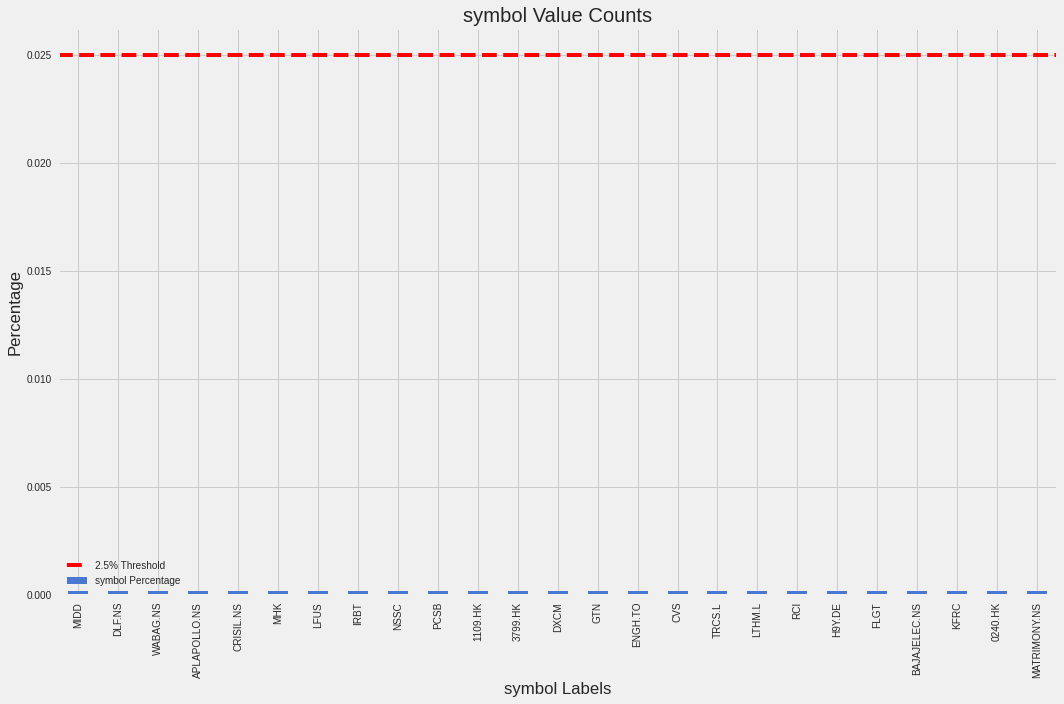

Column Name: revenue_per_share_ttm
Number of unique values: 3298
There are 1838 duplicates
There are 0 null values
0.19     12
0.22     11
1.46     11
0.03     10
0.04     10
         ..
19.23     1
88.41     1
16.32     1
20.85     1
5.0       1
Name: revenue_per_share_ttm, Length: 3298, dtype: int64


Descriptive Metrics: 
 count              5,136.0
mean    235.65574571651183
std     4,523.215009487597
min                    0.0
25%                  3.595
50%                  16.29
75%                56.2525
max             238,419.63
Name: revenue_per_share_ttm, dtype: float64


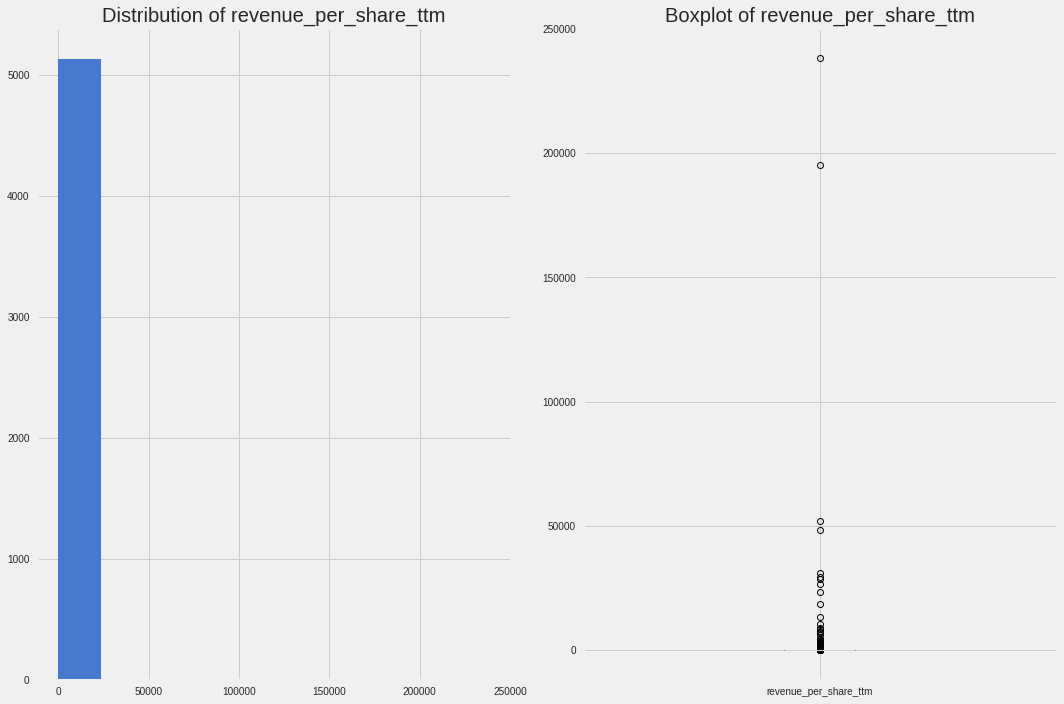



Column Name: pe_ratio_ttm
Number of unique values: 3575
There are 1561 duplicates
There are 0 null values
6.35     6
15.15    6
24.47    6
9.31     6
15.12    5
        ..
25.91    1
26.4     1
68.58    1
73.28    1
15.25    1
Name: pe_ratio_ttm, Length: 3575, dtype: int64


Descriptive Metrics: 
 count               5,136.0
mean      103.3914914330218
std     1,625.5292034866316
min                     0.0
25%                   12.07
50%                  21.915
75%      42.567499999999995
max               99,166.67
Name: pe_ratio_ttm, dtype: float64


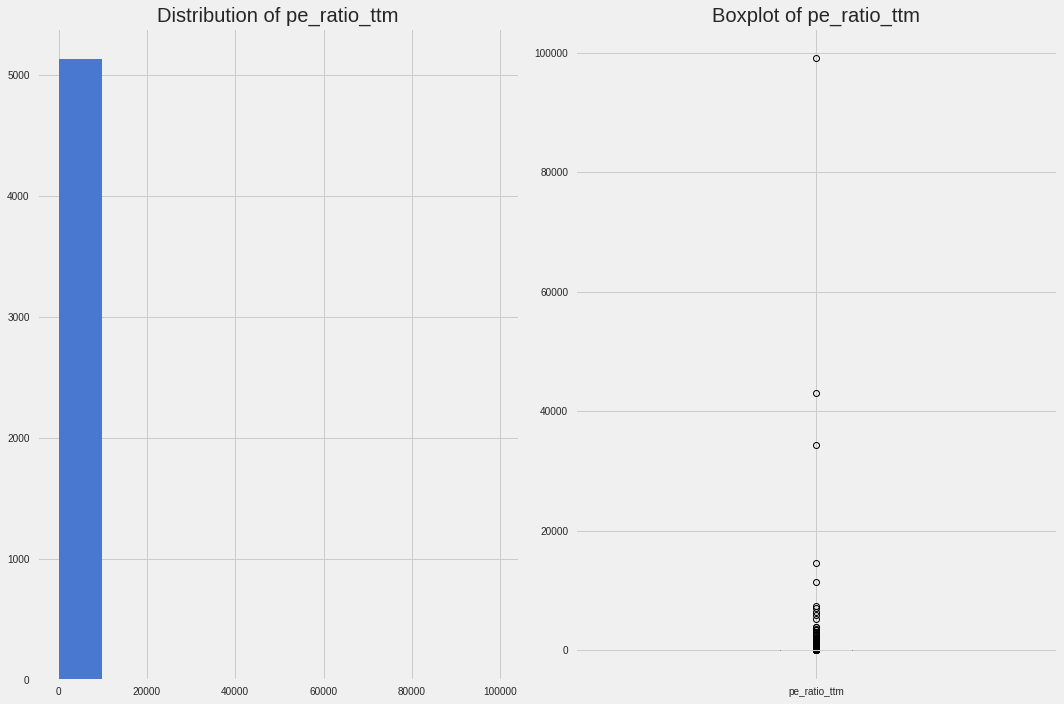



Column Name: market_cap_ttm
Number of unique values: 5129
There are 7 duplicates
There are 0 null values
11,635,200,000.0     2
12,885,193,350.04    2
240,000,000.0        2
1,656,000,000.0      2
520,000,000.0        2
                    ..
18,701,483,500.0     1
152,397,245.0        1
20,849,040,000.0     1
7,345,951,900.0      1
3,254,780,480.0      1
Name: market_cap_ttm, Length: 5129, dtype: int64


Descriptive Metrics: 
 count                  5,136.0
mean      112,491,321,438.1482
std     1,782,042,642,976.9038
min                  395,578.2
25%           597,231,859.9675
50%           3,179,756,659.16
75%           18,465,606,798.6
max     108,059,689,855,790.95
Name: market_cap_ttm, dtype: float64


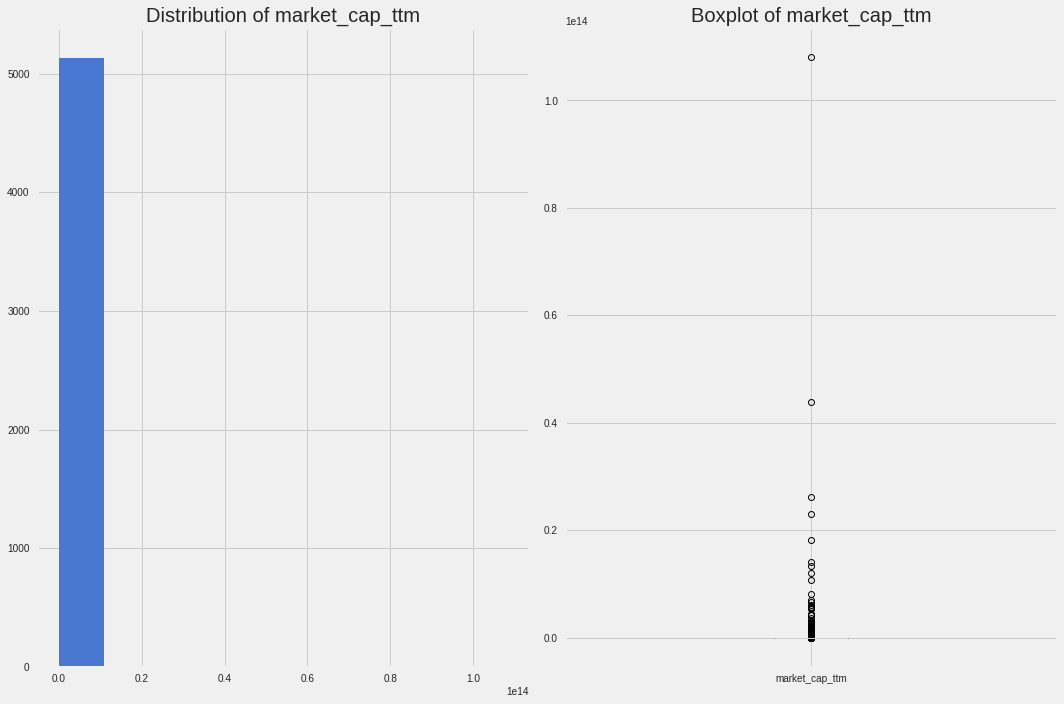



Column Name: ps_ratio_ttm
Number of unique values: 1368
There are 3768 duplicates
There are 0 null values
0.44     33
0.56     24
1.19     24
0.82     23
0.4      23
         ..
10.36     1
7.25      1
14.5      1
8.22      1
11.91     1
Name: ps_ratio_ttm, Length: 1368, dtype: int64


Descriptive Metrics: 
 count             5,136.0
mean    9.096849688473505
std     110.7720893911785
min                   0.0
25%                  0.97
50%                  2.29
75%     5.112500000000001
max              5,058.72
Name: ps_ratio_ttm, dtype: float64


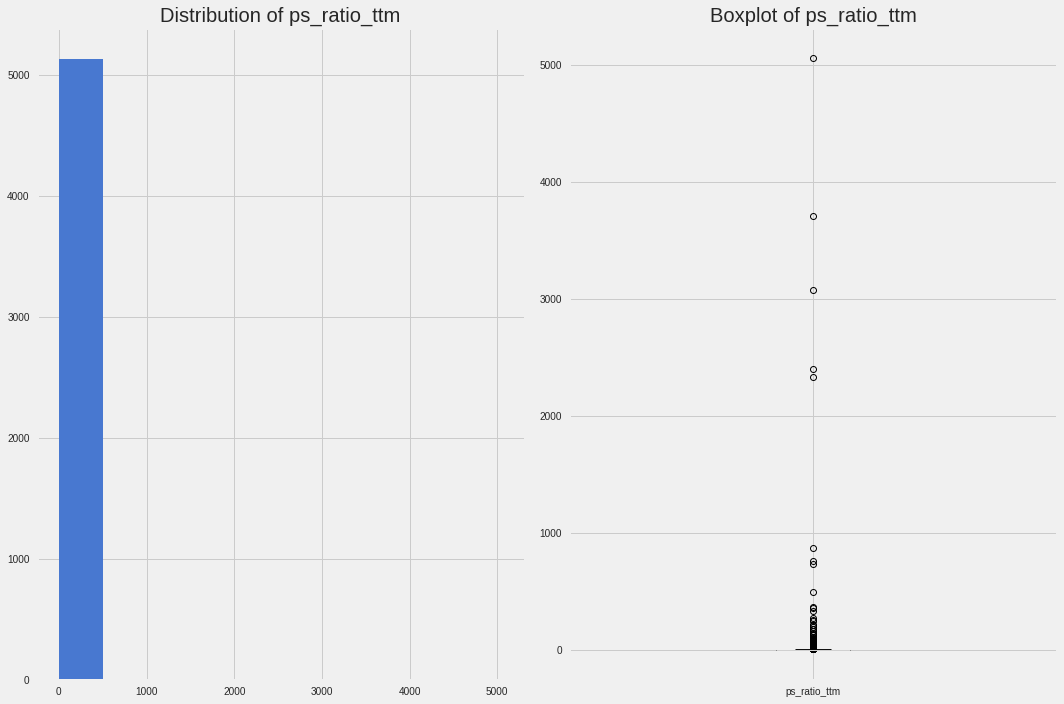



Column Name: ev_to_EBITDA_ttm
Number of unique values: 3034
There are 2102 duplicates
There are 0 null values
10.26     9
9.71      7
8.6       7
11.01     7
6.07      7
         ..
817.48    1
605.17    1
12.46     1
36.81     1
96.45     1
Name: ev_to_EBITDA_ttm, Length: 3034, dtype: int64


Descriptive Metrics: 
 count              5,136.0
mean    177.11159073208694
std     2,698.753750966844
min                    0.0
25%                   7.49
50%                  13.59
75%                  25.97
max             103,179.63
Name: ev_to_EBITDA_ttm, dtype: float64


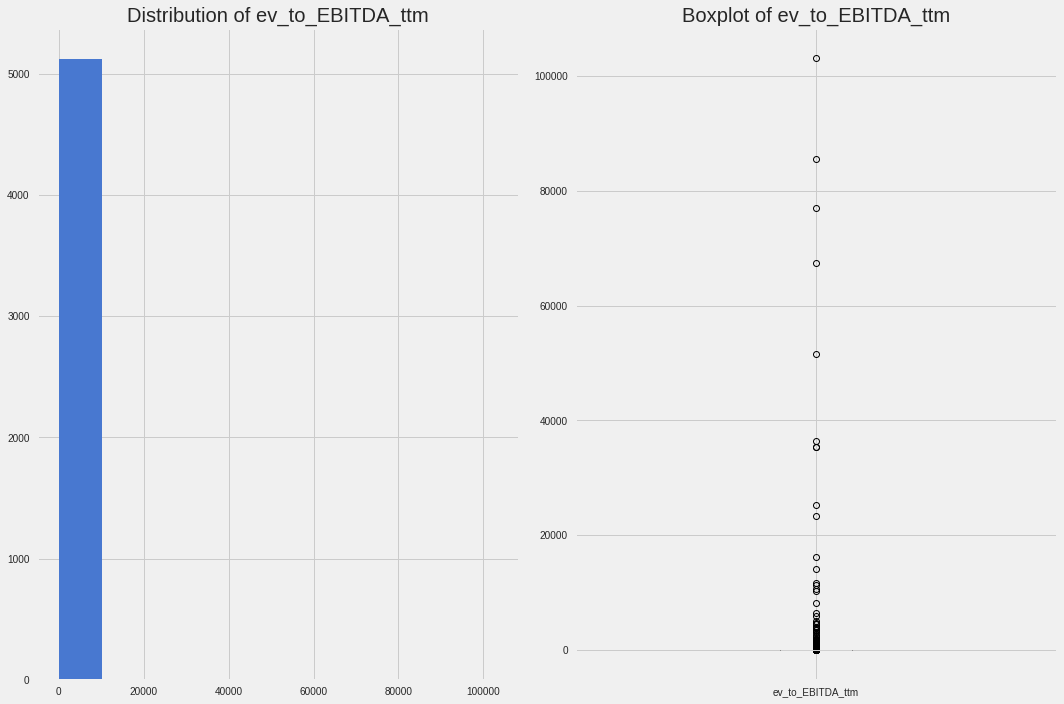



Column Name: ev_to_free_cashflow_ttm
Number of unique values: 3565
There are 1571 duplicates
There are 0 null values
5.64      7
4.17      6
10.07     6
11.48     6
15.32     6
         ..
100.15    1
12.45     1
22.37     1
72.41     1
2.75      1
Name: ev_to_free_cashflow_ttm, Length: 3565, dtype: int64


Descriptive Metrics: 
 count              5,136.0
mean     126.8311740654203
std      3,658.47280354364
min                    0.0
25%                  10.02
50%                 19.415
75%     38.822500000000005
max             259,473.11
Name: ev_to_free_cashflow_ttm, dtype: float64


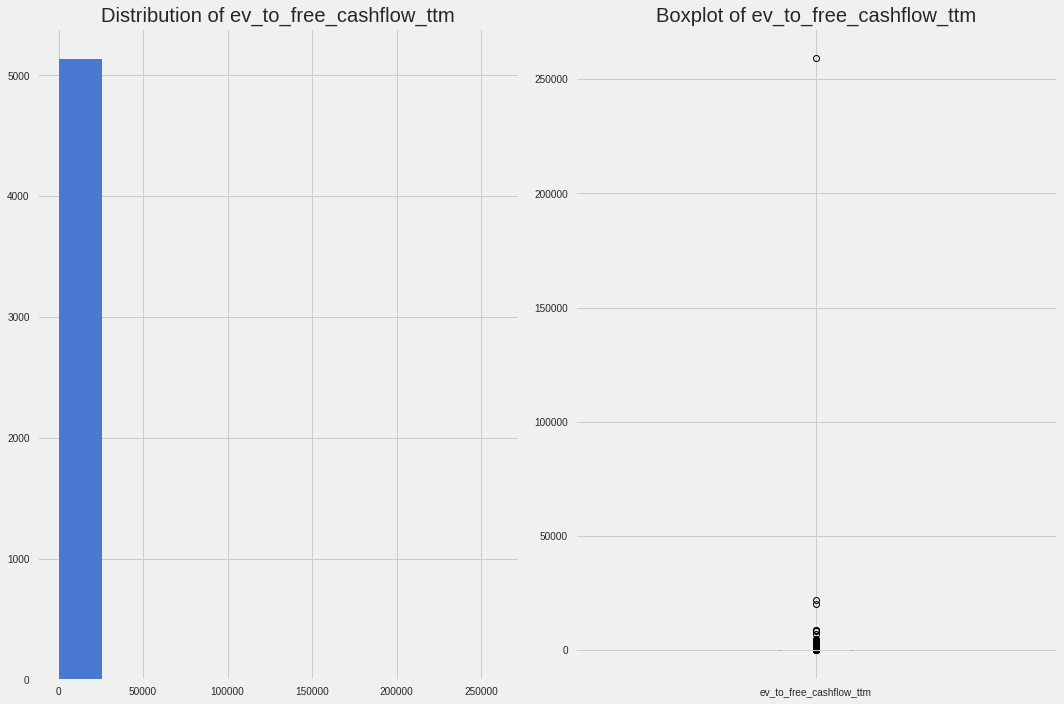



Column Name: ev_to_operating_cashflow_ttm
Number of unique values: 3012
There are 2124 duplicates
There are 0 null values
7.82      9
3.89      9
5.73      8
7.53      8
6.62      8
         ..
96.41     1
4.46      1
14.72     1
289.88    1
14.53     1
Name: ev_to_operating_cashflow_ttm, Length: 3012, dtype: int64


Descriptive Metrics: 
 count             5,136.0
mean    42.66743185358258
std     569.4955402154636
min                   0.0
25%                  7.38
50%                  13.4
75%                25.215
max             34,456.92
Name: ev_to_operating_cashflow_ttm, dtype: float64


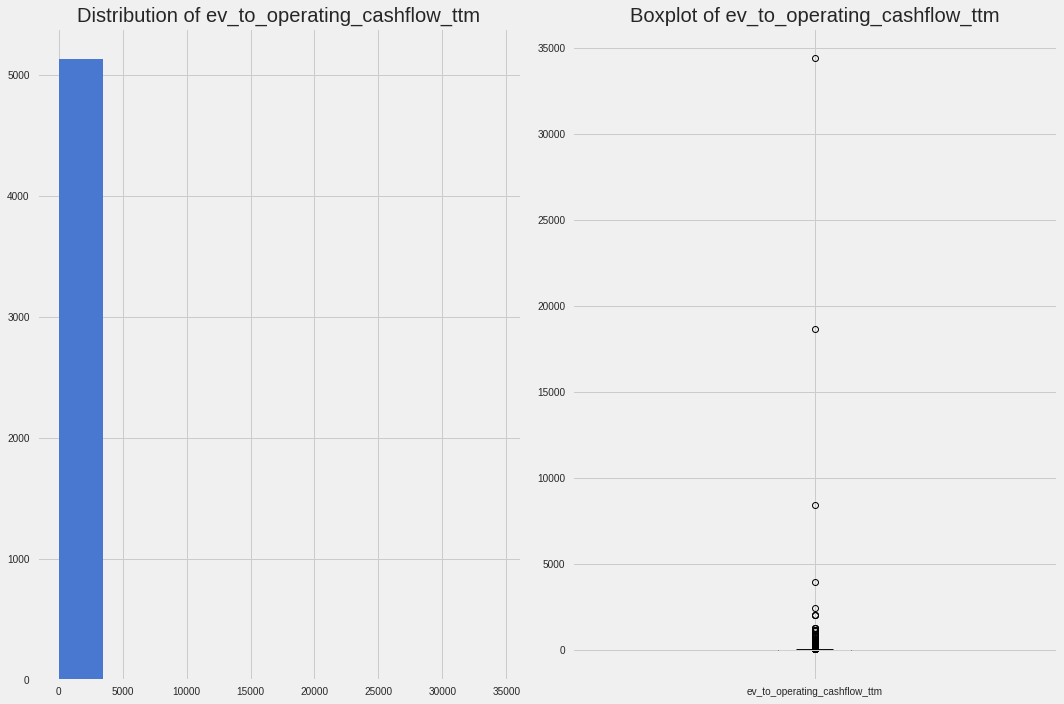



Column Name: stock_price
Number of unique values: 4137
There are 999 duplicates
There are 0 null values
0.05      10
0.15       9
0.07       6
0.12       6
0.91       6
          ..
9.55       1
116.68     1
35.56      1
108.06     1
40.01      1
Name: stock_price, Length: 4137, dtype: int64


Descriptive Metrics: 
 count              5,136.0
mean    389.77735591900284
std     6,182.852441453138
min                    0.0
25%                14.1075
50%                  45.03
75%                143.525
max              420,937.0
Name: stock_price, dtype: float64


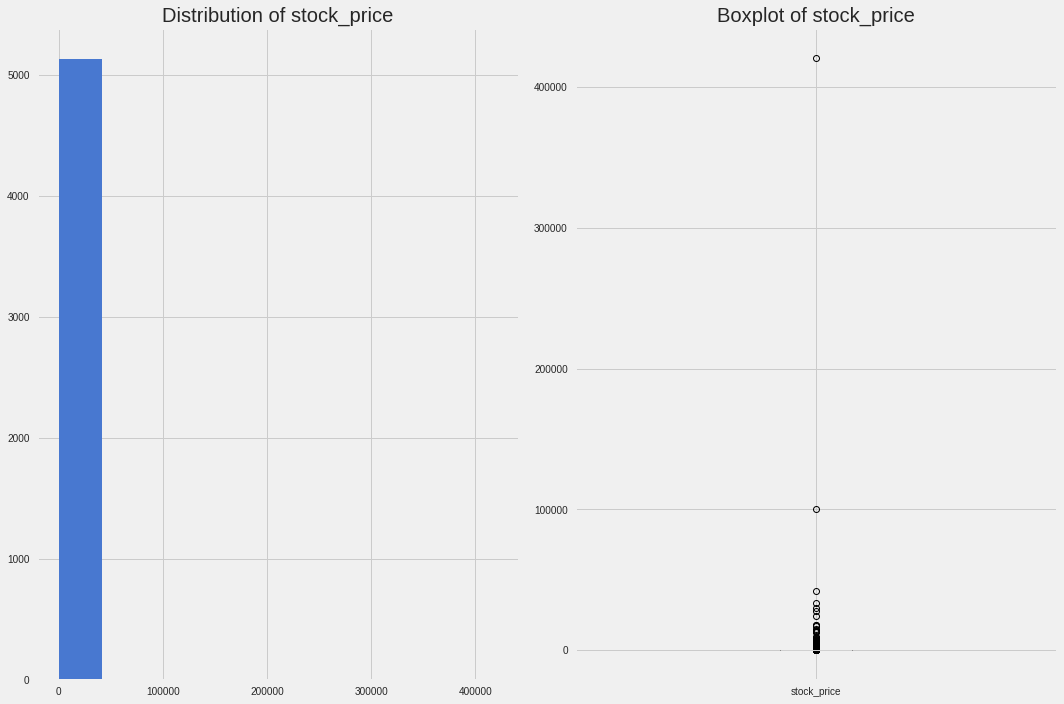



Column Name: FIP
Number of unique values: 86
There are 5049 duplicates
There are 8 null values
0.0      293
-0.02    284
0.02     276
-0.04    261
-0.01    214
        ... 
-0.35      1
0.55       1
-0.39      1
-0.6       1
-0.41      1
Name: FIP, Length: 87, dtype: int64


Descriptive Metrics: 
 count                5,128.0
mean    0.012985569422776896
std       0.1091969292817687
min                     -0.6
25%                    -0.05
50%                      0.0
75%                     0.07
max                     0.55
Name: FIP, dtype: float64


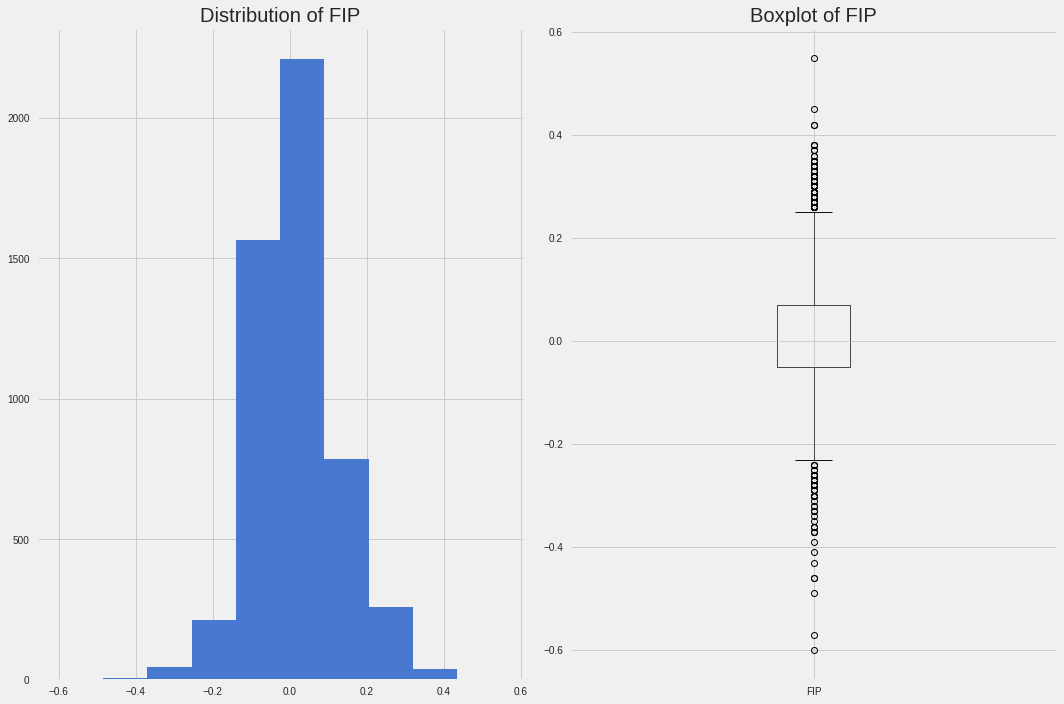



Column Name: company_name
Number of unique values: 4802
There are 334 duplicates
There are 0 null values
Compagnie de Saint-Gobain S.A.    4
Eli Lilly and Company             3
Unilever PLC                      3
Caterpillar Inc.                  3
STMicroelectronics N.V.           3
                                 ..
Serma Group Société anonyme       1
PRA Health Sciences, Inc.         1
USA Truck, Inc.                   1
Telecom Italia S.p.A.             1
B&M European Value Retail S.A.    1
Name: company_name, Length: 4802, dtype: int64


Descriptive Metrics: 
 count                               5136
unique                              4802
top       Compagnie de Saint-Gobain S.A.
freq                                   4
Name: company_name, dtype: object


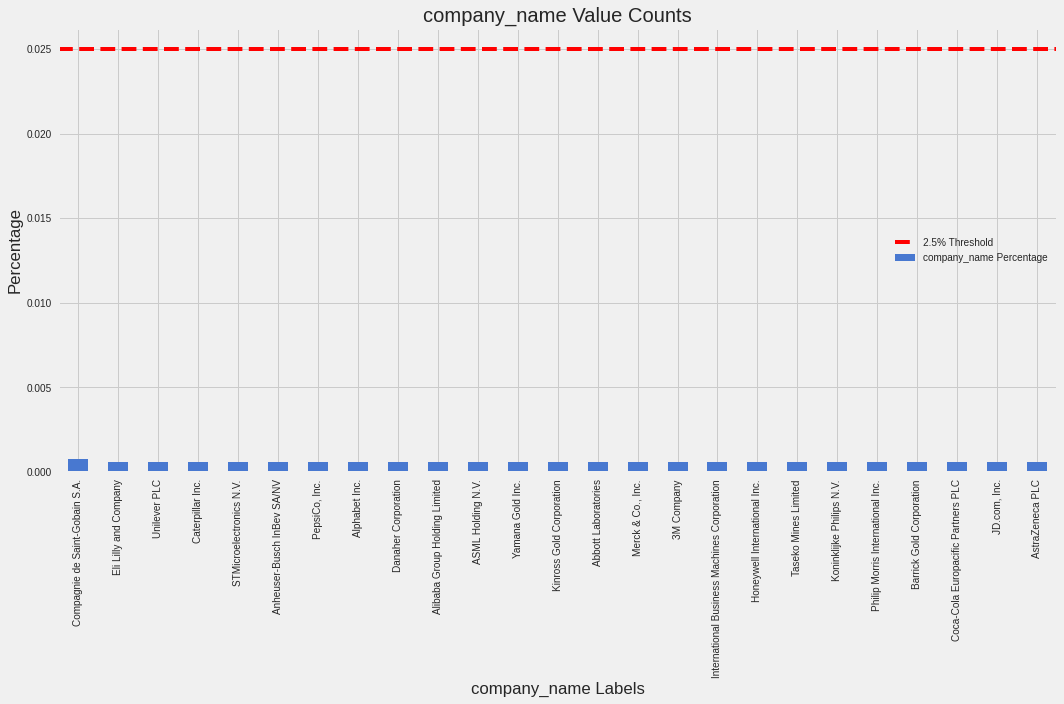

Column Name: exchange_short_name
Number of unique values: 15
There are 5121 duplicates
There are 0 null values
NYSE           1118
NASDAQ         1037
NSE             664
HKSE            648
XETRA           419
EURONEXT        332
LSE             316
TSX             259
SIX              92
MUTUAL_FUND      73
MCX              62
OSE              54
AMEX             51
ETF              10
ASE               1
Name: exchange_short_name, dtype: int64


Descriptive Metrics: 
 count     5136
unique      15
top       NYSE
freq      1118
Name: exchange_short_name, dtype: object


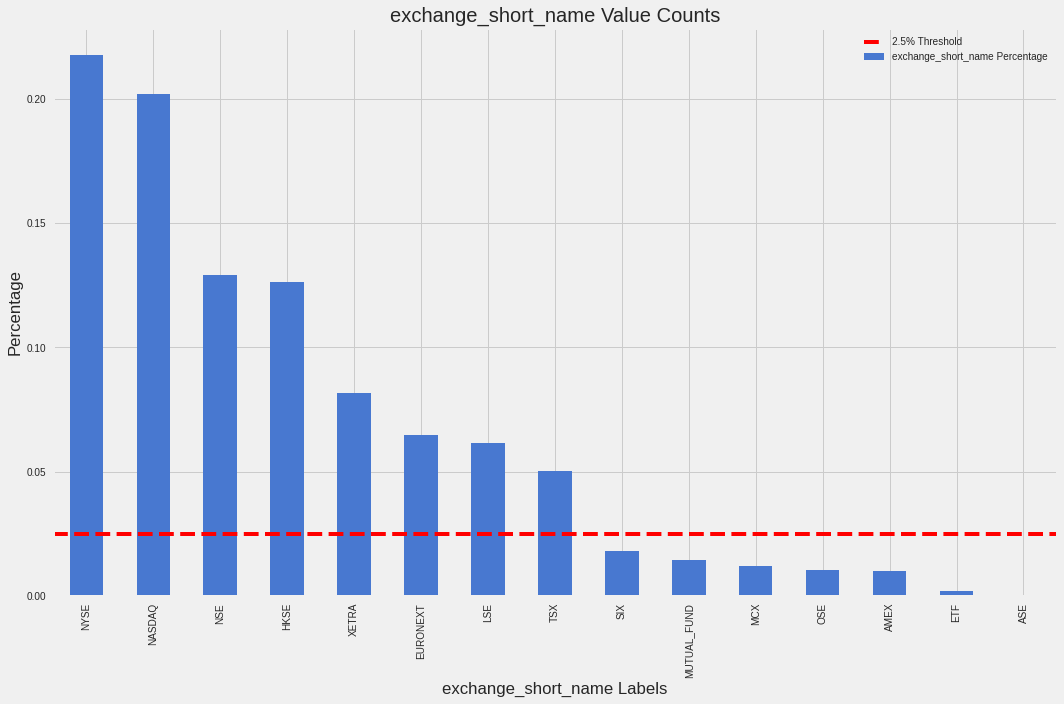

Column Name: industry
Number of unique values: 177
There are 4958 duplicates
There are 58 null values
Banks—Regional                                    230
Asset Management                                  180
Software—Application                              143
Specialty Industrial Machinery                    136
Information Technology Services                   119
                                                 ... 
Utilities                                           1
Insurance                                           1
Property Management                                 1
Pharmaceuticals, Biotechnology & Life Sciences      1
Retail Apparel & Specialty                          1
Name: industry, Length: 178, dtype: int64


Descriptive Metrics: 
 count               5078
unique               177
top       Banks—Regional
freq                 230
Name: industry, dtype: object


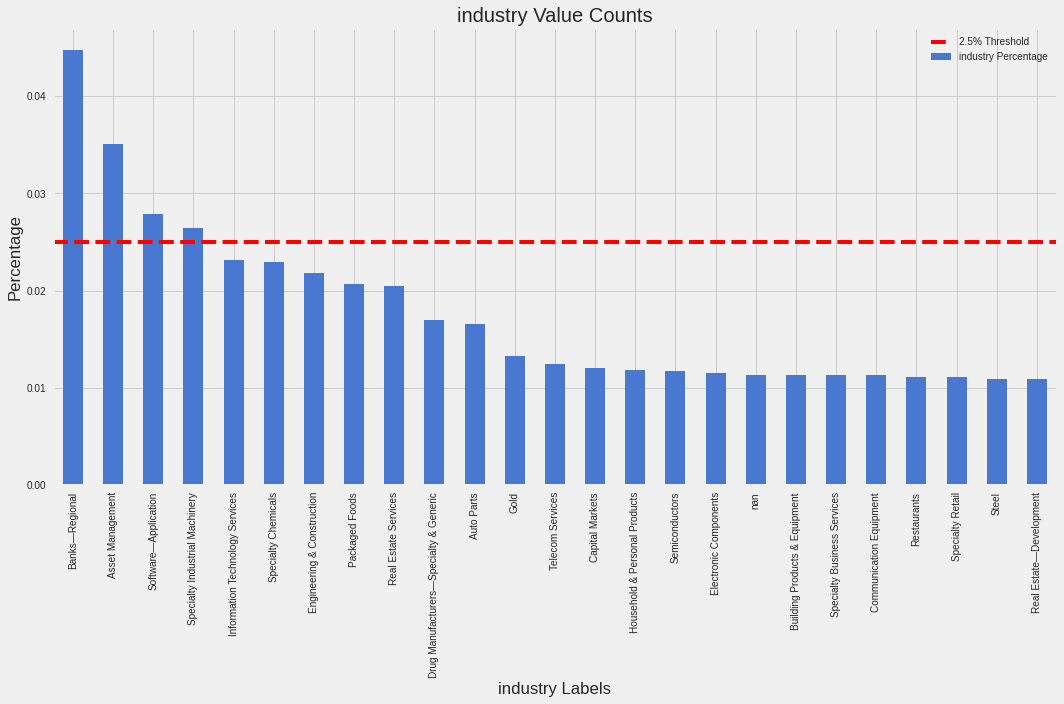

Column Name: sector
Number of unique values: 48
There are 5087 duplicates
There are 68 null values
Financial Services                  621
Technology                          545
Industrials                         502
Consumer Cyclical                   387
Real Estate                         367
Healthcare                          327
Basic Materials                     238
Consumer Defensive                  191
Communication Services              157
Energy                              135
Utilities                           120
Chemicals                           119
Construction                        104
Electrical Equipment                 90
Machinery                            87
Retail                               85
Metals & Mining                      85
Textiles, Apparel & Luxury Goods     82
Food Products                        81
Media                                80
Pharmaceuticals                      78
NaN                                  68
Consumer products    

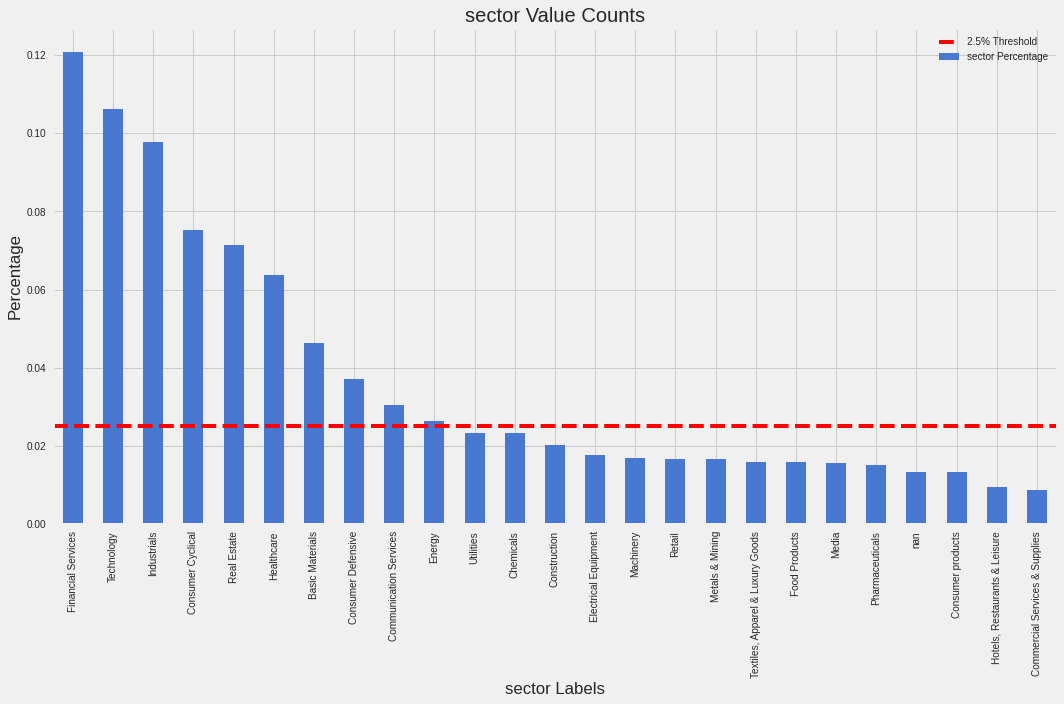

Column Name: country
Number of unique values: 61
There are 5075 duplicates
There are 0 null values
US      2167
IN       669
HK       347
CN       321
CA       319
        ... 
IS         1
VG         1
Peru       1
TR         1
PA         1
Name: country, Length: 61, dtype: int64


Descriptive Metrics: 
 count     5136
unique      61
top         US
freq      2167
Name: country, dtype: object


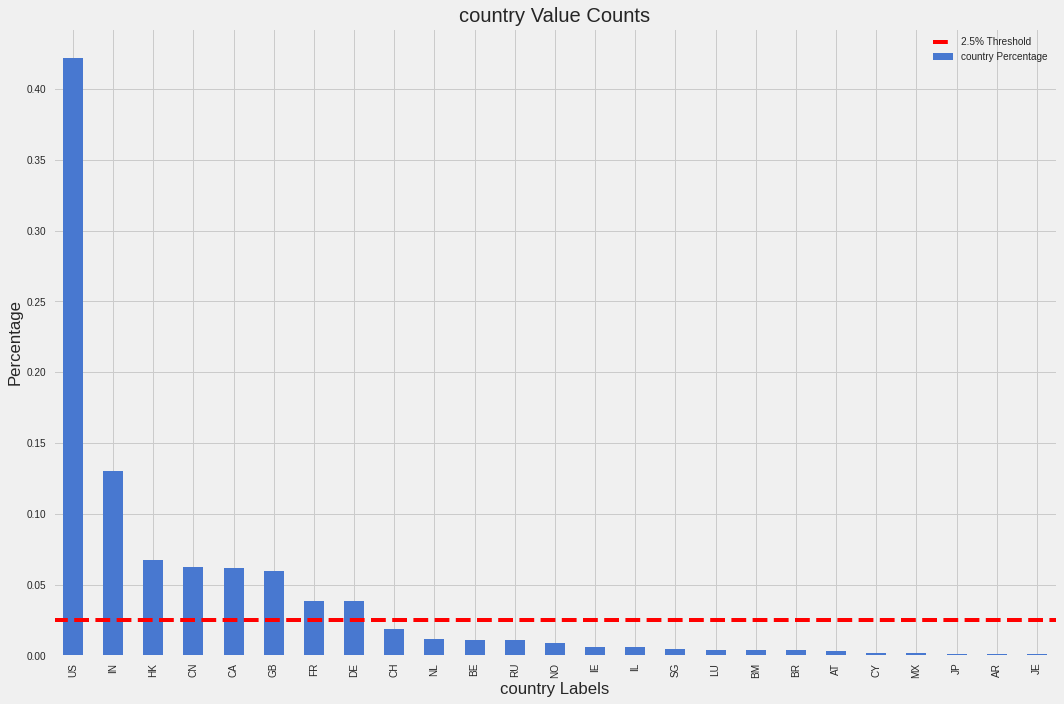

Column Name: full_time_employees
Number of unique values: 2777
There are 2358 duplicates
There are 201 null values
nan        201
0.0         59
2,000.0     18
3,000.0     15
9,000.0     13
          ... 
2,594.0      1
894.0        1
1,066.0      1
954.0        1
5,589.0      1
Name: full_time_employees, Length: 2778, dtype: int64


Descriptive Metrics: 
 count               4,935.0
mean    17,818.805268490374
std      71,797.94127736248
min                     0.0
25%                   460.0
50%                 2,100.0
75%                 9,400.0
max             2,200,000.0
Name: full_time_employees, dtype: float64


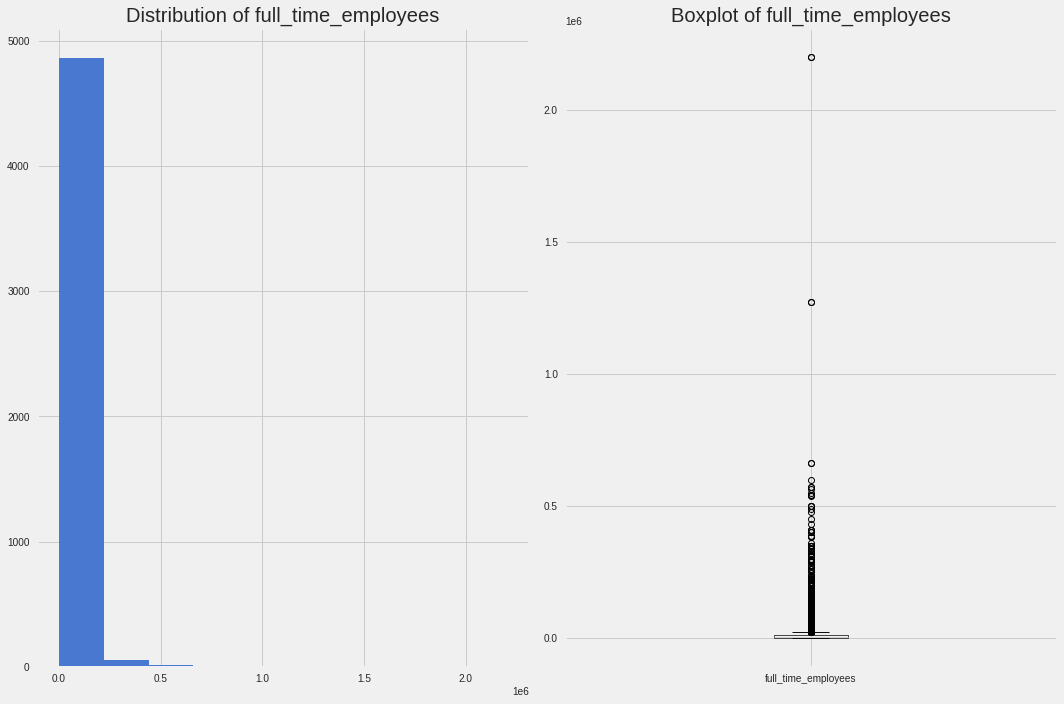



Column Name: state
Number of unique values: 318
There are 4817 duplicates
There are 911 null values
NaN                    911
CALIFORNIA             282
MAHARASHTRA            232
NEW YORK               173
TEXAS                  171
                      ... 
LIPETSKAYA OBLAST        1
RI                       1
MAGADANSKAYA OBLAST      1
NOTTINGHAMSHIRE          1
POWYS                    1
Name: state, Length: 319, dtype: int64


Descriptive Metrics: 
 count           4225
unique           318
top       CALIFORNIA
freq             282
Name: state, dtype: object


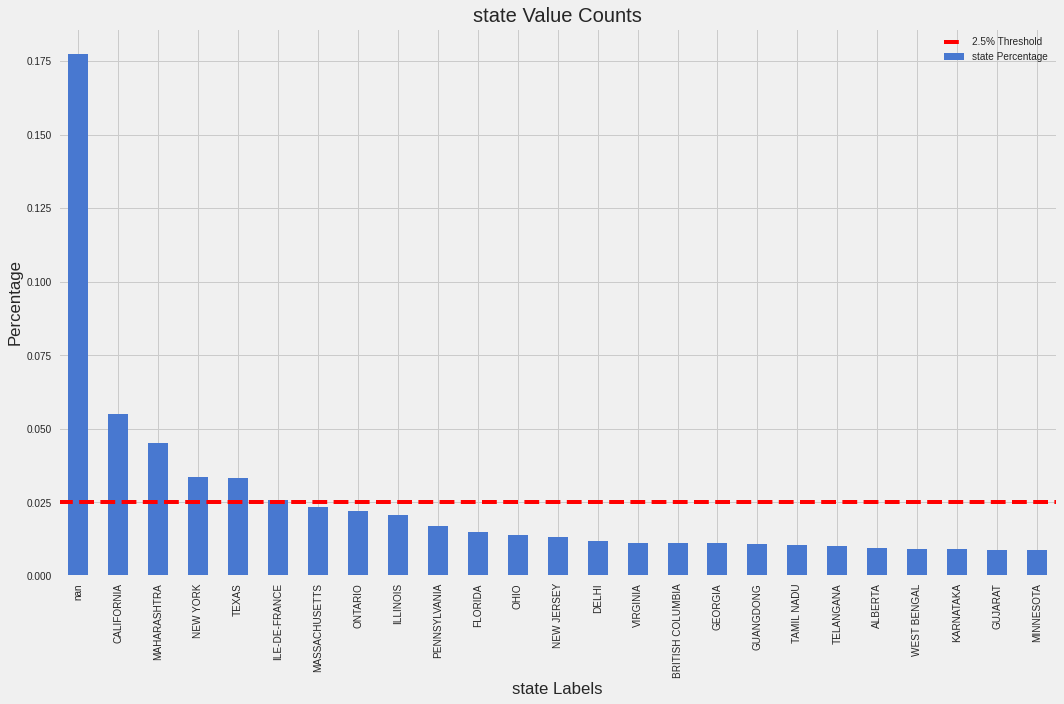

Column Name: rd_spend
Number of unique values: 849
There are 4287 duplicates
There are 0 null values
0.0                 4125
93,000,000.0           4
6,333,000,000.0        3
27,573,000,000.0       3
6,085,700,000.0        3
                    ... 
11,483,000.0           1
7,773,000.0            1
12,662,000.0           1
827,129,000.0          1
55,300,000.0           1
Name: rd_spend, Length: 849, dtype: int64


Descriptive Metrics: 
 count                 5,136.0
mean      663,916,287.9613844
std     13,902,032,416.717821
min          -1,348,000,000.0
25%                       0.0
50%                       0.0
75%                       0.0
max         738,894,000,000.0
Name: rd_spend, dtype: float64


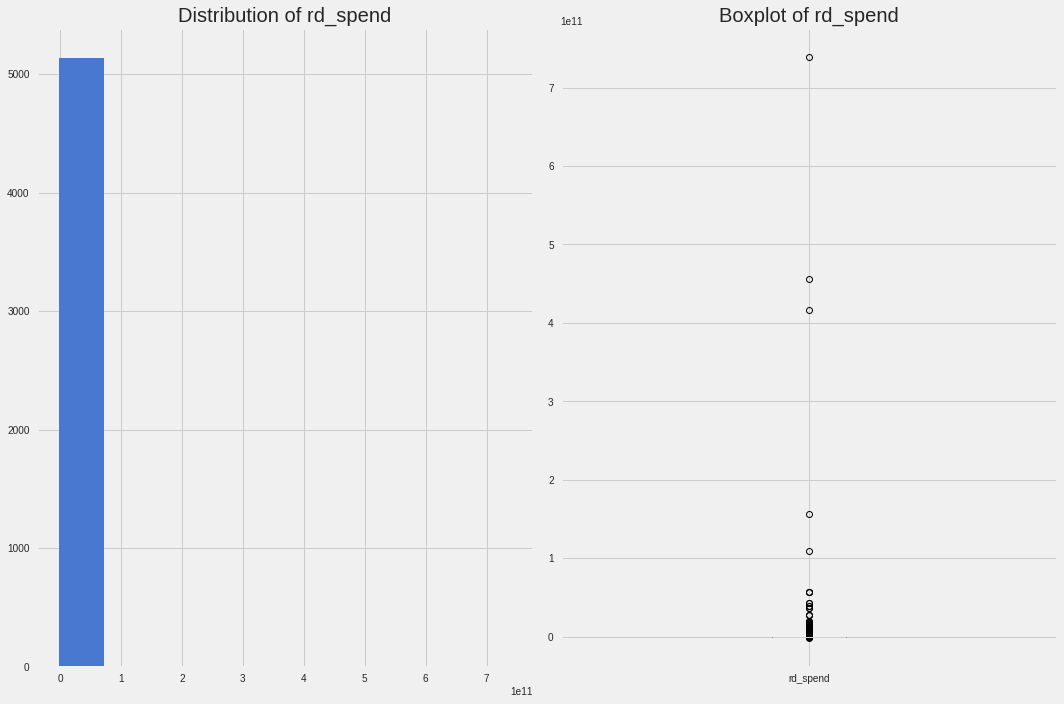



Column Name: enterprise_value
Number of unique values: 5135
There are 1 duplicates
There are 0 null values
10,366,416,000.0     2
872,771,702.14       1
36,145,134,445.75    1
744,344,871.34       1
1,744,589,940.0      1
                    ..
6,285,387,560.0      1
420,719,773.35       1
14,986,779,660.0     1
8,298,700,930.0      1
22,280,205,624.0     1
Name: enterprise_value, Length: 5135, dtype: int64


Descriptive Metrics: 
 count                  5,136.0
mean      97,151,751,349.97238
std     1,043,432,529,317.3489
min         -435,110,335,179.6
25%           694,404,746.9325
50%          4,148,663,898.415
75%      23,166,117,204.732502
max      47,887,383,883,097.04
Name: enterprise_value, dtype: float64


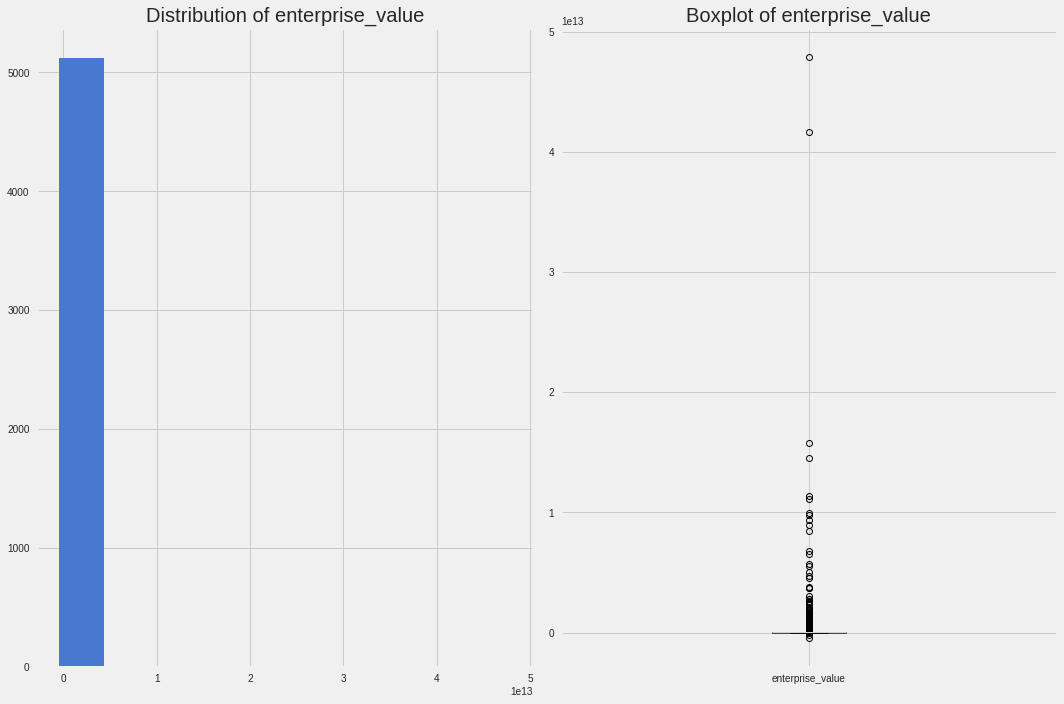



Column Name: ebitda
Number of unique values: 4619
There are 517 duplicates
There are 0 null values
0.0                 153
767,000,000.0         4
2,838,000,000.0       4
3,807,000,000.0       3
30,593,000,000.0      3
                   ... 
1,520,843,000.0       1
20,843,810,000.0      1
5,210,942,000.0       1
81,836,000.0          1
1,834,000,000.0       1
Name: ebitda, Length: 4619, dtype: int64


Descriptive Metrics: 
 count                 5,136.0
mean    12,060,597,253.405445
std     270,152,757,458.44336
min          -6,106,138,000.0
25%              42,394,500.0
50%             249,746,000.0
75%           1,294,000,000.0
max      16,596,000,000,000.0
Name: ebitda, dtype: float64


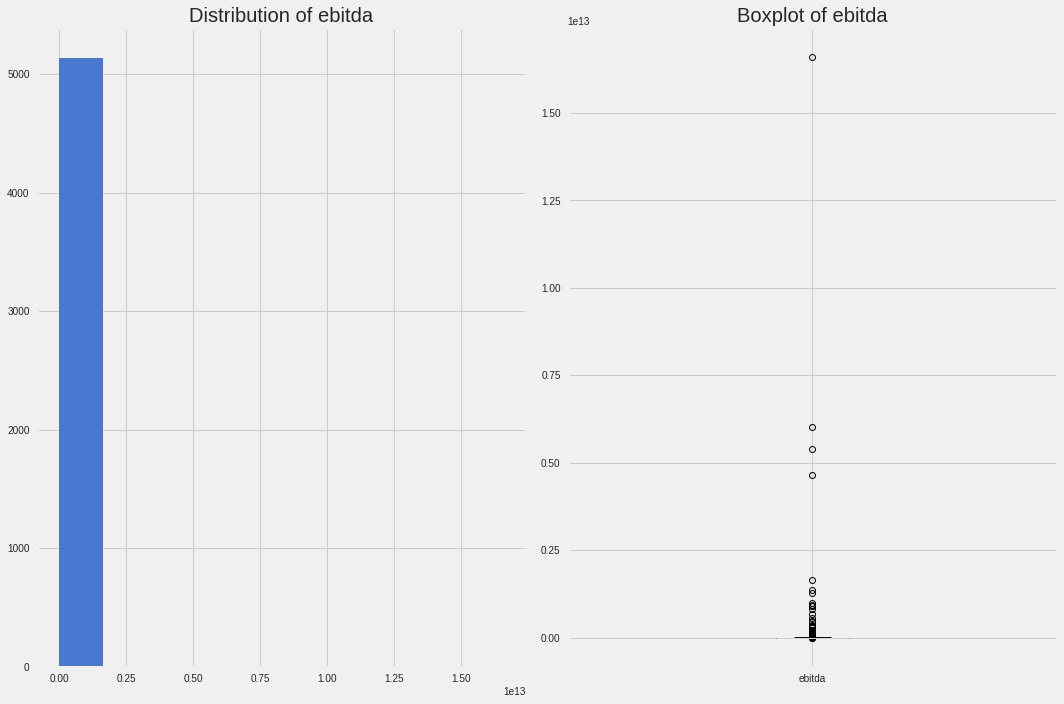



Column Name: sales
Number of unique values: 4728
There are 408 duplicates
There are 0 null values
0.0                  17
38,128,000,000.0      4
8,530,000,000.0       4
13,978,500,000.0      4
717,289,000,000.0     3
                     ..
10,423,000,000.0      1
28,746,000.0          1
4,607,503,000.0       1
14,504,000.0          1
274,739,000.0         1
Name: sales, Length: 4728, dtype: int64


Descriptive Metrics: 
 count                  5,136.0
mean      62,902,565,188.49147
std     1,192,847,142,731.7578
min             -329,895,922.0
25%              264,291,000.0
50%            1,458,843,000.0
75%            7,930,563,750.0
max       57,792,796,000,000.0
Name: sales, dtype: float64


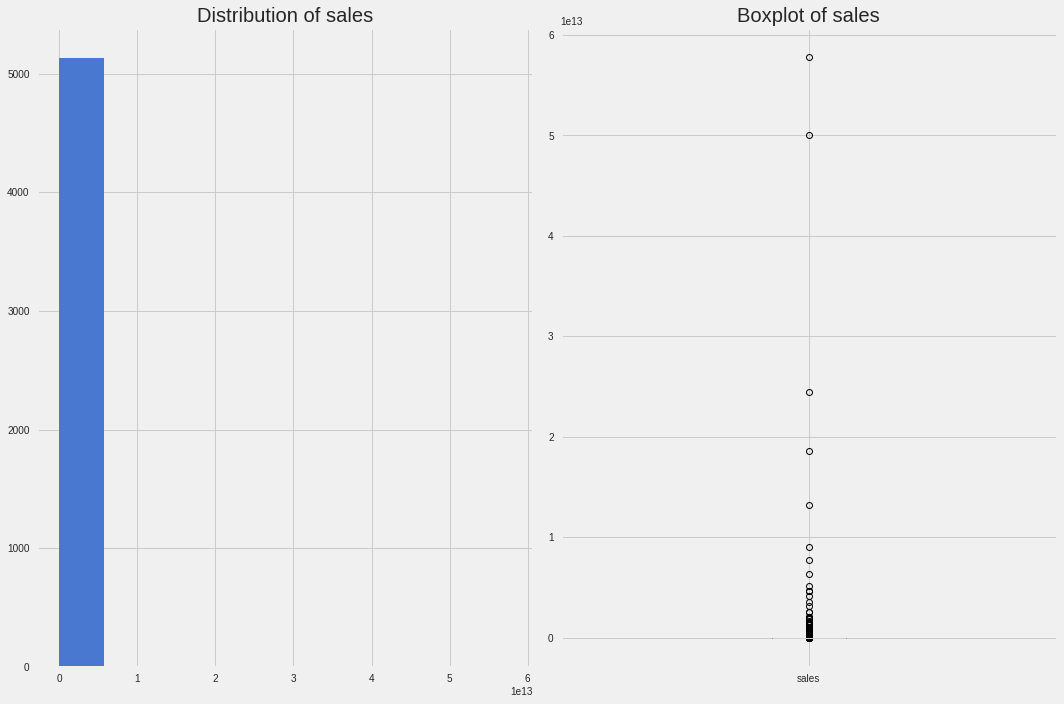



Column Name: earnings
Number of unique values: 4705
There are 431 duplicates
There are 0 null values
0.0                10
456,000,000.0       6
171,100,000.0       4
1,187,000,000.0     4
4,495,000,000.0     4
                   ..
775,000.0           1
123,361,000.0       1
903,000,000.0       1
10,527,014.86       1
52,168,000.0        1
Name: earnings, Length: 4705, dtype: int64


Descriptive Metrics: 
 count                5,136.0
mean    4,022,476,748.623021
std     53,998,835,590.79331
min        -50,860,000,000.0
25%             12,724,250.0
50%             98,786,500.0
75%            618,369,750.0
max      2,218,000,000,000.0
Name: earnings, dtype: float64


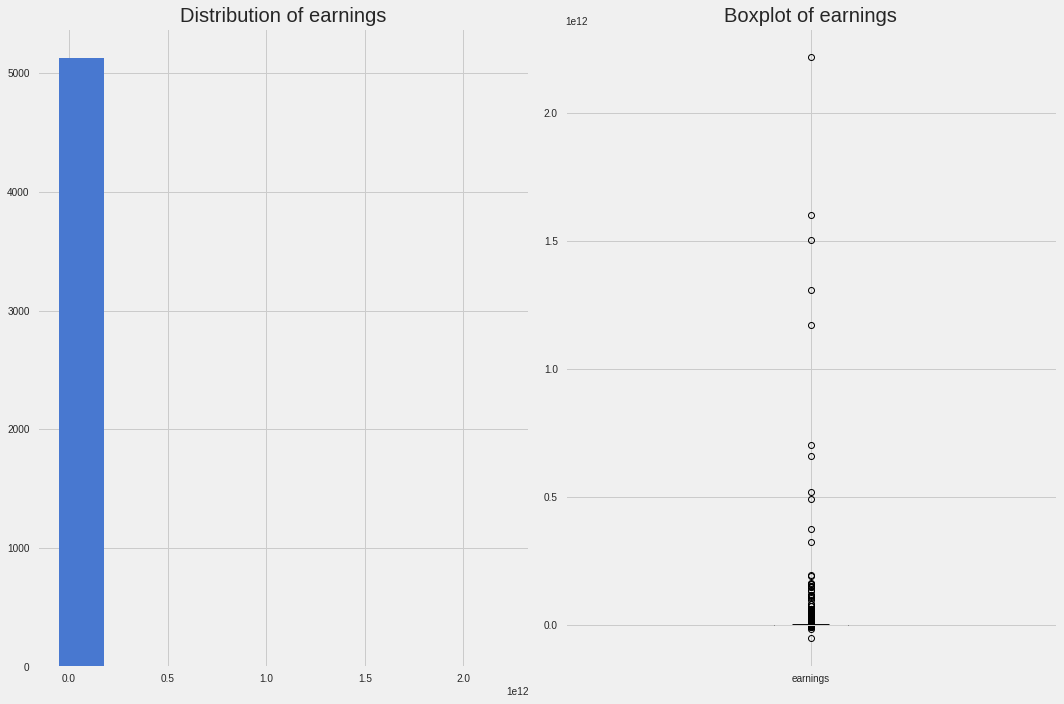



Column Name: free_cashflow
Number of unique values: 4691
There are 445 duplicates
There are 0 null values
0.0                30
1,960,000,000.0     4
3,475,000,000.0     4
38,000,000.0        4
6,373,000,000.0     3
                   ..
-3,854,006.38       1
88,757,000.0        1
261,400,000.0       1
194,290,935.0       1
1,295,000,000.0     1
Name: free_cashflow, Length: 4691, dtype: int64


Descriptive Metrics: 
 count                5,136.0
mean    5,281,717,056.646611
std     100,874,314,344.7243
min     -1,930,157,000,000.0
25%             23,327,827.5
50%            153,521,000.0
75%            828,000,000.0
max      5,188,150,000,000.0
Name: free_cashflow, dtype: float64


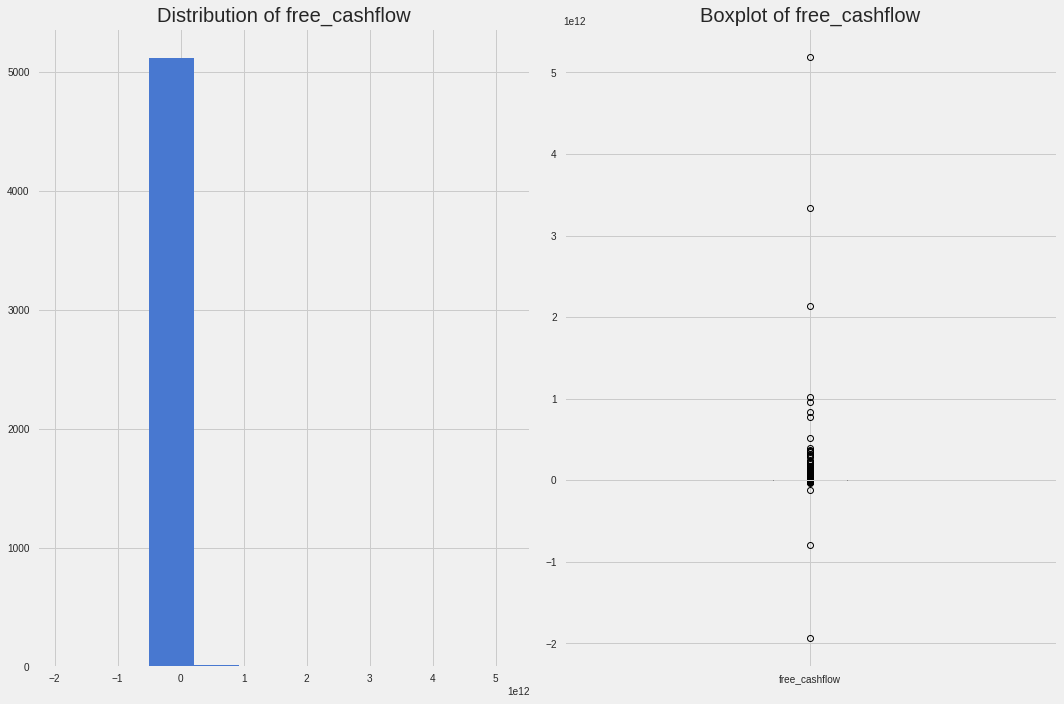



Column Name: operating_cashflow
Number of unique values: 4678
There are 458 duplicates
There are 0 null values
0.0                39
6,208,000,000.0     6
1,204,500,000.0     5
1,080,000,000.0     4
4,711,000,000.0     4
                   ..
489,289,000.0       1
5,241,000.0         1
584,308,000.0       1
195,100,000.0       1
259,000,000.0       1
Name: operating_cashflow, Length: 4678, dtype: int64


Descriptive Metrics: 
 count                 5,136.0
mean    12,079,652,127.726244
std     218,198,204,104.53265
min        -120,008,000,000.0
25%              41,365,000.0
50%             233,462,500.0
75%           1,201,642,500.0
max       9,186,704,000,000.0
Name: operating_cashflow, dtype: float64


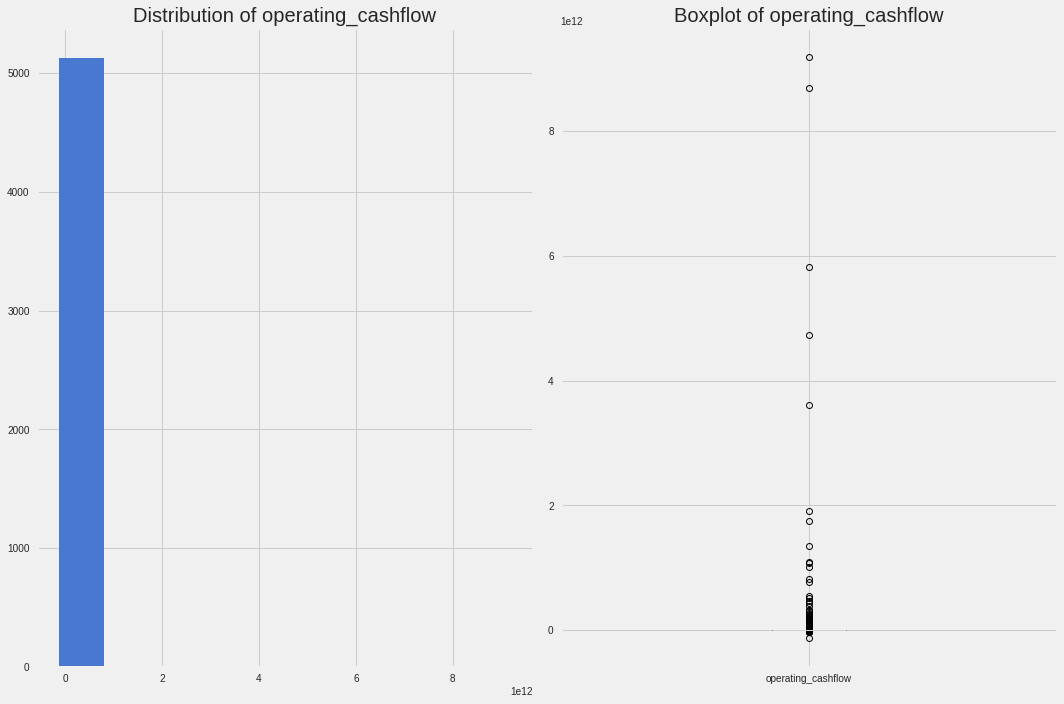

In [468]:
#eval features in df except percent_change which has infinity values and will
#cause errors
col_eval(df_clean.drop(columns='percent_change'))

> **OBSERVATIONS**
> - Outliers on the high end of the key metrics may be due to bad data
> - Null values
> - `exchange_short_name` has rare labels which should be consolidated
> - `industry` has rare labels which should be consolidated
> - `sector` has rare labels which should be consolidated
> - `country` has rare labels which should be consolidated
> - `state` has rare labels which should be consolidated
> - `percent_change` has some infinity values in it that need to be removed

> **ACTIONS**
> - remove `percent_change` infinity values
> - Rare label encode `exchange_short_name`, `industry`, `sector`, `country` and `state`
> - impute null values


## Remove Rows

In [469]:
#convert infinity values to nulls in percent_change
df_clean['percent_change'].replace(np.inf,np.nan, inplace=True)

In [470]:
df_clean.shape

(5136, 25)

In [471]:
# #find sectors to eliminate
# df_clean.loc[df_clean['sector'].str.contains('mort', case=False),['sector']].value_counts()

In [472]:
#remove sectors
sector_list = ['Financial Services','Biotechnology','Construction','Professional_Services']

for sector in sector_list:
  df_clean = df_clean.loc[df_clean['sector'] != sector]

In [473]:
#dataframe shape after
df_clean.shape

(4400, 25)

In [474]:
#remove industries
industry_list = ['Banks-Regional','Banks-Diversified','Banks','Foreign Money Center Banks',
                 'Biotechnology','Pharmaceuticals, Biotechnology & Life Sciences',
                'Diversified Financials','Financial Conglomerates','Financial Data & Stock Exchanges',
                 'Residential Construction','Commercial and Professional Services','Capital Goods']

for industry in industry_list:
  df_clean = df_clean.loc[df_clean['industry'] != industry]

In [475]:
#dataframe shape after
df_clean.shape

(4320, 25)

## Duplicates

Duplicate stock values based on the stock `symbol` will be eliminated.

In [476]:
#check for duplicates in symbol
df_clean['symbol'].duplicated().sum()

0

## Null Values

### Remove Null Values

I am going to remove any stocks which have null values for any of the key performance metrics:
- `pe_ratio_ttm`
- `ev_to_operating_cashflow_ttm`
- `enterprise_value_over_EBITDA_ttm`
- `ev_to_free_cashflow_ttm`
- `ps_ratio_ttm`
- `market_cap_ttm`



In [477]:
#establish performance metrics
performance_metrics_cols = ['revenue_per_share_ttm','pe_ratio_ttm','market_cap_ttm',
                            'ps_ratio_ttm','ev_to_EBITDA_ttm',
                            'ev_to_free_cashflow_ttm', 'ev_to_operating_cashflow_ttm']

In [478]:
#check for nulls
df_clean.isna().sum()

symbol                            0
revenue_per_share_ttm             0
pe_ratio_ttm                      0
market_cap_ttm                    0
ps_ratio_ttm                      0
ev_to_EBITDA_ttm                  0
ev_to_free_cashflow_ttm           0
ev_to_operating_cashflow_ttm      0
stock_price                       0
percent_change                    1
FIP                               8
company_name                      0
exchange_short_name               0
industry                         58
sector                           68
country                           0
full_time_employees             126
state                           806
rd_spend                          0
enterprise_value                  0
ebitda                            0
sales                             0
earnings                          0
free_cashflow                     0
operating_cashflow                0
dtype: int64

> **OBSERVATIONS**
> - remove nulls for `FIP`
> - remove nulls for `percent_change`
> - `industry`, `sector` and `state` need to be imputed with Unknown
> - `full_time_employees` will need to be imputed with -999

> **ACTIONS**
> - impute `industry`, `sector` and `state` with Unknown
> - impute `full_time_employees` with -999

In [479]:
#remove FIP nulls
df_clean.drop(df_clean.loc[df_clean['FIP'].isna(),'FIP'].index, inplace=True)

In [480]:
#remove percent_change nulls
df_clean.drop(df_clean.loc[df_clean['percent_change'].isna(),'percent_change'].index, inplace=True)

In [481]:
#recheck nulls
df_clean.isna().sum()

symbol                            0
revenue_per_share_ttm             0
pe_ratio_ttm                      0
market_cap_ttm                    0
ps_ratio_ttm                      0
ev_to_EBITDA_ttm                  0
ev_to_free_cashflow_ttm           0
ev_to_operating_cashflow_ttm      0
stock_price                       0
percent_change                    0
FIP                               0
company_name                      0
exchange_short_name               0
industry                         58
sector                           68
country                           0
full_time_employees             126
state                           803
rd_spend                          0
enterprise_value                  0
ebitda                            0
sales                             0
earnings                          0
free_cashflow                     0
operating_cashflow                0
dtype: int64

### Null Value Imputation

I am going to impute the remaining null values with placeholder values.

In [482]:
#impute cat labels with Unknown
cat_impute = ['industry','sector','state']

for col in cat_impute:
  df_clean.loc[df_clean[col].isna(),[col]] = 'Unknown'

In [483]:
#impute full_time_employees with -999
df_clean.loc[df_clean['full_time_employees'].isna(),['full_time_employees']] = -999

In [484]:
#recheck nulls
df_clean.isna().sum()

symbol                          0
revenue_per_share_ttm           0
pe_ratio_ttm                    0
market_cap_ttm                  0
ps_ratio_ttm                    0
ev_to_EBITDA_ttm                0
ev_to_free_cashflow_ttm         0
ev_to_operating_cashflow_ttm    0
stock_price                     0
percent_change                  0
FIP                             0
company_name                    0
exchange_short_name             0
industry                        0
sector                          0
country                         0
full_time_employees             0
state                           0
rd_spend                        0
enterprise_value                0
ebitda                          0
sales                           0
earnings                        0
free_cashflow                   0
operating_cashflow              0
dtype: int64

## Feature Engineering

I will create important new features which will help in modeling and analyzing the data.

### Stock Owned Marker

In order to keep track of performance of already purchased stocks in HIT's portfolio, I will add a feature named `owned` which will be categorical with a label of "yes" if a particular stock is owned and "no" if it is not.

In [485]:
#owned stocks list
owned_stocks = ['CXW','HAPP','SCPL','TAYD','CANG','ADCOF','ATGN','CXDO','NEPH',
              'SMTI','TNYYF','SOWG','SMLR']

In [486]:
#create new feature and fill in
df_clean['owned'] = None
df_clean.loc[df_clean['symbol'].isin(owned_stocks), 'owned'] = 'yes'
df_clean.loc[~df_clean['symbol'].isin(owned_stocks), 'owned'] = 'no'

In [487]:
#check value counts of new feature
df_clean['owned'].value_counts(dropna=False)

no     4306
yes       5
Name: owned, dtype: int64

### Market Cap Grouping

The market cap represents how large a company is and can be helpful for this analysis. I will subdivide each stock by its market cap with the following breakdown:
- **Micro-Cap**: Less than \$300M
- **Small-Cap**: Between \$300M and \$2B
- **Mid-Cap**: Between \$2B and \$10B
- **Large-Cap**: Between \$10B and \$200B
- **Mega-Cap**: Greater than \$200B

In [488]:
#create market cap grouping
df_clean['market_cap_group'] = None

In [489]:
#fill in market_cap_group based on market_cap value
df_clean.loc[df_clean['market_cap_ttm'] > 200_000_000_000, 'market_cap_group'] = 'Mega-Cap'

df_clean.loc[(df_clean['market_cap_ttm'] <= 200_000_000_000) &
             (df_clean['market_cap_ttm'] > 10_000_000_000), 'market_cap_group'] = 'Large-Cap'

df_clean.loc[(df_clean['market_cap_ttm'] <= 10_000_000_000) &
             (df_clean['market_cap_ttm'] > 2_000_000_000), 'market_cap_group'] = 'Mid-Cap'

df_clean.loc[(df_clean['market_cap_ttm'] <= 2_000_000_000) &
             (df_clean['market_cap_ttm'] > 300_000_000), 'market_cap_group'] = 'Small-Cap'

df_clean.loc[df_clean['market_cap_ttm'] <= 300_000_000, 'market_cap_group'] = 'Micro-Cap'

In [490]:
#distribution of market cap groups
df_clean['market_cap_group'].value_counts()

Large-Cap    1255
Mid-Cap      1083
Small-Cap    1070
Micro-Cap     649
Mega-Cap      254
Name: market_cap_group, dtype: int64

### Value Ranking

In order to find the value ranking for each stock, I will sort each performance feature from best to worst (direction depends on what the feature means) and label the rank from 1 to the end. I will repeat this for each of the 5 performance features and then total up the rankings for each stock to get a total ranking. I will then sort by the total ranking and create a final rank. 

In [491]:
#define performance columns
performance_cols = ['pe_ratio_ttm','ps_ratio_ttm',
                    'ev_to_EBITDA_ttm','ev_to_free_cashflow_ttm',
                    'ev_to_operating_cashflow_ttm']

In [492]:
#create value ranking 
for col in performance_cols:
  df_clean[col+'_rank'] = df_clean[col].rank(na_option='bottom', ascending=True).astype(int)

In [493]:
#create value score feature
df_clean['value_score'] = df_clean['pe_ratio_ttm_rank'] + \
                            df_clean['ev_to_operating_cashflow_ttm_rank'] + \
                            df_clean['ev_to_EBITDA_ttm_rank'] + \
                            df_clean['ev_to_free_cashflow_ttm_rank'] + \
                            df_clean['ps_ratio_ttm_rank']

#create value ranking feature
df_clean.sort_values(by='value_score', ascending=True, inplace=True)
df_clean.reset_index(inplace=True, drop=True)
for row in df_clean:
  df_clean['value_ranking'] = df_clean.index + 1

#print the top 20 value companies
df_clean

,symbol,revenue_per_share_ttm,pe_ratio_ttm,market_cap_ttm,ps_ratio_ttm,ev_to_EBITDA_ttm,ev_to_free_cashflow_ttm,ev_to_operating_cashflow_ttm,stock_price,percent_change,FIP,company_name,exchange_short_name,industry,sector,country,full_time_employees,state,rd_spend,enterprise_value,ebitda,sales,earnings,free_cashflow,operating_cashflow,owned,market_cap_group,pe_ratio_ttm_rank,ps_ratio_ttm_rank,ev_to_EBITDA_ttm_rank,ev_to_free_cashflow_ttm_rank,ev_to_operating_cashflow_ttm_rank,value_score,value_ranking
0,IIVIP,"26,456.67",0.14,"25,296,557,880.0",0.01,0.07,0.1,0.07,298.21,0.49,0.11,II-VI Incorporated,NASDAQ,Scientific & Technical Instruments,Technology,US,"22,969.0",PA,"339,073,000.0","20,000,316,000.0","179,112,000.0","2,380,071,000.0","-67,029,000.0","156,665,000.0","297,292,000.0",no,Large-Cap,5,3,3,3,2,16,1
1,MON,247.0,0.18,"301,486,776.7",0.04,0.12,0.32,0.18,9.7,-0.92,0.11,Monument Circle Acquisition Corp.,NYSE,Shell Companies,Basic Materials,US,-999.0,Unknown,"1,607,000,000.0","58,016,016,000.0","4,109,000,000.0","14,640,000,000.0","2,260,000,000.0","1,915,000,000.0","3,226,000,000.0",no,Small-Cap,6,11,6,13,7,43,2
2,1245.HK,23.45,1.66,"297,766,650.0",0.01,0.16,0.28,0.2,0.25,-0.11,0.15,"Niraku GC Holdings, Inc.",HKSE,Resorts & Casinos,"Hotels, Restaurants & Leisure",JP,"1,870.0",FUKUSHIMA-KEN,0.0,"-725,099,750.0","6,785,000,000.0","28,046,000,000.0","179,000,000.0","3,961,000,000.0","5,470,000,000.0",no,Micro-Cap,38,3,8,9,9,67,3
3,KGL.NS,1.65,0.81,"372,634,615.5",0.15,0.0,0.0,0.0,0.2,-0.2,-0.12,Karuturi Global Limited,NSE,Farm Products,Food Products,IN,-999.0,KARNATAKA,0.0,"2,353,258,800.0","784,779,000.0","2,295,912,000.0","519,307,000.0","925,061,000.0","925,061,000.0",no,Small-Cap,17,74,1,1,1,94,4
4,ALBDM.PA,25.99,0.85,"4,554,802.0",0.08,0.41,0.52,0.43,2.0,0.26,0.05,BD Multimedia SA,EURONEXT,Telecom Services,Communication Services,FR,16.0,ILE-DE-FRANCE,0.0,"610,714.0","-625,000.0","1,702,000.0","-364,000.0","-1,012,000.0","-873,000.0",no,Micro-Cap,18,29,19,20,18,104,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4306,POLY.ME,4.48,"1,705.87","765,509,709,753.0",363.27,"1,044.77","3,232.29","1,179.33","1,629.0",0.14,0.06,Polymetal International plc,MCX,Other Precious Metals & Mining,Metals & Mining,CY,"12,000.0",Unknown,0.0,"773,580,676,824.48","1,467,000,000.0","2,865,000,000.0","1,086,000,000.0","609,000,000.0","1,192,000,000.0",no,Mega-Cap,4288,4302,4291,4296,4299,21476,4307
4307,INFY.NS,3.11,"2,580.49","6,742,821,562,500.0",497.18,"1,779.63","2,266.88","2,068.58","1,547.85",1.01,0.01,Infosys Limited,NSE,Information Technology Services,Technology,IN,"259,619.0",KARNATAKA,0.0,"5,704,549,919,311.15","3,766,000,000.0","13,561,000,000.0","2,613,000,000.0","2,973,000,000.0","3,258,000,000.0",no,Mega-Cap,4295,4304,4296,4290,4306,21491,4308
4308,WEY.L,0.06,"7,118.34","6,179,406,644.25",738.81,"8,275.08","4,464.53","3,941.31",47.25,0.93,-0.13,Wey Education plc,LSE,Education & Training Services,Diversified Consumer Services,GB,200.0,Unknown,0.0,"3,393,799,445.0","745,962.0","8,364,052.0","868,097.0","1,382,653.0","1,566,204.0",no,Mid-Cap,4306,4305,4306,4303,4308,21528,4309
4309,GFNCP,0.03,"43,001.86","1,062,705,000,000.0","3,071.55","11,413.09","259,473.11","18,677.4",101.21,0.03,0.01,General Finance Corporation,NASDAQ,Rental & Leasing Services,Industrials,US,916.0,CA,0.0,"354,323,000.0","94,768,000.0","356,479,000.0","7,954,000.0","13,969,000.0","76,574,000.0",no,Mega-Cap,4310,4309,4307,4311,4310,21547,4310


In [494]:
#remove unecessary features
df_clean.drop(columns=['pe_ratio_ttm_rank','ps_ratio_ttm_rank',
                       'ev_to_EBITDA_ttm_rank',
                       'ev_to_free_cashflow_ttm_rank','ev_to_operating_cashflow_ttm_rank',
                       'value_score'], inplace=True)

## Target Labeling

I will be created a target feature named `action` which will encompass 5 main labels:
1. Buy
2. Risky Buy
3. Affordable
4. Hold
5. Sell

**Buy**: will be defined as companies which are inexpensive, have growth in the stock price for the last 190 days and have low stock price volatility. This is calculated by taking stocks in the top 25% of the `value_ranking` column which have a positive value for `percent_change` and are in the top 25% (lower is better) for FIP.

**Risky Buy** will be defined as companies which are inexpensive, have growth in the stock price for the last 190 days but have high stock price volatility. This is calculated by taking stocks in the top 25% of the `value_ranking` column which have a positive value for `percent_change` but are in the bottom 75% (lower is better) for FIP.

**Affordable** will be defined as companies which are inexpensive, do not have growth in the stock price for the last 190 days and are either volatile or non-volatile. This is calculated by taking stocks in the top 25% of the `value_ranking` column and have a negative value for `percent_change`.

**Hold** will be defined as companies which are not inexpensive or expensive and can have any value for stock price growth and volatility. This is calculated by stocks in between the 25th quantile and the 50th quantile of the `value_ranking` column with either a positive or negative value for `percent_change` and `FIP`.

**Sell** will be defined as companies which are expensive and can have any value for stock price growth and volatility. This is calculated by taking stocks in the bottom 50% of the `value_ranking` column and have either a positive or negative value for `percent_change` and `FIP`.

In [495]:
#label each stock with an action

#Buy: Value, Price Growth, Non-Volatile
df_clean.loc[(df_clean['value_ranking'] <= df_clean['value_ranking'].quantile(q=0.25)) &
             (df_clean['percent_change'] > 0) &
             (df_clean['FIP'] <= df_clean['FIP'].quantile(q=0.25)),['action']] = 'Buy'

#Value, Price Growth, Volatile
df_clean.loc[(df_clean['value_ranking'] <= df_clean['value_ranking'].quantile(q=0.25)) &
             (df_clean['percent_change'] > 0) &
             (df_clean['FIP'] >= df_clean['FIP'].quantile(q=0.25)),['action']] = 'Risky Buy'

#Value
df_clean.loc[(df_clean['value_ranking'] <= df_clean['value_ranking'].quantile(q=0.25)) &
             (df_clean['percent_change'] <= 0),['action']] = 'Affordable'

#Hold
df_clean.loc[(df_clean['value_ranking'] >= df_clean['value_ranking'].quantile(q=0.25)) &
             (df_clean['value_ranking'] < df_clean['value_ranking'].quantile(0.50)),['action']] = 'Hold'

#sell
df_clean.loc[(df_clean['value_ranking'] >= df_clean['value_ranking'].quantile(q=0.50)) ,['action']] = 'Sell'

In [496]:
#distribution of action label
df_clean['action'].value_counts(dropna=False, normalize=True)*100

Sell         50.011598237067965
Hold         24.982602644398053
Risky Buy    15.704012990025515
Affordable    5.242403154720483
Buy           4.059382973787985
Name: action, dtype: float64

## Data Schema

I will briefly describe what each column in the cleaned dataset represent and how it'll be utilized going forward.

1. `symbol`: the stock symbol
2. `revenue_per_share_ttm`: the revenue in the trailing 12 months (TTM) divided by the average total shares outstanding
3. `pe_ratio_ttm`: (Price to Earnings Ratio), the current stock price divided by the trailing 12 months (TTM) earnings
4. `market_cap_ttm`: the total number of company's outstanding shares times the current stock price
5. `ps_ratio_ttm`: (Price to Sales Ratio), the stocks current price divided by the companies revenue in the trailing 12 months (TTM)
6. `enterprise_value_over_EBITDA_ttm`: a companies total monetary value/worth divided by a companies earnings before interest, taxes, depreciation and amortization
7. `ev_to_free_cashflow_ttm`: a companies total monetary value/worth divided by a companies ability to generate cashflow with internal resources only
8. `ev_to_operating_cashflow_ttm`: a companies total monetary value/worth divided by a companies ability to generate cashflow with internal resources plus financing, investments etc.
9. `value_ranking`: a numeric ranking which totals individual rankings in the following metrics: `pe_ratio_ttm`, `ps_ratio_ttm`, `enterprise_value_over_EBITDA_ttm`, `ev_to_free_cashflow_ttm` and `ev_to_operating_cashflow_ttm`
10. `percent_change`: the percentage change of the stocks price between the beginning of the state timeframe and the end. For this analysis, the timeframe is 190 days or about 9 months of trading days.
11. `FIP`: price momentum calculated by the following equation (lower is better): (sign of percent_change) * (percentage negative days - percentage positive days)
12. `company_name`: the companies name
13. `exchange_short_name`: the short name for the exchange the stock is traded on
14. `industry`: the industry the company belongs to
15. `sector`: the sector the company belongs to
16. `country`: the country the company resides in
17. `full_time_employees`: the number of full time employees at the company
18. `state`: the state the company resides in
19. `rd_spend`: the amount of spend on research and development in the last complete year
20. `market_cap_group`: based on the market cap of the stock, the group the stock belongs to (i.e. small-cap, large-cap etc.)
21. `stock_price`: the closing stock price of the company on the as-of-date of this analysis
22. `action`: the pre-labeled tag that quantifies multiple metrics based on domain expertise
23. `enterprise_value`: a company's market cap plus their total debt minus their cash on hand (from Company Enterprise Value API)
24. `EBITDA`: a company's earnings before interest, taxes, depreciation and amortization (from Income Statement API)
25. `revenue`: a company's revenue over the last full year
26. `net_income`: a company's net_income over the last full year
27. `free_cashflow`: a company's cashflow which includes additional financing and investments (from Cashflow Statement API)
28. `operating_cashflow`: a company's cashflow from their core business (from Cashflow Statement API)
29. `owned`: whether HIT Investments currently owns shares of that particular stock


# DATA EXPLORATION

I will now explore the data to identify trends and answer a few key business questions.

In [497]:
#make copy of dataframe from EDA
df_explore = df_clean.copy()

In [498]:
#explore dataframe
df_explore.head()

,symbol,revenue_per_share_ttm,pe_ratio_ttm,market_cap_ttm,ps_ratio_ttm,ev_to_EBITDA_ttm,ev_to_free_cashflow_ttm,ev_to_operating_cashflow_ttm,stock_price,percent_change,FIP,company_name,exchange_short_name,industry,sector,country,full_time_employees,state,rd_spend,enterprise_value,ebitda,sales,earnings,free_cashflow,operating_cashflow,owned,market_cap_group,value_ranking,action
0,IIVIP,"26,456.67",0.14,"25,296,557,880.0",0.01,0.07,0.1,0.07,298.21,0.49,0.11,II-VI Incorporated,NASDAQ,Scientific & Technical Instruments,Technology,US,"22,969.0",PA,"339,073,000.0","20,000,316,000.0","179,112,000.0","2,380,071,000.0","-67,029,000.0","156,665,000.0","297,292,000.0",no,Large-Cap,1,Risky Buy
1,MON,247.0,0.18,"301,486,776.7",0.04,0.12,0.32,0.18,9.7,-0.92,0.11,Monument Circle Acquisition Corp.,NYSE,Shell Companies,Basic Materials,US,-999.0,Unknown,"1,607,000,000.0","58,016,016,000.0","4,109,000,000.0","14,640,000,000.0","2,260,000,000.0","1,915,000,000.0","3,226,000,000.0",no,Small-Cap,2,Affordable
2,1245.HK,23.45,1.66,"297,766,650.0",0.01,0.16,0.28,0.2,0.25,-0.11,0.15,"Niraku GC Holdings, Inc.",HKSE,Resorts & Casinos,"Hotels, Restaurants & Leisure",JP,"1,870.0",FUKUSHIMA-KEN,0.0,"-725,099,750.0","6,785,000,000.0","28,046,000,000.0","179,000,000.0","3,961,000,000.0","5,470,000,000.0",no,Micro-Cap,3,Affordable
3,KGL.NS,1.65,0.81,"372,634,615.5",0.15,0.0,0.0,0.0,0.2,-0.2,-0.12,Karuturi Global Limited,NSE,Farm Products,Food Products,IN,-999.0,KARNATAKA,0.0,"2,353,258,800.0","784,779,000.0","2,295,912,000.0","519,307,000.0","925,061,000.0","925,061,000.0",no,Small-Cap,4,Affordable
4,ALBDM.PA,25.99,0.85,"4,554,802.0",0.08,0.41,0.52,0.43,2.0,0.26,0.05,BD Multimedia SA,EURONEXT,Telecom Services,Communication Services,FR,16.0,ILE-DE-FRANCE,0.0,"610,714.0","-625,000.0","1,702,000.0","-364,000.0","-1,012,000.0","-873,000.0",no,Micro-Cap,5,Risky Buy


## Value vs Growth vs Volatility (FIP)

I will graph each stock on its value ranking, growth percent and volatility to see if there are any standouts.

In [499]:
#remove outlier which skews visualizati
df_explore[df_explore['value_ranking'] == 4169]
df_3d_plot = df_explore.drop(df_explore[df_explore.index == 4168].index)

In [500]:
#create the 3d plot
fig = px.scatter_3d(df_3d_plot, x='value_ranking', y='percent_change', z='FIP',
              color='action', hover_data = ['symbol','value_ranking',
                                            'percent_change','FIP'])
fig.show()

## Value vs Growth Scatterplot

I want to create a scatterplot which shows the distribution of stocks based on their value and growth metrics as well as their pre-labeled action.

Text(0, 0.5, 'Value Ranking')

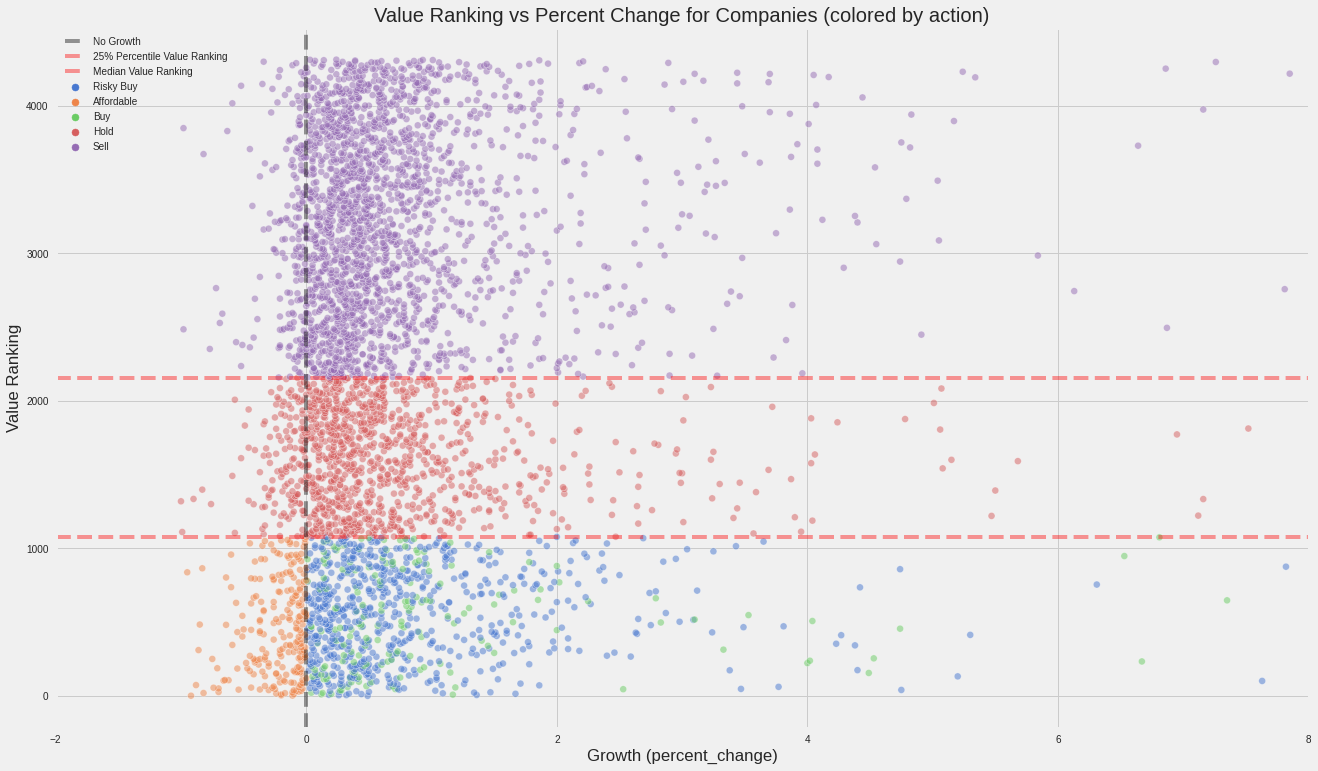

In [501]:
#plot value ranking vs growth
fig, ax = plt.subplots()

sns.scatterplot(data=df_explore, x='percent_change',y='value_ranking', hue='action', 
                alpha=0.5, ax=ax)

ax.axvline(x=0, color='black', linestyle='--', label='No Growth', alpha=0.4);

ax.axhline(y=df_explore['value_ranking'].quantile(q=0.25), color='red', linestyle='--', 
                        label='25% Percentile Value Ranking', alpha=0.4);

ax.axhline(y=df_explore['value_ranking'].quantile(q=0.50), color='red', linestyle='--', 
                        label='Median Value Ranking', alpha=0.4);
                
ax.set_xlim(-2,8)
ax.legend();
plt.title('Value Ranking vs Percent Change for Companies (colored by action)')
plt.xlabel('Growth (percent_change)')
plt.ylabel('Value Ranking')

> **OBSERVATIONS**
> - The `action` feature is helpful in evaluating which stocks should be further evaluated

## Correlation Heatmap

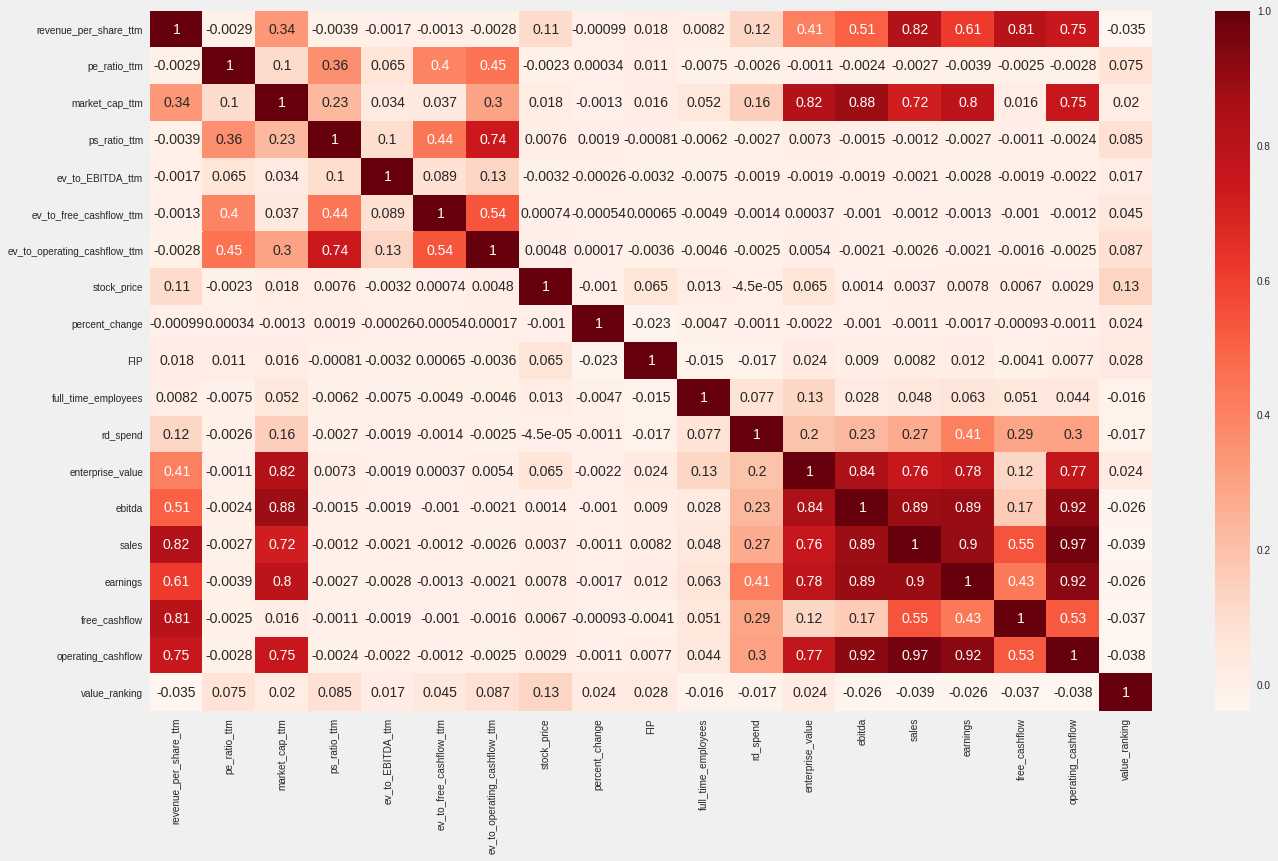

In [502]:
#evaluating the correlation between features
corr = df_explore.corr()
sns.heatmap(corr, cmap='Reds', annot=True)

> **OBSERVATIONS**
> - There are a few features which correlated quite highly with others. This is mostly between the individual values such as `enterprice_value`, `EBITDA`, `earnings` etc.

## Which Value Metrics Correlate with Stock Price Growth?

I want to know if one of the value metrics has a stronger correlation with stock performance than the others.

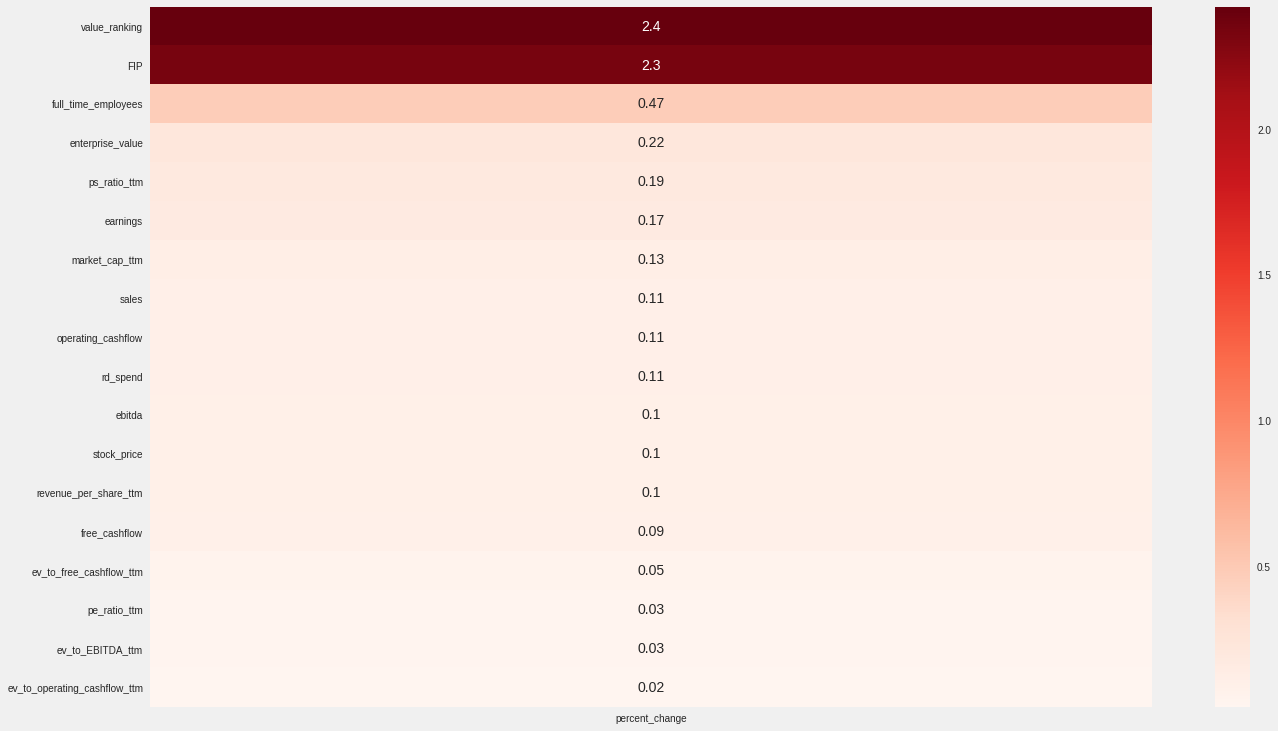

In [503]:
corr = df_explore.corr()
# sns.heatmap(corr, cmap='Reds', annot=True)
corr = round(np.abs(corr[['percent_change']]).sort_values('percent_change',ascending=False).drop(index='percent_change')*100,2)
sns.heatmap(corr, cmap='Reds', annot=True)

> **OBSERVATIONS**
> - There are no highly correlated features to changes in stock price

## What is the distribution of market cap groups by action?

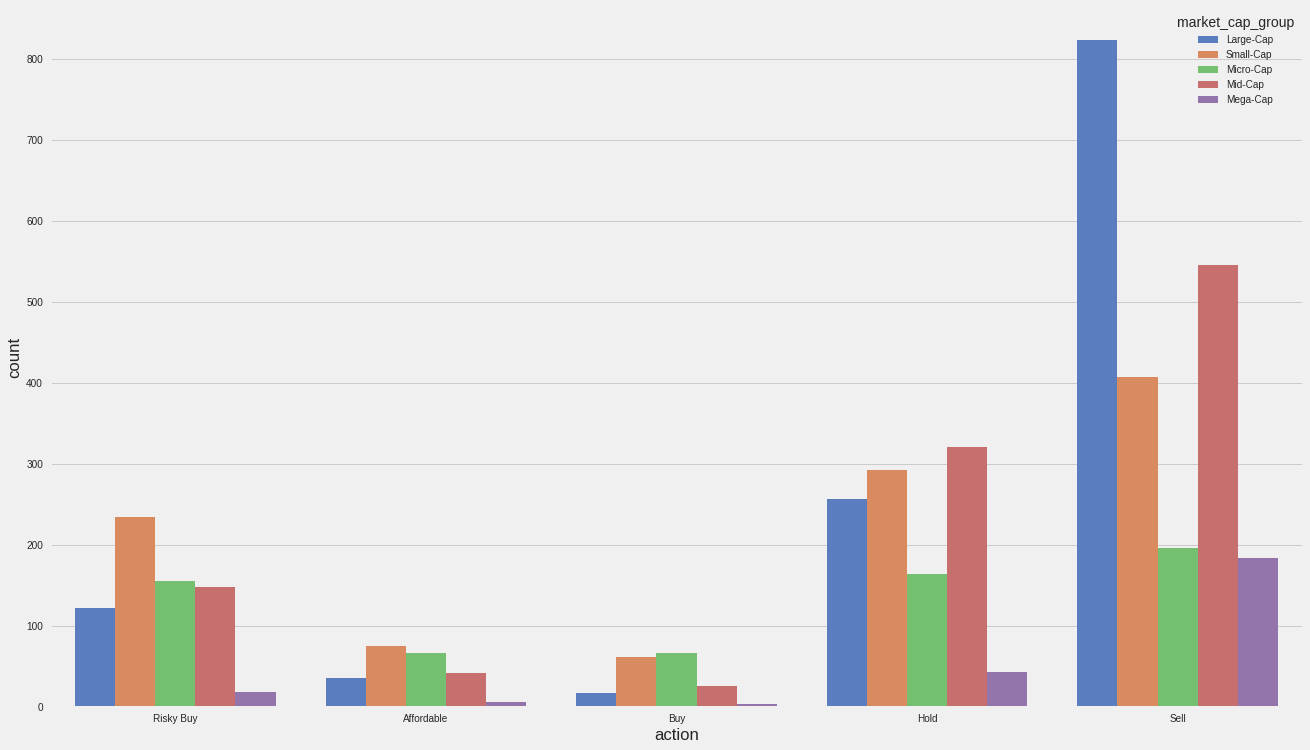

In [504]:
#graph distribution of action by market cap group
sns.countplot(data=df_explore, x='action', hue='market_cap_group')

> - **OBSERVATIONS**
> - The "Buy" action is predominantly Micro-cap and Small-cap companies which is good for the stakeholder as those companies are cheaper to buy

# MODELING

I will now start the modeling process. I will begin with using anomaly detection to identify which companies may have an issue with their underlying data quality through the FMP API.

In [505]:
#create modeling template df
df_model = df_clean.copy()

In [506]:
#review model dataframe
df_model.head()

,symbol,revenue_per_share_ttm,pe_ratio_ttm,market_cap_ttm,ps_ratio_ttm,ev_to_EBITDA_ttm,ev_to_free_cashflow_ttm,ev_to_operating_cashflow_ttm,stock_price,percent_change,FIP,company_name,exchange_short_name,industry,sector,country,full_time_employees,state,rd_spend,enterprise_value,ebitda,sales,earnings,free_cashflow,operating_cashflow,owned,market_cap_group,value_ranking,action
0,IIVIP,"26,456.67",0.14,"25,296,557,880.0",0.01,0.07,0.1,0.07,298.21,0.49,0.11,II-VI Incorporated,NASDAQ,Scientific & Technical Instruments,Technology,US,"22,969.0",PA,"339,073,000.0","20,000,316,000.0","179,112,000.0","2,380,071,000.0","-67,029,000.0","156,665,000.0","297,292,000.0",no,Large-Cap,1,Risky Buy
1,MON,247.0,0.18,"301,486,776.7",0.04,0.12,0.32,0.18,9.7,-0.92,0.11,Monument Circle Acquisition Corp.,NYSE,Shell Companies,Basic Materials,US,-999.0,Unknown,"1,607,000,000.0","58,016,016,000.0","4,109,000,000.0","14,640,000,000.0","2,260,000,000.0","1,915,000,000.0","3,226,000,000.0",no,Small-Cap,2,Affordable
2,1245.HK,23.45,1.66,"297,766,650.0",0.01,0.16,0.28,0.2,0.25,-0.11,0.15,"Niraku GC Holdings, Inc.",HKSE,Resorts & Casinos,"Hotels, Restaurants & Leisure",JP,"1,870.0",FUKUSHIMA-KEN,0.0,"-725,099,750.0","6,785,000,000.0","28,046,000,000.0","179,000,000.0","3,961,000,000.0","5,470,000,000.0",no,Micro-Cap,3,Affordable
3,KGL.NS,1.65,0.81,"372,634,615.5",0.15,0.0,0.0,0.0,0.2,-0.2,-0.12,Karuturi Global Limited,NSE,Farm Products,Food Products,IN,-999.0,KARNATAKA,0.0,"2,353,258,800.0","784,779,000.0","2,295,912,000.0","519,307,000.0","925,061,000.0","925,061,000.0",no,Small-Cap,4,Affordable
4,ALBDM.PA,25.99,0.85,"4,554,802.0",0.08,0.41,0.52,0.43,2.0,0.26,0.05,BD Multimedia SA,EURONEXT,Telecom Services,Communication Services,FR,16.0,ILE-DE-FRANCE,0.0,"610,714.0","-625,000.0","1,702,000.0","-364,000.0","-1,012,000.0","-873,000.0",no,Micro-Cap,5,Risky Buy


## Anomaly Detection Modeling

I will be using the Isolation Forest algorithm to find anomalies in the dataset which may help identify incorrect data. I do not know what are "true" anomalies, so I will allow the isolation forest algorithm auto detect the contamination parameter which defines the percentage of anomalies in the datset.

### Anomaly Detection of Value Metrics

I will run the model on just the value metrics because they have the greatest impact on the accuracy of the data.

In [507]:
#create anomaly df
df_anomaly = df_model.copy()

In [508]:
#only keep value metrics in df
df_anomaly = df_anomaly[['symbol','revenue_per_share_ttm', 'pe_ratio_ttm',
                         'ps_ratio_ttm', 'ev_to_EBITDA_ttm', 'ev_to_free_cashflow_ttm',
                         'ev_to_operating_cashflow_ttm']]

In [509]:
#review anomaly df
df_anomaly

,symbol,revenue_per_share_ttm,pe_ratio_ttm,ps_ratio_ttm,ev_to_EBITDA_ttm,ev_to_free_cashflow_ttm,ev_to_operating_cashflow_ttm
0,IIVIP,"26,456.67",0.14,0.01,0.07,0.1,0.07
1,MON,247.0,0.18,0.04,0.12,0.32,0.18
2,1245.HK,23.45,1.66,0.01,0.16,0.28,0.2
3,KGL.NS,1.65,0.81,0.15,0.0,0.0,0.0
4,ALBDM.PA,25.99,0.85,0.08,0.41,0.52,0.43
...,...,...,...,...,...,...,...
4306,POLY.ME,4.48,"1,705.87",363.27,"1,044.77","3,232.29","1,179.33"
4307,INFY.NS,3.11,"2,580.49",497.18,"1,779.63","2,266.88","2,068.58"
4308,WEY.L,0.06,"7,118.34",738.81,"8,275.08","4,464.53","3,941.31"
4309,GFNCP,0.03,"43,001.86","3,071.55","11,413.09","259,473.11","18,677.4"


In [510]:
#create isolation forest
if_model = IsolationForest()
results = if_model.fit(df_anomaly.drop(columns=['symbol']))

In [511]:
#add anomaly results to anomaly df
df_anomaly['anomaly'] = pd.DataFrame(results.predict(df_anomaly.drop(columns=['symbol'])))
df_anomaly

,symbol,revenue_per_share_ttm,pe_ratio_ttm,ps_ratio_ttm,ev_to_EBITDA_ttm,ev_to_free_cashflow_ttm,ev_to_operating_cashflow_ttm,anomaly
0,IIVIP,"26,456.67",0.14,0.01,0.07,0.1,0.07,-1
1,MON,247.0,0.18,0.04,0.12,0.32,0.18,1
2,1245.HK,23.45,1.66,0.01,0.16,0.28,0.2,1
3,KGL.NS,1.65,0.81,0.15,0.0,0.0,0.0,1
4,ALBDM.PA,25.99,0.85,0.08,0.41,0.52,0.43,1
...,...,...,...,...,...,...,...,...
4306,POLY.ME,4.48,"1,705.87",363.27,"1,044.77","3,232.29","1,179.33",-1
4307,INFY.NS,3.11,"2,580.49",497.18,"1,779.63","2,266.88","2,068.58",-1
4308,WEY.L,0.06,"7,118.34",738.81,"8,275.08","4,464.53","3,941.31",-1
4309,GFNCP,0.03,"43,001.86","3,071.55","11,413.09","259,473.11","18,677.4",-1


In [512]:
#value counts of the anomaly feature
df_anomaly['anomaly'].value_counts(normalize=True)*100

 1   95.52308049176526
-1   4.476919508234748
Name: anomaly, dtype: float64

In [513]:
#examples of anomalies
df_anomaly.loc[df_anomaly['anomaly'] == -1].head()

,symbol,revenue_per_share_ttm,pe_ratio_ttm,ps_ratio_ttm,ev_to_EBITDA_ttm,ev_to_free_cashflow_ttm,ev_to_operating_cashflow_ttm,anomaly
0,IIVIP,"26,456.67",0.14,0.01,0.07,0.1,0.07,-1
12,KT,"51,861.84",0.01,0.0,1.17,3.97,1.0,-1
208,BUR.PA,"4,658.88",6.58,0.16,3.36,12.91,2.76,-1
589,IBB,1.65,1.29,98.35,0.65,1.29,1.29,-1
591,LKOH.ME,"8,704.8",19.65,0.76,4.53,9.84,4.44,-1


> **OBSERVATIONS**
> - The isolation forest algorithm found a contamination rate of 5.5%. This number correlates with my stakeholders domain expertise.
> - Many anomalies show distinct outliers in at least one of the features

> **ACTIONS**
> - Add `anomaly` feature to df_explore dataframe

In [514]:
#add anomaly feature to df_explore df
df = df_anomaly[['symbol','anomaly']]
df_explore = pd.merge(df_explore, df, on='symbol')

In [515]:
#review df_explore 
df_explore

,symbol,revenue_per_share_ttm,pe_ratio_ttm,market_cap_ttm,ps_ratio_ttm,ev_to_EBITDA_ttm,ev_to_free_cashflow_ttm,ev_to_operating_cashflow_ttm,stock_price,percent_change,FIP,company_name,exchange_short_name,industry,sector,country,full_time_employees,state,rd_spend,enterprise_value,ebitda,sales,earnings,free_cashflow,operating_cashflow,owned,market_cap_group,value_ranking,action,anomaly
0,IIVIP,"26,456.67",0.14,"25,296,557,880.0",0.01,0.07,0.1,0.07,298.21,0.49,0.11,II-VI Incorporated,NASDAQ,Scientific & Technical Instruments,Technology,US,"22,969.0",PA,"339,073,000.0","20,000,316,000.0","179,112,000.0","2,380,071,000.0","-67,029,000.0","156,665,000.0","297,292,000.0",no,Large-Cap,1,Risky Buy,-1
1,MON,247.0,0.18,"301,486,776.7",0.04,0.12,0.32,0.18,9.7,-0.92,0.11,Monument Circle Acquisition Corp.,NYSE,Shell Companies,Basic Materials,US,-999.0,Unknown,"1,607,000,000.0","58,016,016,000.0","4,109,000,000.0","14,640,000,000.0","2,260,000,000.0","1,915,000,000.0","3,226,000,000.0",no,Small-Cap,2,Affordable,1
2,1245.HK,23.45,1.66,"297,766,650.0",0.01,0.16,0.28,0.2,0.25,-0.11,0.15,"Niraku GC Holdings, Inc.",HKSE,Resorts & Casinos,"Hotels, Restaurants & Leisure",JP,"1,870.0",FUKUSHIMA-KEN,0.0,"-725,099,750.0","6,785,000,000.0","28,046,000,000.0","179,000,000.0","3,961,000,000.0","5,470,000,000.0",no,Micro-Cap,3,Affordable,1
3,KGL.NS,1.65,0.81,"372,634,615.5",0.15,0.0,0.0,0.0,0.2,-0.2,-0.12,Karuturi Global Limited,NSE,Farm Products,Food Products,IN,-999.0,KARNATAKA,0.0,"2,353,258,800.0","784,779,000.0","2,295,912,000.0","519,307,000.0","925,061,000.0","925,061,000.0",no,Small-Cap,4,Affordable,1
4,ALBDM.PA,25.99,0.85,"4,554,802.0",0.08,0.41,0.52,0.43,2.0,0.26,0.05,BD Multimedia SA,EURONEXT,Telecom Services,Communication Services,FR,16.0,ILE-DE-FRANCE,0.0,"610,714.0","-625,000.0","1,702,000.0","-364,000.0","-1,012,000.0","-873,000.0",no,Micro-Cap,5,Risky Buy,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4306,POLY.ME,4.48,"1,705.87","765,509,709,753.0",363.27,"1,044.77","3,232.29","1,179.33","1,629.0",0.14,0.06,Polymetal International plc,MCX,Other Precious Metals & Mining,Metals & Mining,CY,"12,000.0",Unknown,0.0,"773,580,676,824.48","1,467,000,000.0","2,865,000,000.0","1,086,000,000.0","609,000,000.0","1,192,000,000.0",no,Mega-Cap,4307,Sell,-1
4307,INFY.NS,3.11,"2,580.49","6,742,821,562,500.0",497.18,"1,779.63","2,266.88","2,068.58","1,547.85",1.01,0.01,Infosys Limited,NSE,Information Technology Services,Technology,IN,"259,619.0",KARNATAKA,0.0,"5,704,549,919,311.15","3,766,000,000.0","13,561,000,000.0","2,613,000,000.0","2,973,000,000.0","3,258,000,000.0",no,Mega-Cap,4308,Sell,-1
4308,WEY.L,0.06,"7,118.34","6,179,406,644.25",738.81,"8,275.08","4,464.53","3,941.31",47.25,0.93,-0.13,Wey Education plc,LSE,Education & Training Services,Diversified Consumer Services,GB,200.0,Unknown,0.0,"3,393,799,445.0","745,962.0","8,364,052.0","868,097.0","1,382,653.0","1,566,204.0",no,Mid-Cap,4309,Sell,-1
4309,GFNCP,0.03,"43,001.86","1,062,705,000,000.0","3,071.55","11,413.09","259,473.11","18,677.4",101.21,0.03,0.01,General Finance Corporation,NASDAQ,Rental & Leasing Services,Industrials,US,916.0,CA,0.0,"354,323,000.0","94,768,000.0","356,479,000.0","7,954,000.0","13,969,000.0","76,574,000.0",no,Mega-Cap,4310,Sell,-1


## Model Preprocessing

### Rename Labels

In [516]:
#rare label encode features
rare_label_features = ['exchange_short_name','industry','sector','country',
                       'state']

for col in rare_label_features:
  rare_labels(df_model, col, 0.01)

In [517]:
#check value counts after rare label encoding
for col in rare_label_features:
  print(df_model[col].value_counts(normalize=True))
  print('\n')

NYSE           0.21039202041289723
NASDAQ         0.16910229645093947
HKSE           0.13639526791927628
NSE            0.13477151472976107
XETRA          0.08907446068197634
EURONEXT       0.07144514033866853
LSE            0.06147065646021805
TSX            0.05683136163303178
SIX           0.020180932498260265
MCX           0.014149849222918117
MUTUAL_FUND   0.012526096033402923
Rare          0.011830201809324982
OSE           0.011830201809324982
Name: exchange_short_name, dtype: float64


Rare                                      0.48898167478543264
Software—Application                       0.0329389932730225
Specialty Industrial Machinery           0.031315240083507306
Specialty Chemicals                      0.027139874739039668
Information Technology Services          0.027139874739039668
Packaged Foods                            0.02458826258408722
Real Estate Services                     0.024124333101368592
Drug Manufacturers—Specialty & Generic   0.020180932498260265
Auto 

## Supervised Classification of `action` Feature

I want to build a classification model which will predict the `action` feature for each stock. I will utilize more features outside the features used to create the target labels in the first place. 

In [518]:
#review the dataframe
df_model

,symbol,revenue_per_share_ttm,pe_ratio_ttm,market_cap_ttm,ps_ratio_ttm,ev_to_EBITDA_ttm,ev_to_free_cashflow_ttm,ev_to_operating_cashflow_ttm,stock_price,percent_change,FIP,company_name,exchange_short_name,industry,sector,country,full_time_employees,state,rd_spend,enterprise_value,ebitda,sales,earnings,free_cashflow,operating_cashflow,owned,market_cap_group,value_ranking,action
0,IIVIP,"26,456.67",0.14,"25,296,557,880.0",0.01,0.07,0.1,0.07,298.21,0.49,0.11,II-VI Incorporated,NASDAQ,Rare,Technology,US,"22,969.0",Rare,"339,073,000.0","20,000,316,000.0","179,112,000.0","2,380,071,000.0","-67,029,000.0","156,665,000.0","297,292,000.0",no,Large-Cap,1,Risky Buy
1,MON,247.0,0.18,"301,486,776.7",0.04,0.12,0.32,0.18,9.7,-0.92,0.11,Monument Circle Acquisition Corp.,NYSE,Rare,Basic Materials,US,-999.0,Unknown,"1,607,000,000.0","58,016,016,000.0","4,109,000,000.0","14,640,000,000.0","2,260,000,000.0","1,915,000,000.0","3,226,000,000.0",no,Small-Cap,2,Affordable
2,1245.HK,23.45,1.66,"297,766,650.0",0.01,0.16,0.28,0.2,0.25,-0.11,0.15,"Niraku GC Holdings, Inc.",HKSE,Rare,"Hotels, Restaurants & Leisure",Rare,"1,870.0",Rare,0.0,"-725,099,750.0","6,785,000,000.0","28,046,000,000.0","179,000,000.0","3,961,000,000.0","5,470,000,000.0",no,Micro-Cap,3,Affordable
3,KGL.NS,1.65,0.81,"372,634,615.5",0.15,0.0,0.0,0.0,0.2,-0.2,-0.12,Karuturi Global Limited,NSE,Rare,Food Products,IN,-999.0,KARNATAKA,0.0,"2,353,258,800.0","784,779,000.0","2,295,912,000.0","519,307,000.0","925,061,000.0","925,061,000.0",no,Small-Cap,4,Affordable
4,ALBDM.PA,25.99,0.85,"4,554,802.0",0.08,0.41,0.52,0.43,2.0,0.26,0.05,BD Multimedia SA,EURONEXT,Telecom Services,Communication Services,FR,16.0,ILE-DE-FRANCE,0.0,"610,714.0","-625,000.0","1,702,000.0","-364,000.0","-1,012,000.0","-873,000.0",no,Micro-Cap,5,Risky Buy
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4306,POLY.ME,4.48,"1,705.87","765,509,709,753.0",363.27,"1,044.77","3,232.29","1,179.33","1,629.0",0.14,0.06,Polymetal International plc,MCX,Rare,Metals & Mining,Rare,"12,000.0",Unknown,0.0,"773,580,676,824.48","1,467,000,000.0","2,865,000,000.0","1,086,000,000.0","609,000,000.0","1,192,000,000.0",no,Mega-Cap,4307,Sell
4307,INFY.NS,3.11,"2,580.49","6,742,821,562,500.0",497.18,"1,779.63","2,266.88","2,068.58","1,547.85",1.01,0.01,Infosys Limited,NSE,Information Technology Services,Technology,IN,"259,619.0",KARNATAKA,0.0,"5,704,549,919,311.15","3,766,000,000.0","13,561,000,000.0","2,613,000,000.0","2,973,000,000.0","3,258,000,000.0",no,Mega-Cap,4308,Sell
4308,WEY.L,0.06,"7,118.34","6,179,406,644.25",738.81,"8,275.08","4,464.53","3,941.31",47.25,0.93,-0.13,Wey Education plc,LSE,Rare,Rare,GB,200.0,Unknown,0.0,"3,393,799,445.0","745,962.0","8,364,052.0","868,097.0","1,382,653.0","1,566,204.0",no,Mid-Cap,4309,Sell
4309,GFNCP,0.03,"43,001.86","1,062,705,000,000.0","3,071.55","11,413.09","259,473.11","18,677.4",101.21,0.03,0.01,General Finance Corporation,NASDAQ,Rare,Industrials,US,916.0,Rare,0.0,"354,323,000.0","94,768,000.0","356,479,000.0","7,954,000.0","13,969,000.0","76,574,000.0",no,Mega-Cap,4310,Sell


In [519]:
#create dependent and independent features
X = df_model.drop(columns=['action', 'value_ranking',
                                          'company_name','symbol'])



y = df_model['action']

In [520]:
#look at target class imbalance
y.value_counts(normalize=True)*100

Sell         50.011598237067965
Hold         24.982602644398053
Risky Buy    15.704012990025515
Affordable    5.242403154720483
Buy           4.059382973787985
Name: action, dtype: float64

In [521]:
#create train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [522]:
#split featuers into categorical and numerical
num_cols = X_train.select_dtypes(exclude='object').columns
cat_cols = X_train.select_dtypes(include='object').columns

In [523]:
#ohe categorical columns
ohe = OneHotEncoder(sparse=False)
ohe.fit(X_train[cat_cols])

train_ohe_df = pd.DataFrame(ohe.transform(X_train[cat_cols]), 
                            columns=ohe.get_feature_names(cat_cols), 
                            index=X_train.index)

test_ohe_df = pd.DataFrame(ohe.transform(X_test[cat_cols]),
                           columns=ohe.get_feature_names(cat_cols),
                           index=X_test.index)

In [524]:
#scale numeric data
scaler = StandardScaler()
scaler.fit(X_train[num_cols])

train_scale_df = pd.DataFrame(scaler.transform(X_train[num_cols]),
                              columns=num_cols, index=X_train.index)

test_scale_df = pd.DataFrame(scaler.transform(X_test[num_cols]),
                             columns=num_cols, index=X_test.index)

In [525]:
#concat num and cat
X_train_tf = pd.concat([train_ohe_df,train_scale_df],axis=1)
X_test_tf = pd.concat([test_ohe_df,test_scale_df],axis=1)

## Dummy Classifier

The dummy model will predict the exact same distribution for the target variable, `action`, as is in the data. This model will be equivalent to randomly guessing and will be a good baseline to evaluate other models against.

In [526]:
#create dummy classifier model as a baseline
dummy = DummyClassifier()
#fit the dummy model
dummy.fit(X_train_tf,y_train);

CURRENT MODEL: Overfit (Recall)


Classification Reports-------------------------------------------
              precision    recall  f1-score   support

  Affordable       0.07      0.08      0.07        51
         Buy       0.03      0.02      0.02        43
        Hold       0.30      0.33      0.32       260
   Risky Buy       0.13      0.14      0.13       170
        Sell       0.51      0.48      0.49       554

    accuracy                           0.35      1078
   macro avg       0.21      0.21      0.21      1078
weighted avg       0.36      0.35      0.36      1078

Test Graphs------------------------------------------------------


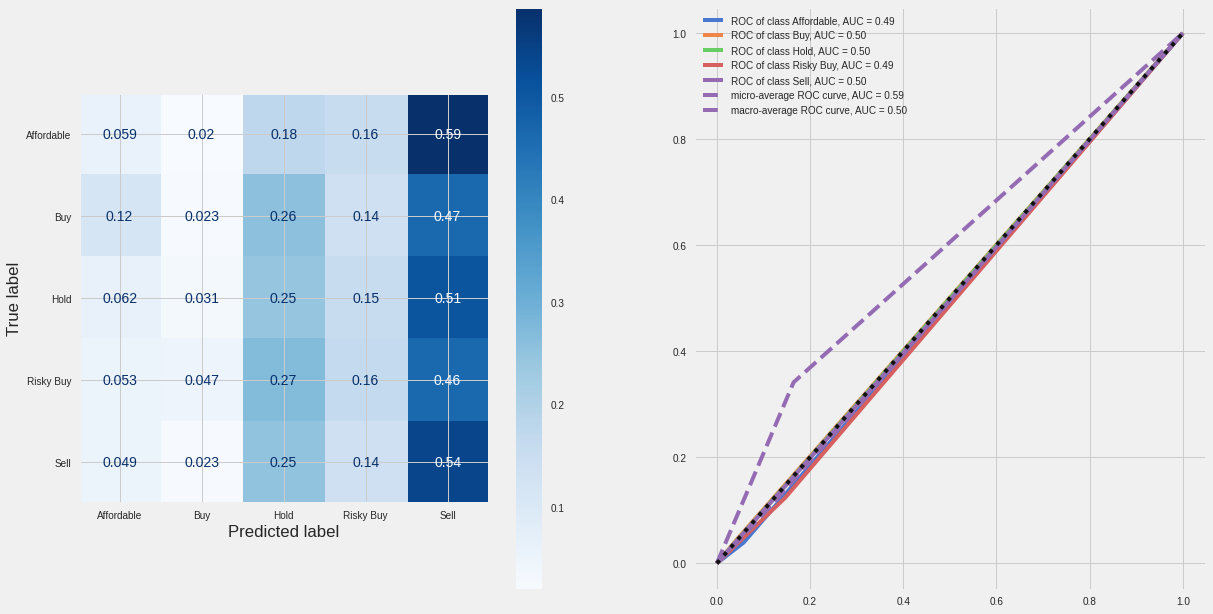

In [527]:
#evaluate dummy model
model_eval(dummy, X_train_tf, y_train, X_test_tf, y_test)

> **OBSERVATIONS**
> - The dummy classifier only provides a baseline to compare future models to.

## Random Forest

I will now build a random forest model for 2 main reasons:
1. Tree-based algorithms are outlier robust and there are many outliers that I kept in the dataset
2. Tree-based algorithms give insight into which features are most important to how the model came to its predictions

### Model #1

For model 1 I will build a vanilla random forest model.

In [528]:
#produce a vanilla random forest model
rf_1 = RandomForestClassifier()
#fit the data
rf_1.fit(X_train_tf, y_train);

### Model Evaluation

MODEL EVAL VS PREVIOUS (TEST)


,Previous Model,Current Model,Delta
Recall,0.22,0.9,0.69
F1,0.22,0.92,0.7
Accuracy,0.36,0.94,0.58




CURRENT MODEL: Overfit (Recall)


Recall on Training: 1.0
Recall on Test: 0.9043976004537422


Classification Reports-------------------------------------------
              precision    recall  f1-score   support

  Affordable       0.94      0.94      0.94        51
         Buy       0.97      0.79      0.87        43
        Hold       0.85      0.92      0.88       260
   Risky Buy       0.92      0.90      0.91       170
        Sell       0.99      0.97      0.98       554

    accuracy                           0.94      1078
   macro avg       0.93      0.90      0.92      1078
weighted avg       0.94      0.94      0.94      1078

Test Graphs------------------------------------------------------


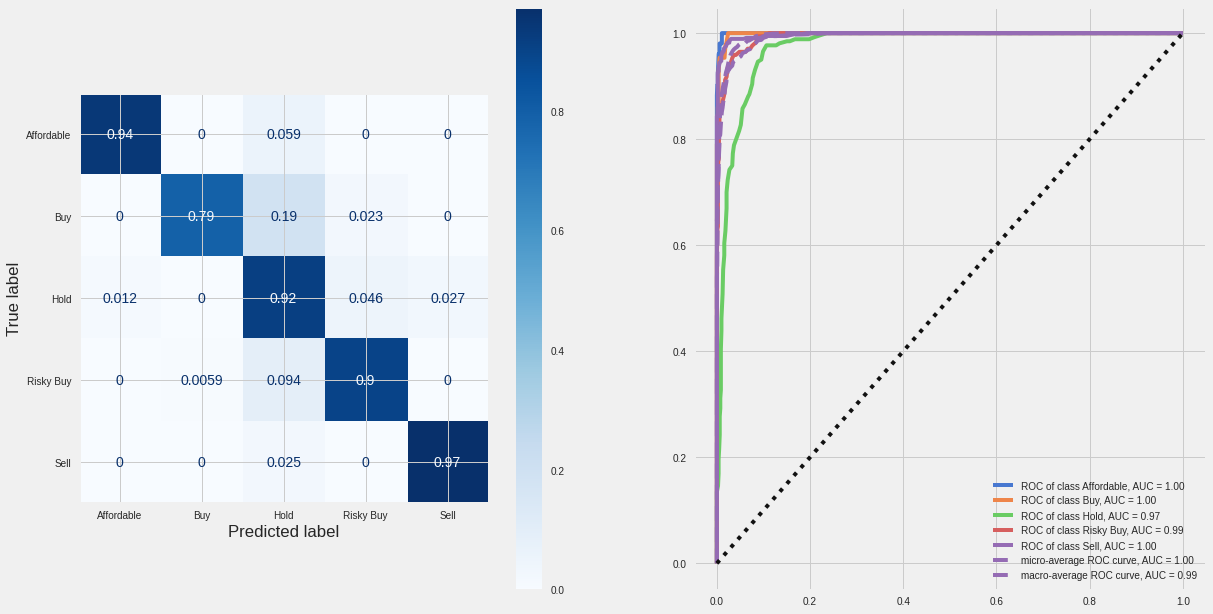

PREVIOUS MODEL


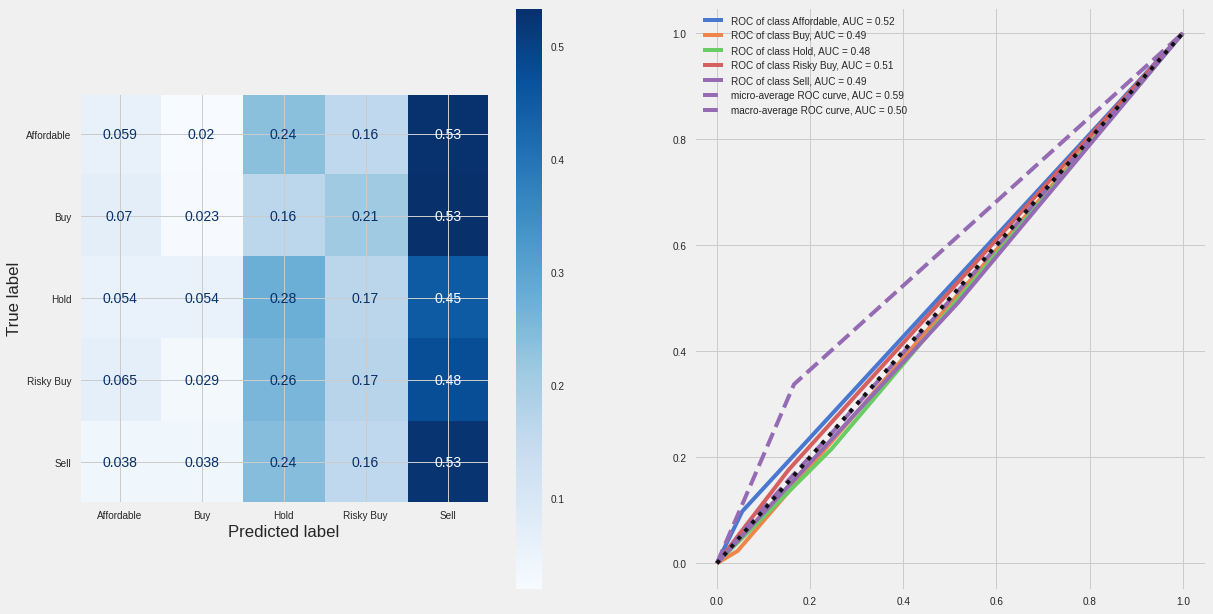

<Figure size 1440x864 with 0 Axes>

In [529]:
#evaluate the random forest model
model_eval(rf_1, X_train_tf, y_train, X_test_tf, y_test, 
               prev_model=dummy, prev_X_train=X_train_tf, prev_y_train=y_train, prev_X_test=X_test_tf, prev_y_test=y_test)

In [530]:
#number of leaves
print(f'Number of Leaves: {rf_1.estimators_[0].get_n_leaves()}')
print(f'Maximum Depth: {max([m.get_depth() for m in rf_1.estimators_])}')

Number of Leaves: 436
Maximum Depth: 33


> **OBSERVATIONS**
> - There was a significant improvement from the dummy model to the vanilla random forest model. The recall for "Buy" is around 10 points lower than the recall for others. 

> **ACTIONS**
> - I will address class imbalances first to see if that will help the issue pointed out above

### Model #2

For this model I will fix the class imbalancing issue to see if it improves the model's performance.

In [531]:
#create balanced random forest model
rf_2 = RandomForestClassifier()

In [532]:
#establish parameters
params = [{'class_weight': [None,'balanced']}]

In [533]:
#gridsearch and fit model
rf_2_gridsearch = GridSearchCV(rf_2, params, scoring='recall_macro', n_jobs=-1, cv=5)
rf_2_gridsearch.fit(X_train_tf, y_train);

In [534]:
#find the best parameters
rf_2_gridsearch.best_estimator_

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

### Model Evaluation

MODEL EVAL VS PREVIOUS (TEST)


,Previous Model,Current Model,Delta
Recall,0.9,0.91,0.01
F1,0.92,0.92,0.01
Accuracy,0.94,0.94,0.0




CURRENT MODEL: Overfit (Recall)


Recall on Training: 1.0
Recall on Test: 0.9095380102274371


Classification Reports-------------------------------------------
              precision    recall  f1-score   support

  Affordable       0.96      0.94      0.95        51
         Buy       1.00      0.84      0.91        43
        Hold       0.86      0.88      0.87       260
   Risky Buy       0.90      0.91      0.91       170
        Sell       0.98      0.97      0.97       554

    accuracy                           0.94      1078
   macro avg       0.94      0.91      0.92      1078
weighted avg       0.94      0.94      0.94      1078

Test Graphs------------------------------------------------------




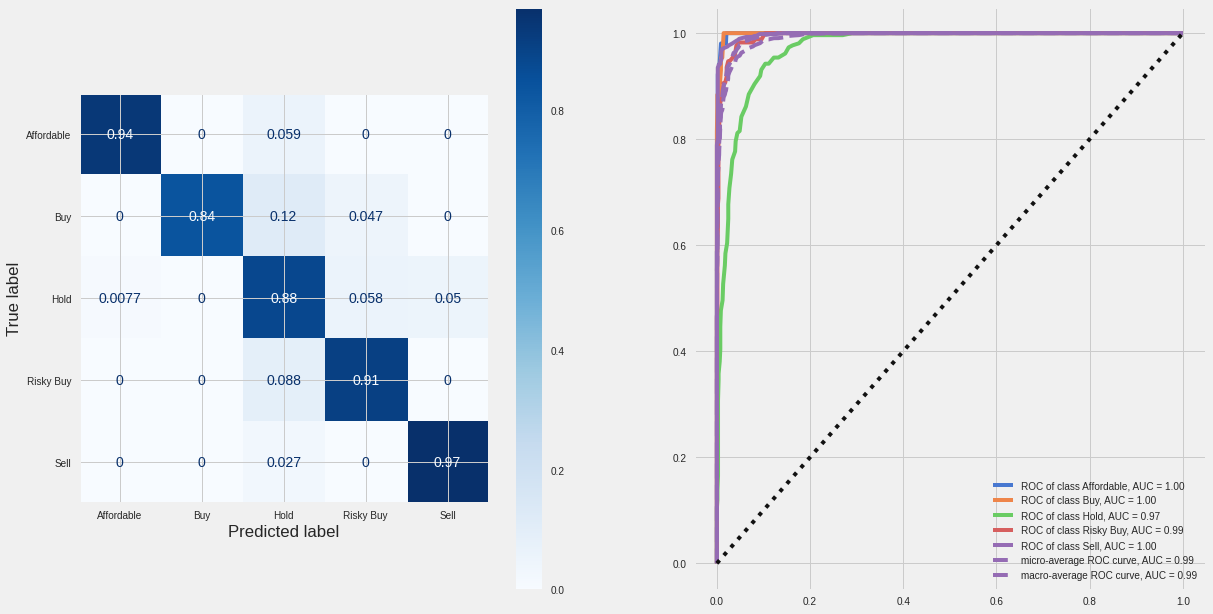

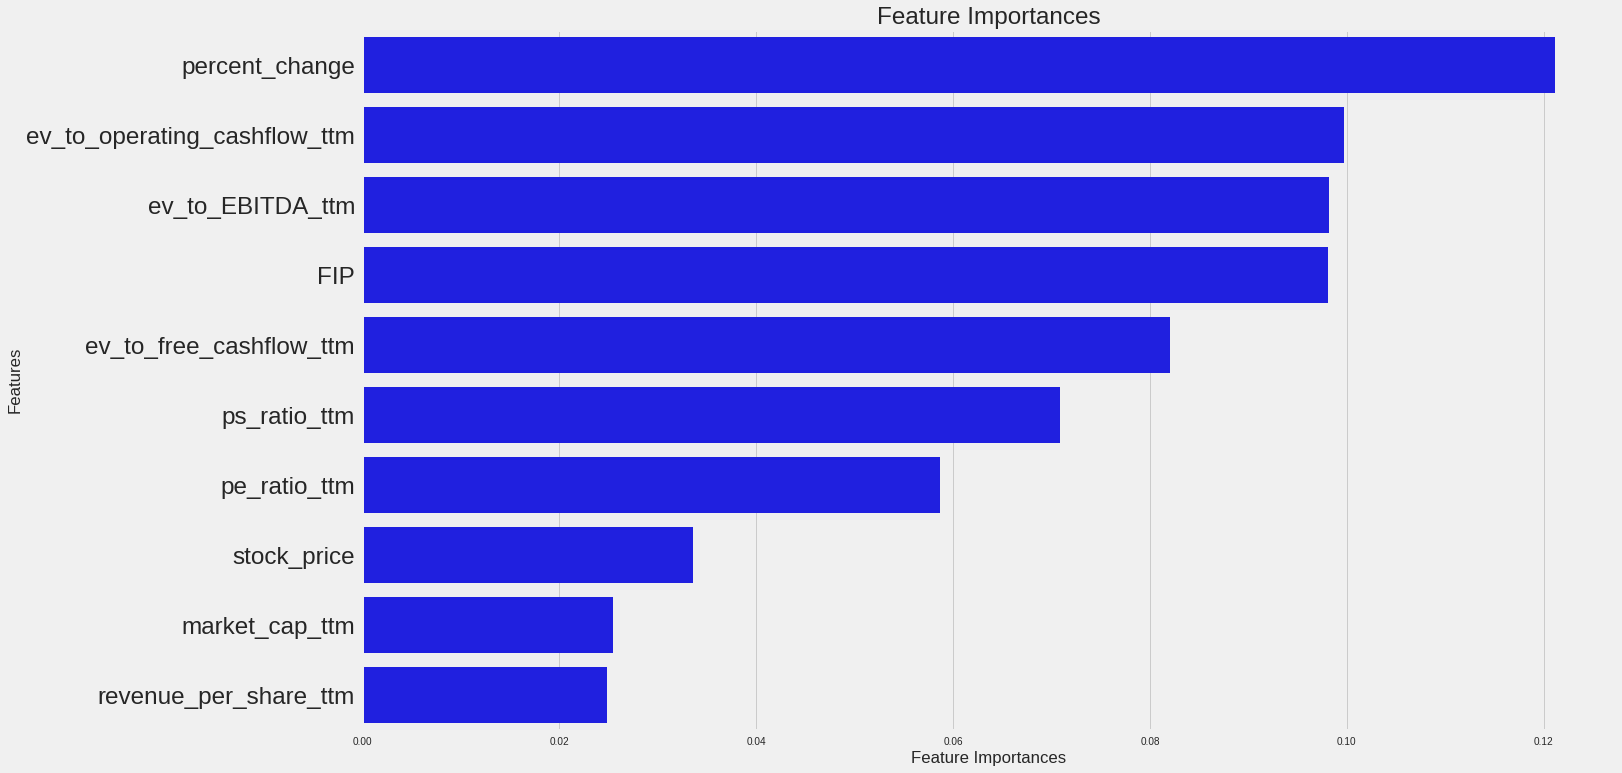



PREVIOUS MODEL


<Figure size 1440x864 with 0 Axes>

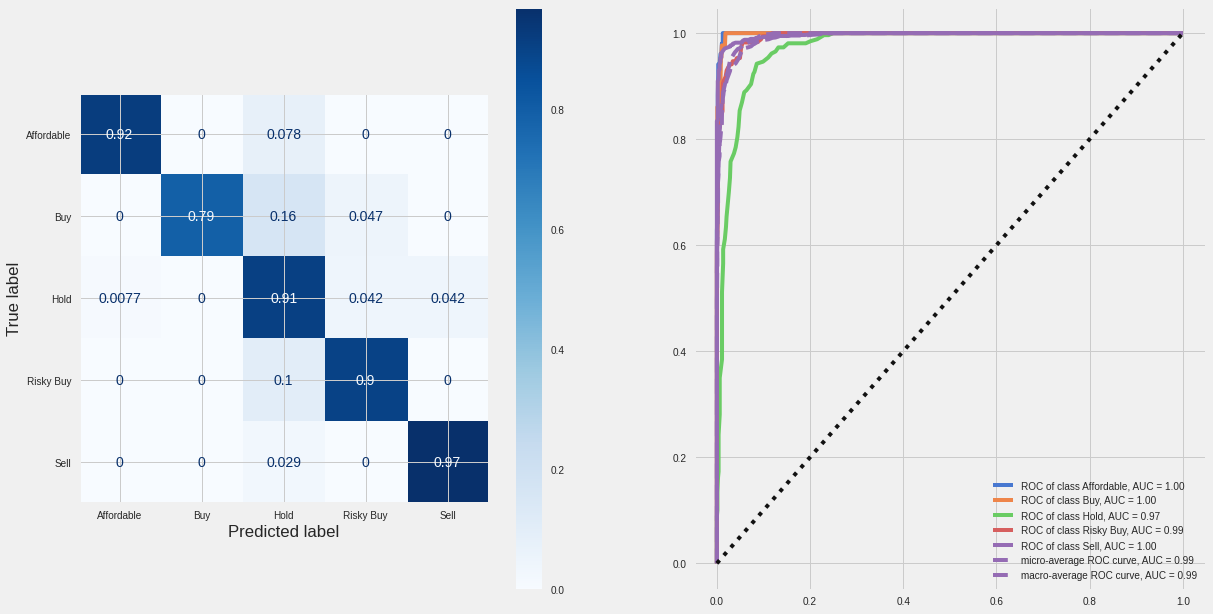

<Figure size 1440x864 with 0 Axes>

In [535]:
#evaluate the random forest model
model_eval(rf_2_gridsearch.best_estimator_, X_train_tf, y_train, X_test_tf, y_test, 
               prev_model=rf_1)

> **OBSERVATIONS**
> - adjusting for class imbalances has essentially the same performance as the previous random forest model.
> - Recall for "Buy" improved a bit

### Model #3

I will now do a parameter gridsearch to optimize the random forest model.

In [536]:
#create RF model
rf_3 = RandomForestClassifier()

```python
#initial parameters for gridsearch
params = [{'n_estimators': [100, 250, 500],
           'criterion': ['entropy','gini'],
           'max_features': ["auto", "log2"],
           'class_weight': ['balanced'],
           'max_depth':[5, 10, 25],
           'min_samples_split': [1,2,3],
           'min_samples_leaf': [1,2,3]}]

```

In [537]:
#final parameters for gridsearch
params = [{'n_estimators': [500],
           'criterion': ['entropy'],
           'max_features': ["auto"],
           'class_weight': ['balanced'],
           'max_depth':[25],
           'min_samples_split': [3],
           'min_samples_leaf': [1]}]

In [538]:
#create and fit gridsearch
rf_3_gridsearch = GridSearchCV(rf_3, params, scoring='recall_macro', n_jobs=-1, cv=5)
rf_3_gridsearch.fit(X_train_tf, y_train);

### Model Evaluation

MODEL EVAL VS PREVIOUS (TEST)


,Previous Model,Current Model,Delta
Recall,0.9,0.93,0.03
F1,0.91,0.93,0.02
Accuracy,0.93,0.94,0.01




CURRENT MODEL: Overfit (Recall)


Recall on Training: 1.0
Recall on Test: 0.9269680889928609


Classification Reports-------------------------------------------
              precision    recall  f1-score   support

  Affordable       0.92      0.96      0.94        51
         Buy       1.00      0.88      0.94        43
        Hold       0.88      0.90      0.89       260
   Risky Buy       0.92      0.92      0.92       170
        Sell       0.98      0.98      0.98       554

    accuracy                           0.94      1078
   macro avg       0.94      0.93      0.93      1078
weighted avg       0.94      0.94      0.94      1078

Test Graphs------------------------------------------------------




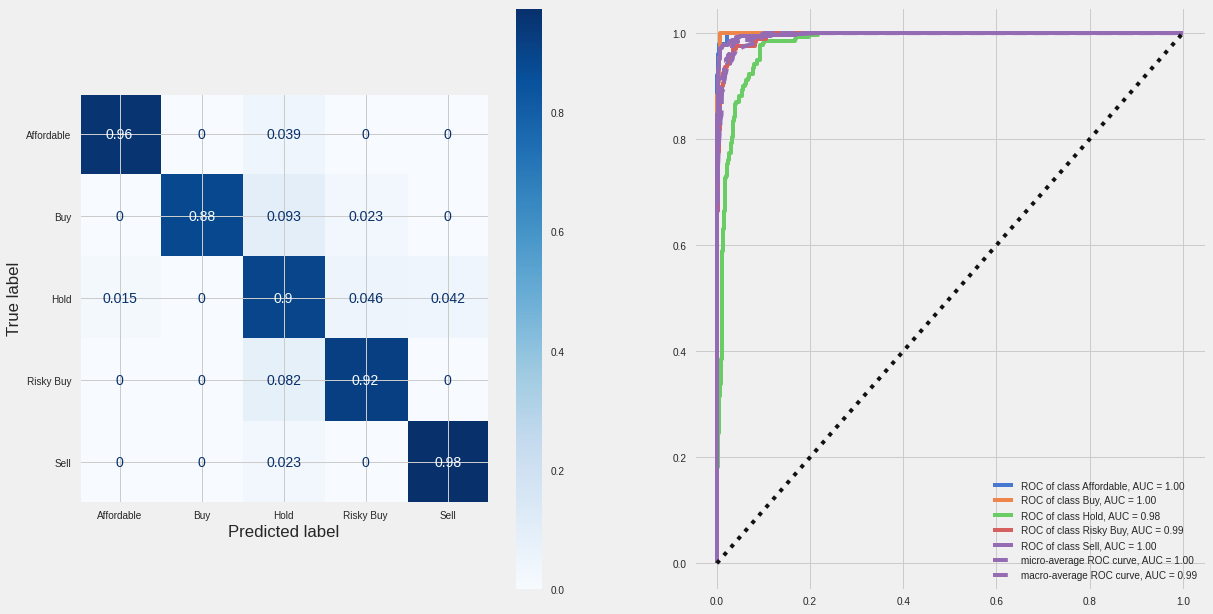

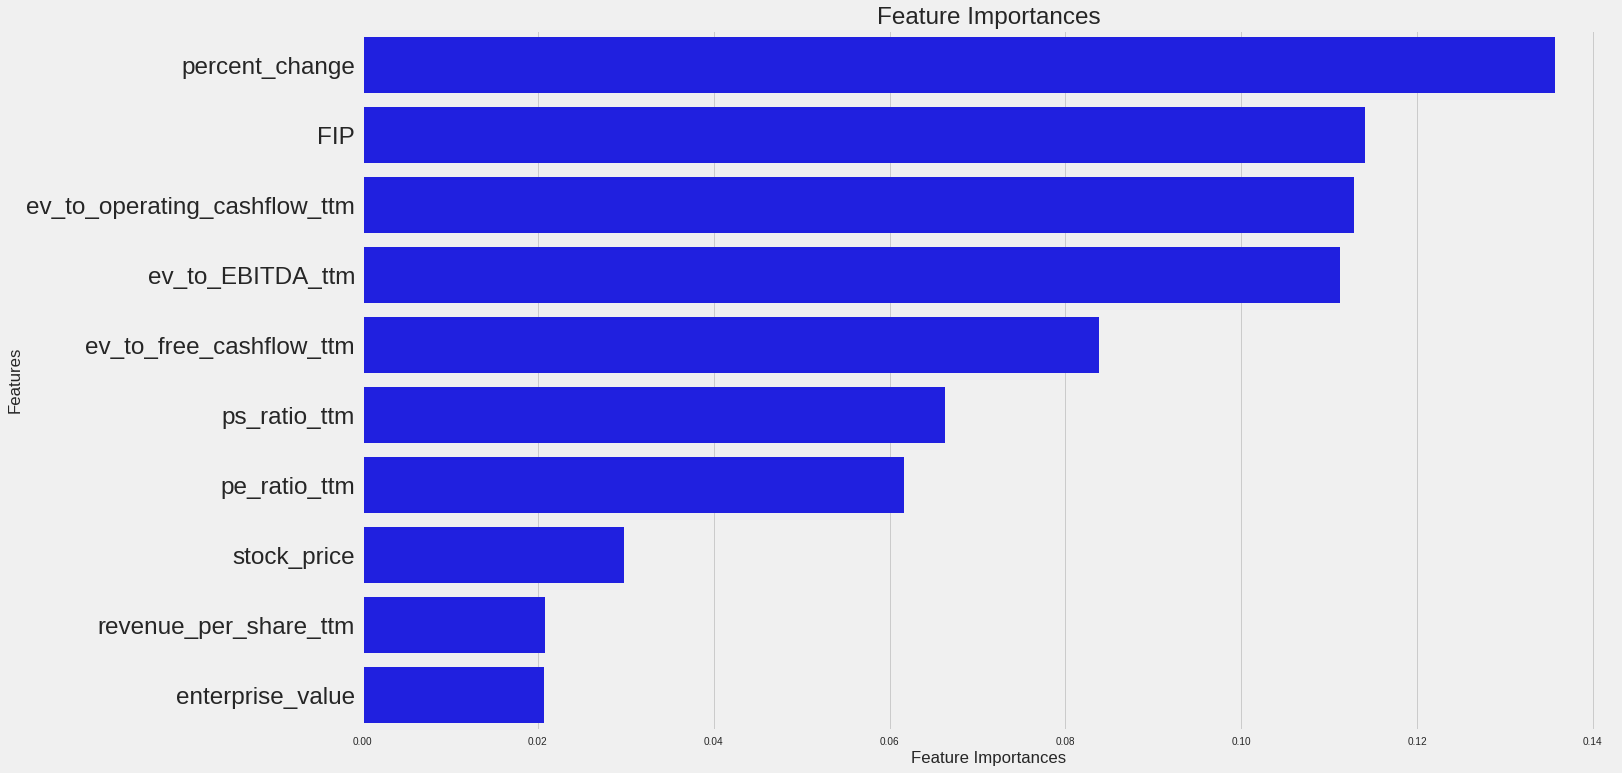



PREVIOUS MODEL


<Figure size 1440x864 with 0 Axes>

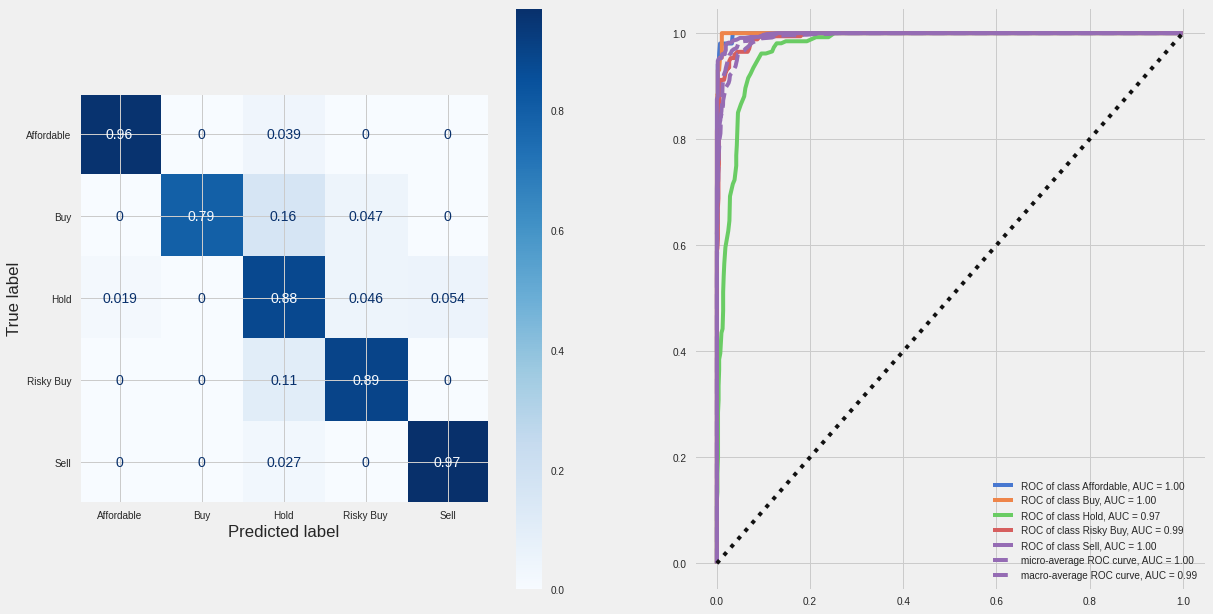

<Figure size 1440x864 with 0 Axes>

In [539]:
#evaluate the random forest model
model_eval(rf_3_gridsearch.best_estimator_, X_train_tf, y_train, X_test_tf, y_test, 
               prev_model=rf_2_gridsearch.best_estimator_)

> **OBSERVATIONS**
> - The optimized random forest model has barely improved the model.
> - The model is still overfit.

> **ACTIONS**
> - I would like to evaluate if boosted trees will improve the performance of the classifier further.

## XGBoosted Trees

I will now evaluate boosted trees to see if I can get improved model performance.

### Model #4

In [540]:
#create boosted tree model
boosted_tree = GradientBoostingClassifier()

```python
#initial parameters for gridsearch
params = [{'n_estimators': [100, 150],
           'learning_rate': [0.1,0.05,0.2],
           'criterion': ['mse', 'mae','friedman_mse'],
           'max_depth':[2,3,4,5]}]

```

In [541]:
#final parameters for gridsearch
params = [{'n_estimators': [100],
           'learning_rate': [0.1],
           'max_depth':[2,3,4]}]

In [542]:
#create and fit gridsearch
boosted_tree_gridsearch = GridSearchCV(boosted_tree, params, scoring='recall_macro',
                                       n_jobs=-1, cv=5)
boosted_tree_gridsearch.fit(X_train_tf, y_train);

In [543]:
#get the best estimator results
boosted_tree_gridsearch.best_estimator_

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

### Model Evaluation

MODEL EVAL VS PREVIOUS (TEST)


,Previous Model,Current Model,Delta
Recall,0.93,0.93,0.0
F1,0.94,0.93,-0.01
Accuracy,0.95,0.95,-0.0




CURRENT MODEL: Overfit (Recall)


Recall on Training: 1.0
Recall on Test: 0.9342227224970314


Classification Reports-------------------------------------------
              precision    recall  f1-score   support

  Affordable       0.89      0.98      0.93        51
         Buy       0.95      0.91      0.93        43
        Hold       0.89      0.88      0.89       260
   Risky Buy       0.92      0.91      0.91       170
        Sell       0.99      0.99      0.99       554

    accuracy                           0.95      1078
   macro avg       0.93      0.93      0.93      1078
weighted avg       0.95      0.95      0.95      1078

Test Graphs------------------------------------------------------




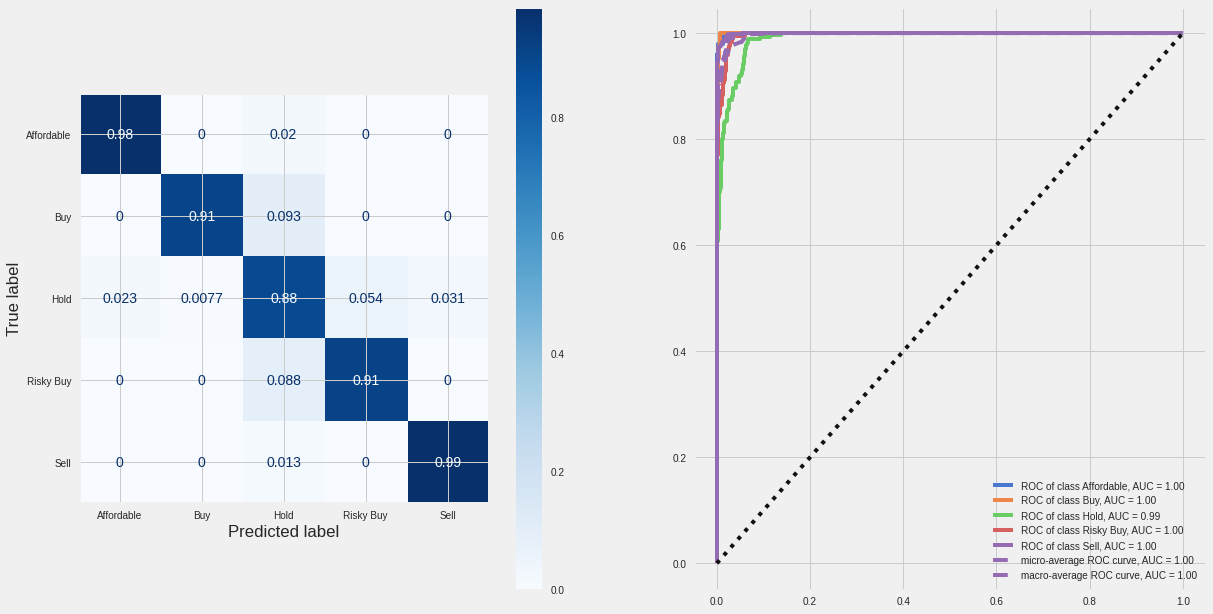

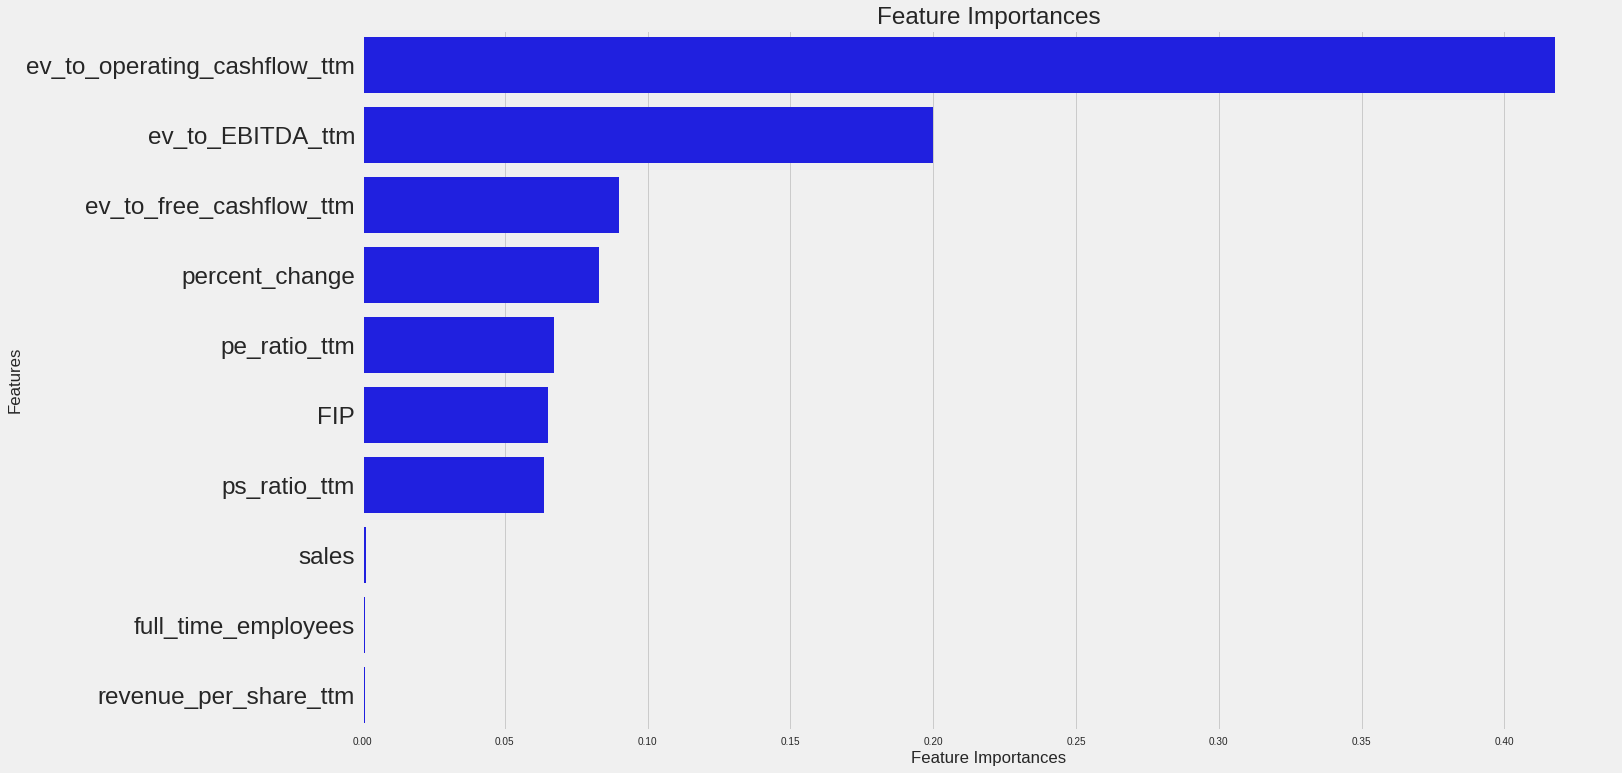



PREVIOUS MODEL


<Figure size 1440x864 with 0 Axes>

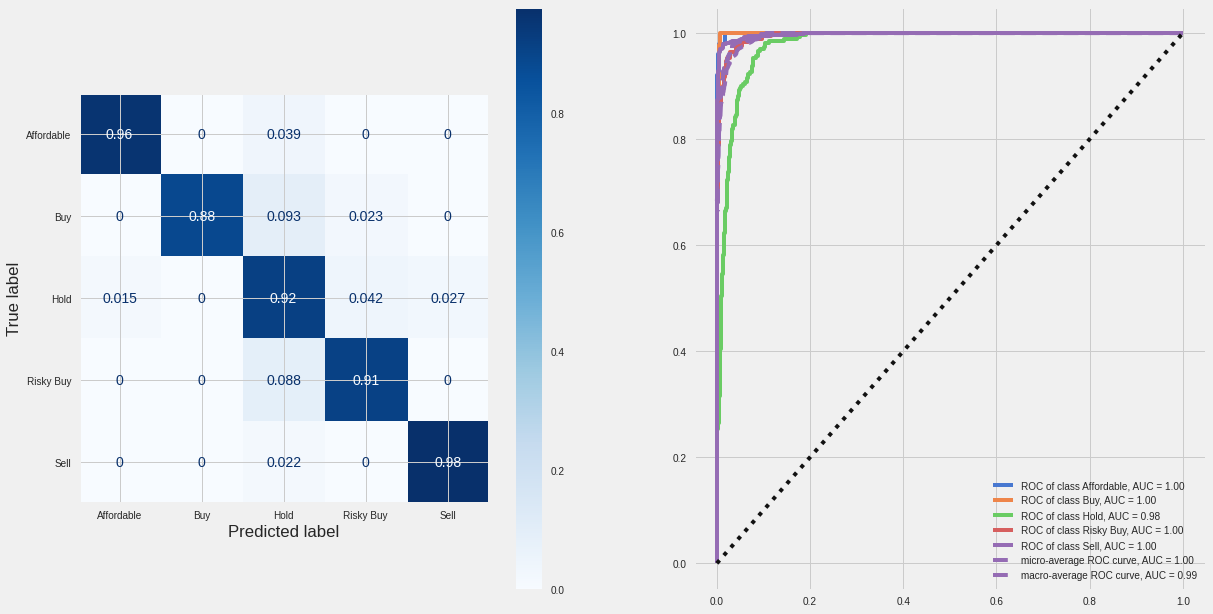

<Figure size 1440x864 with 0 Axes>

In [544]:
#evaluate the model
model_eval(boosted_tree_gridsearch.best_estimator_, X_train_tf, y_train, X_test_tf, y_test, 
               prev_model=rf_3_gridsearch.best_estimator_)

> **OBSERVATIONS**
> - The XGBoost model has improved performance across the board. The recall for "Buy" has also improved as well. 
> - The model is still a bit overfit but it is getting better

## Save Model Predictions

I will now save the model predictions to the df_explore dataframe to import into the Tableau dashboard.

In [545]:
#concat the dataframes
X_concat = pd.concat([X_train_tf, X_test_tf])
y_concat = pd.concat([y_train, y_test])

In [546]:
#sort and view the df
X_concat.sort_index(inplace=True)
X_concat

,exchange_short_name_EURONEXT,exchange_short_name_HKSE,exchange_short_name_LSE,exchange_short_name_MCX,exchange_short_name_MUTUAL_FUND,exchange_short_name_NASDAQ,exchange_short_name_NSE,exchange_short_name_NYSE,exchange_short_name_OSE,exchange_short_name_Rare,exchange_short_name_SIX,exchange_short_name_TSX,exchange_short_name_XETRA,industry_Aerospace & Defense,industry_Auto Parts,industry_Building Products & Equipment,industry_Communication Equipment,industry_Drug Manufacturers—Specialty & Generic,industry_Electrical Equipment & Parts,industry_Electronic Components,industry_Engineering & Construction,"industry_Furnishings, Fixtures & Appliances",industry_Gold,industry_Household & Personal Products,industry_Information Technology Services,industry_Medical Care Facilities,industry_Medical Devices,industry_Medical Instruments & Supplies,industry_Oil & Gas E&P,industry_Oil & Gas Midstream,industry_Packaged Foods,industry_Packaging & Containers,industry_Rare,industry_Real Estate Services,industry_Real Estate—Development,industry_Restaurants,industry_Semiconductors,industry_Software—Application,industry_Software—Infrastructure,industry_Specialty Business Services,...,state_GUANGDONG,state_ILE-DE-FRANCE,state_ILLINOIS,state_KARNATAKA,state_MAHARASHTRA,state_MASSACHUSETTS,state_NEW JERSEY,state_NEW YORK,state_OHIO,state_ONTARIO,state_PENNSYLVANIA,state_Rare,state_TAMIL NADU,state_TEXAS,state_Unknown,owned_no,owned_yes,market_cap_group_Large-Cap,market_cap_group_Mega-Cap,market_cap_group_Micro-Cap,market_cap_group_Mid-Cap,market_cap_group_Small-Cap,revenue_per_share_ttm,pe_ratio_ttm,market_cap_ttm,ps_ratio_ttm,ev_to_EBITDA_ttm,ev_to_free_cashflow_ttm,ev_to_operating_cashflow_ttm,stock_price,percent_change,FIP,full_time_employees,rd_spend,enterprise_value,ebitda,sales,earnings,free_cashflow,operating_cashflow
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,7.1257554584034235,-0.06058159032957635,-0.05198673645343733,-0.07614220201733933,-0.04315481290264683,-0.03561206592877991,-0.06886098476175254,-0.01068692142584486,-0.022560226509073394,0.8711837816495244,0.041770762115654156,-0.03455965156882948,-0.0848038501359365,-0.04926144402499096,-0.05444551295320231,-0.07725968686248694,-0.052776490371721704,-0.05715366208095471
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.009666035961123169,-0.06056172017661535,-0.06332380396014899,-0.07591394866638265,-0.04313053753245322,-0.03556427610885907,-0.06870615650550421,-0.20685628956229601,-0.04260928973922032,0.8711837816495244,-0.25331286974499095,0.03797202161119557,-0.04352154989099207,-0.03769471590201615,-0.046222439903782296,-0.04024432899265668,-0.036922771448557413,-0.046151976034926295
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.051029187991981785,-0.05982652451705824,-0.06332549130592037,-0.07614220201733933,-0.04311111723629834,-0.0355729651670265,-0.06867800591345906,-0.21328171859036943,-0.03109174277722102,1.2336374915324713,-0.21799098473964254,-0.053956298237108194,-0.10731015241875125,-0.029818520840711456,-0.037230665375518335,-0.0733461767681321,-0.018475371540807098,-0.037722394291957125
3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.05694802441415887

In [547]:
#make model predictions
model_preds = boosted_tree_gridsearch.predict(X_concat)

In [548]:
#add predictions to df_explore
df_explore['model_action'] = model_preds
df_explore.head()

,symbol,revenue_per_share_ttm,pe_ratio_ttm,market_cap_ttm,ps_ratio_ttm,ev_to_EBITDA_ttm,ev_to_free_cashflow_ttm,ev_to_operating_cashflow_ttm,stock_price,percent_change,FIP,company_name,exchange_short_name,industry,sector,country,full_time_employees,state,rd_spend,enterprise_value,ebitda,sales,earnings,free_cashflow,operating_cashflow,owned,market_cap_group,value_ranking,action,anomaly,model_action
0,IIVIP,"26,456.67",0.14,"25,296,557,880.0",0.01,0.07,0.1,0.07,298.21,0.49,0.11,II-VI Incorporated,NASDAQ,Scientific & Technical Instruments,Technology,US,"22,969.0",PA,"339,073,000.0","20,000,316,000.0","179,112,000.0","2,380,071,000.0","-67,029,000.0","156,665,000.0","297,292,000.0",no,Large-Cap,1,Risky Buy,-1,Risky Buy
1,MON,247.0,0.18,"301,486,776.7",0.04,0.12,0.32,0.18,9.7,-0.92,0.11,Monument Circle Acquisition Corp.,NYSE,Shell Companies,Basic Materials,US,-999.0,Unknown,"1,607,000,000.0","58,016,016,000.0","4,109,000,000.0","14,640,000,000.0","2,260,000,000.0","1,915,000,000.0","3,226,000,000.0",no,Small-Cap,2,Affordable,1,Affordable
2,1245.HK,23.45,1.66,"297,766,650.0",0.01,0.16,0.28,0.2,0.25,-0.11,0.15,"Niraku GC Holdings, Inc.",HKSE,Resorts & Casinos,"Hotels, Restaurants & Leisure",JP,"1,870.0",FUKUSHIMA-KEN,0.0,"-725,099,750.0","6,785,000,000.0","28,046,000,000.0","179,000,000.0","3,961,000,000.0","5,470,000,000.0",no,Micro-Cap,3,Affordable,1,Affordable
3,KGL.NS,1.65,0.81,"372,634,615.5",0.15,0.0,0.0,0.0,0.2,-0.2,-0.12,Karuturi Global Limited,NSE,Farm Products,Food Products,IN,-999.0,KARNATAKA,0.0,"2,353,258,800.0","784,779,000.0","2,295,912,000.0","519,307,000.0","925,061,000.0","925,061,000.0",no,Small-Cap,4,Affordable,1,Affordable
4,ALBDM.PA,25.99,0.85,"4,554,802.0",0.08,0.41,0.52,0.43,2.0,0.26,0.05,BD Multimedia SA,EURONEXT,Telecom Services,Communication Services,FR,16.0,ILE-DE-FRANCE,0.0,"610,714.0","-625,000.0","1,702,000.0","-364,000.0","-1,012,000.0","-873,000.0",no,Micro-Cap,5,Risky Buy,1,Risky Buy


In [549]:
#create features for identifying difference between model and actual
df_explore['model_correct'] = df_explore['action'] == df_explore['model_action']

In [550]:
#review the accuracy between model and actual
df_explore['model_correct'].value_counts(1)*100

True     98.65460450011598
False   1.3453954998840176
Name: model_correct, dtype: float64

# DATA INTERPRETATION

There were 2 main aspects of this analysis that I'd like to discuss:
1. Using anomaly detection for identifying potentially incorrect data
2. Utilizing classification algorithms to predict my action labels.

> Anomaly Detection
The anomaly detection algorithm identified 4-5% of the stocks which are outliers for the main features in this analysis. The insights from this are best seen in the Tableau dashboard where I utilize the `anomaly` feature to quickly mark stocks which may have a potential issue in the data quality.

> Classification Modeling of `action` feature
The initial labeling of the `action` feature was done as a hard-coded segregation and then used as the target of the classification model. The initial models were providing great overall accuracy of 92%. However, the XGBoosted model performed improved overall accuracy to 94% but significantly increased the recall score of the "Buy" action which is the most important label. The model also gave insight into which features were most important to making its predictions. By far, the `ev_to_operating_cashflow` feature was the most important.

# RECOMMENDATIONS AND CONCLUSIONS

In conclusion, this analysis provides HIT Investments 3 main capabilities that improve the analysis of which stocks to evaluate for potential purchase:
1. The ability to segregate stocks into distinct action buckets using machine learning which drastically speeds up the analysis since a user can focus on only the stocks with the action of "Buy". 
2. Provides a quick way to identify stocks where the data quality has skewed the results and further vetting needs to be done before making an investment. 3. Gives insight into which stock performance features are good at helping bucket stocks into distinct action buckets

The 3 capabilities above are brought together intelligently in an interactive Tableau dashboard that will make investigating and analyzing stocks much quicker.

For the future, it is recommended to create a live data pipeline that can be updated daily to have the most up to date information feeding the Tableau dashboard at any given moment.

#Appendix

## Tableau File Export

In [551]:
df_explore

,symbol,revenue_per_share_ttm,pe_ratio_ttm,market_cap_ttm,ps_ratio_ttm,ev_to_EBITDA_ttm,ev_to_free_cashflow_ttm,ev_to_operating_cashflow_ttm,stock_price,percent_change,FIP,company_name,exchange_short_name,industry,sector,country,full_time_employees,state,rd_spend,enterprise_value,ebitda,sales,earnings,free_cashflow,operating_cashflow,owned,market_cap_group,value_ranking,action,anomaly,model_action,model_correct
0,IIVIP,"26,456.67",0.14,"25,296,557,880.0",0.01,0.07,0.1,0.07,298.21,0.49,0.11,II-VI Incorporated,NASDAQ,Scientific & Technical Instruments,Technology,US,"22,969.0",PA,"339,073,000.0","20,000,316,000.0","179,112,000.0","2,380,071,000.0","-67,029,000.0","156,665,000.0","297,292,000.0",no,Large-Cap,1,Risky Buy,-1,Risky Buy,True
1,MON,247.0,0.18,"301,486,776.7",0.04,0.12,0.32,0.18,9.7,-0.92,0.11,Monument Circle Acquisition Corp.,NYSE,Shell Companies,Basic Materials,US,-999.0,Unknown,"1,607,000,000.0","58,016,016,000.0","4,109,000,000.0","14,640,000,000.0","2,260,000,000.0","1,915,000,000.0","3,226,000,000.0",no,Small-Cap,2,Affordable,1,Affordable,True
2,1245.HK,23.45,1.66,"297,766,650.0",0.01,0.16,0.28,0.2,0.25,-0.11,0.15,"Niraku GC Holdings, Inc.",HKSE,Resorts & Casinos,"Hotels, Restaurants & Leisure",JP,"1,870.0",FUKUSHIMA-KEN,0.0,"-725,099,750.0","6,785,000,000.0","28,046,000,000.0","179,000,000.0","3,961,000,000.0","5,470,000,000.0",no,Micro-Cap,3,Affordable,1,Affordable,True
3,KGL.NS,1.65,0.81,"372,634,615.5",0.15,0.0,0.0,0.0,0.2,-0.2,-0.12,Karuturi Global Limited,NSE,Farm Products,Food Products,IN,-999.0,KARNATAKA,0.0,"2,353,258,800.0","784,779,000.0","2,295,912,000.0","519,307,000.0","925,061,000.0","925,061,000.0",no,Small-Cap,4,Affordable,1,Affordable,True
4,ALBDM.PA,25.99,0.85,"4,554,802.0",0.08,0.41,0.52,0.43,2.0,0.26,0.05,BD Multimedia SA,EURONEXT,Telecom Services,Communication Services,FR,16.0,ILE-DE-FRANCE,0.0,"610,714.0","-625,000.0","1,702,000.0","-364,000.0","-1,012,000.0","-873,000.0",no,Micro-Cap,5,Risky Buy,1,Risky Buy,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4306,POLY.ME,4.48,"1,705.87","765,509,709,753.0",363.27,"1,044.77","3,232.29","1,179.33","1,629.0",0.14,0.06,Polymetal International plc,MCX,Other Precious Metals & Mining,Metals & Mining,CY,"12,000.0",Unknown,0.0,"773,580,676,824.48","1,467,000,000.0","2,865,000,000.0","1,086,000,000.0","609,000,000.0","1,192,000,000.0",no,Mega-Cap,4307,Sell,-1,Sell,True
4307,INFY.NS,3.11,"2,580.49","6,742,821,562,500.0",497.18,"1,779.63","2,266.88","2,068.58","1,547.85",1.01,0.01,Infosys Limited,NSE,Information Technology Services,Technology,IN,"259,619.0",KARNATAKA,0.0,"5,704,549,919,311.15","3,766,000,000.0","13,561,000,000.0","2,613,000,000.0","2,973,000,000.0","3,258,000,000.0",no,Mega-Cap,4308,Sell,-1,Sell,True
4308,WEY.L,0.06,"7,118.34","6,179,406,644.25",738.81,"8,275.08","4,464.53","3,941.31",47.25,0.93,-0.13,Wey Education plc,LSE,Education & Training Services,Diversified Consumer Services,GB,200.0,Unknown,0.0,"3,393,799,445.0","745,962.0","8,364,052.0","868,097.0","1,382,653.0","1,566,204.0",no,Mid-Cap,4309,Sell,-1,Sell,True
4309,GFNCP,0.03,"43,001.86","1,062,705,000,000.0","3,071.55","11,413.09","259,473.11","18,677.4",101.21,0.03,0.01,General Finance Corporation,NASDAQ,Rental & Leasing Services,Industrials,US,916.0,CA,0.0,"354,323,000.0","94,768,000.0","356,479,000.0","7,954,000.0","13,969,000.0","76,574,000.0",no,Mega-Cap,4310,Sell,-1,Sell,True


In [552]:
# #create file for tableau EDA
# df_explore.to_csv(r'/content/drive/MyDrive/Colab Notebooks/Projects/FI Capstone/Data/For Dashboarding/Model Output.csv',
#                   index=False, header=True)

## Unsupervisded Labeling of Stocks

I would like to explore if an unsupervised learning model would be able to find distinct clusters that mirrow the labels created with the hard coding I used above.

In [553]:
# #create unsupervised model to evaluate labels
# df_unsup_model = df_clean.copy()
# df_unsup_model

In [554]:
# #set symbol as index
# df_unsup_model.set_index('symbol', inplace=True)

In [555]:
# #drop features
# df_unsup_model.drop(columns=['company_name', 'market_cap_ttm','revenue_per_share_ttm',
#                        'exchange_short_name','industry','sector',
#                        'rd_spend','market_cap_group','value_ranking','action'],
#                     inplace=True)

In [556]:
# #create dummy categorical columns
# X = pd.get_dummies(df_unsup_model)
# X

In [557]:
# #scale data
# ss = StandardScaler()
# scaled_X = ss.fit_transform(X)

In [558]:
# #fit kmeans clustering
# kmeans_model = KMeans(n_clusters=5)
# cluster_labels = kmeans_model.fit_predict(scaled_X)
# cluster_labels

In [559]:
# #add cluster labels to df
# df_model['cluster_label'] = cluster_labels
# df_model

In [560]:
# df_model['cluster_label'].value_counts()

In [561]:
# df_model.groupby(by=['action','cluster_label']).count()

In [562]:
# pd.crosstab(df_model['action'], df_model['cluster_label'])

In [563]:
# #plot value ranking vs growth


# splot = sns.scatterplot(data=df_model, x='percent_change',y='value_ranking', hue='cluster_label',
#                 alpha=0.5)

# splot.axvline(x=df_explore['percent_change'].mean(), color='red', linestyle='--', 
#                         label='Mean Percent Change');
# splot.axhline(y=df_explore['value_ranking'].mean(), color='red', linestyle='--', 
#                         label='Mean Value Ranking');
# splot.set(xscale='log')
# splot.legend();